In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import pearsonr, ttest_ind, f_oneway
from scipy.stats import tukey_hsd
import warnings
warnings.filterwarnings('ignore')
from itertools import combinations

# Ustawienie stylu dla wykresów
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

def add_significance_bars(ax, data, groups, test_results, y_offset_factor=0.05):
    """Dodaje wąsy istotności statystycznej nad wykresem słupkowym"""
    if not test_results:
        return
    
    # Pobierz maksymalną wartość na wykresie
    max_y = max([bar.get_height() for bar in ax.patches])
    
    # Sortuj wyniki testów według poziomu istotności
    significant_tests = [t for t in test_results if t['p'] < 0.05]
    significant_tests.sort(key=lambda x: x['p'])
    
    y_offset = max_y * y_offset_factor
    
    for i, test in enumerate(significant_tests):
        group1_idx = groups.index(test['group1'])
        group2_idx = groups.index(test['group2'])
        
        # Pozycje x dla słupków
        x1 = ax.patches[group1_idx].get_x() + ax.patches[group1_idx].get_width()/2
        x2 = ax.patches[group2_idx].get_x() + ax.patches[group2_idx].get_width()/2
        
        # Wysokość dla wąsa
        y = max_y + y_offset * (i + 1)
        
        # Symbol istotności
        if test['p'] < 0.001:
            symbol = '***'
        elif test['p'] < 0.01:
            symbol = '**'
        elif test['p'] < 0.05:
            symbol = '*'
        else:
            symbol = 'ns'
        
        # Rysuj poziomy wąs
        ax.plot([x1, x2], [y, y], 'k-', linewidth=1)
        # Rysuj pionowe końcówki
        ax.plot([x1, x1], [y-max_y*0.01, y+max_y*0.01], 'k-', linewidth=1)
        ax.plot([x2, x2], [y-max_y*0.01, y+max_y*0.01], 'k-', linewidth=1)
        
        # Dodaj symbol istotności
        ax.text((x1+x2)/2, y+max_y*0.015, symbol, ha='center', va='bottom', 
                fontweight='bold', fontsize=10, color='red')

def perform_statistical_tests(data_dict, metric='mean_time'):
    """Wykonuje testy statystyczne między grupami"""
    groups = list(data_dict.keys())
    test_results = []
    
    # Test ANOVA dla wszystkich grup
    group_data = []
    group_names = []
    
    for group_name, group_info in data_dict.items():
        if metric == 'mean_time':
            values = group_info['times']
        elif metric == 'completion_rate':
            # Dla wskaźnika ukończenia używamy wartości binarnych
            values = [1] * int(group_info['completed_count']) + [0] * (group_info['count'] - int(group_info['completed_count']))
        elif metric == 'error_rate':
            # Dla wskaźnika błędów używamy wartości binarnych
            values = [1] * int(group_info['error_count']) + [0] * (group_info['count'] - int(group_info['error_count']))
        
        if len(values) > 0:
            group_data.append(values)
            group_names.append(group_name)
    
    # Testy parami (post-hoc)
    for i, j in combinations(range(len(group_names)), 2):
        if len(group_data[i]) > 1 and len(group_data[j]) > 1:
            try:
                stat, p_value = ttest_ind(group_data[i], group_data[j])
                test_results.append({
                    'group1': group_names[i],
                    'group2': group_names[j],
                    'statistic': stat,
                    'p': p_value
                })
            except:
                continue
    
    return test_results

def create_summary_tables(results, output_dir):
    """Tworzy tabele podsumowujące dla wszystkich torów"""
    
    # Tabela grup wiekowych
    age_summary_data = []
    rel_summary_data = []
    
    for track_id, result in results.items():
        if result and 'age_analysis' in result:
            age_analysis = result['age_analysis']
            for _, row in age_analysis.iterrows():
                age_summary_data.append({
                    'Tor': track_id,
                    'Grupa_wiekowa': row['Age_Group'],
                    'Licznosc': row['count'],
                    'Sredni_czas_ms': row['Track_Time'],
                    'Odch_standardowe': row.get('std_time', 0),
                    'Blad_standardowy': row.get('se_time', 0),
                    'Wskaznik_ukonczenia': row['Track_Completed'],
                    'Wskaznik_bledow': row['Mistake']
                })
        
        if result and 'rel_analysis' in result:
            rel_analysis = result['rel_analysis']
            for _, row in rel_analysis.iterrows():
                rel_summary_data.append({
                    'Tor': track_id,
                    'Typ_relacji': row['Relationship_Name'],
                    'Licznosc': row['count'],
                    'Sredni_czas_ms': row['Track_Time'],
                    'Odch_standardowe': row.get('std_time', 0),
                    'Blad_standardowy': row.get('se_time', 0),
                    'Wskaznik_ukonczenia': row['Track_Completed'],
                    'Wskaznik_bledow': row['Mistake']
                })
    
    # Zapisz tabele do plików CSV
    if age_summary_data:
        age_df = pd.DataFrame(age_summary_data)
        age_df = age_df.sort_values(['Tor', 'Sredni_czas_ms'])
        age_df.to_csv(os.path.join(output_dir, 'tabela_grupy_wiekowe_wszystkie_tory.csv'), index=False)
        
        print("\n=== TABELA GRUP WIEKOWYCH - WSZYSTKIE TORY ===")
        print(age_df.to_string(index=False))
    
    if rel_summary_data:
        rel_df = pd.DataFrame(rel_summary_data)
        rel_df = rel_df.sort_values(['Tor', 'Sredni_czas_ms'])
        rel_df.to_csv(os.path.join(output_dir, 'tabela_relacje_wszystkie_tory.csv'), index=False)
        
        print("\n=== TABELA RELACJI - WSZYSTKIE TORY ===")
        print(rel_df.to_string(index=False))

def load_games_data(file_path):
    """Ładuje dane z pliku games.csv"""
    print(f"Wczytywanie pliku {file_path}...")
    games_df = pd.read_csv(file_path)
    print(f"Wczytano surowe dane: {len(games_df)} wierszy")
    
    # Sprawdzenie, czy kolumny istnieją
    required_columns = ['Age_X_axis', 'Age_Y_axis', 'Companionship_X_axis', 
                        'Companionship_Y_axis', 'Track_Time', 'Track_ID', 
                        'Track_Completed', 'Mistake']
    
    for col in required_columns:
        if col not in games_df.columns:
            print(f"UWAGA: Brak kolumny {col} w danych!")
    
    # Filtracja – usunięcie wierszy, dla których Track_ID > 7
    print("Filtrowanie danych...")
    
    # Wydrukuj wszystkie unikalne Track_ID przed filtrowaniem
    print(f"Unikalne Track_ID przed filtrowaniem: {sorted(games_df['Track_ID'].unique())}")
    
    # Filtrujemy tylko gdy kolumna istnieje
    if 'Track_ID' in games_df:
        games_df = games_df[games_df['Track_ID'] <= 7]
    
    if 'Age_X_axis' in games_df:
        games_df = games_df[games_df['Age_X_axis'] < 100]
        games_df = games_df[games_df['Age_X_axis'] > 3]
    
    if 'Age_Y_axis' in games_df:
        games_df = games_df[games_df['Age_Y_axis'] < 100]
        games_df = games_df[games_df['Age_Y_axis'] > 3]
    
    # Wydrukuj liczbę wierszy po wstępnym filtrowaniu
    print(f"Liczba wierszy po wstępnym filtrowaniu: {len(games_df)}")
    
    # Czyszczenie danych - usuwanie wierszy z brakującymi kluczowymi wartościami
    games_df = games_df.dropna(subset=['Age_X_axis', 'Age_Y_axis', 'Companionship_X_axis', 
                                       'Companionship_Y_axis', 'Track_Time', 'Track_ID'])
    
    print(f"Liczba wierszy po usunięciu brakujących wartości: {len(games_df)}")
    
    # Sprawdzenie typów danych przed konwersją
    print("Typy danych przed konwersją:")
    print(games_df[['Age_X_axis', 'Age_Y_axis', 'Track_Time', 'Track_ID']].dtypes)
    
    # Konwersja typów danych
    for col in ['Age_X_axis', 'Age_Y_axis', 'Track_Time', 'Track_ID']:
        games_df[col] = pd.to_numeric(games_df[col], errors='coerce')
    
    # Sprawdzenie, czy są NaN po konwersji
    nan_counts = games_df[['Age_X_axis', 'Age_Y_axis', 'Track_Time', 'Track_ID']].isna().sum()
    print("Liczba wartości NaN po konwersji:")
    print(nan_counts)
    
    # Usunięcie wierszy z NaN po konwersji
    games_df = games_df.dropna(subset=['Age_X_axis', 'Age_Y_axis', 'Track_Time', 'Track_ID'])
    print(f"Liczba wierszy po usunięciu wartości NaN po konwersji: {len(games_df)}")
    
    # Konwersja wartości logicznych
    for col in ['Track_Completed', 'Mistake']:
        if col in games_df.columns:
            # Sprawdź unikalne wartości w kolumnie
            unique_values = games_df[col].unique()
            print(f"Unikalne wartości w kolumnie {col}: {unique_values}")
            
            # Konwertuj na wartości logiczne
            games_df[col] = games_df[col].map({'True': True, 'False': False, True: True, False: False})
            
            # Sprawdź, czy są jakieś wartości None/NaN po konwersji
            null_count = games_df[col].isna().sum()
            print(f"Liczba wartości None/NaN w {col} po konwersji: {null_count}")
            
            # Jeśli są wartości None/NaN, zastąp je wartością False
            if null_count > 0:
                games_df[col] = games_df[col].fillna(False)
    
    # Definiowanie grup wiekowych dla obu osi osobno - nie liczymy średniej
    def get_age_group(age):
        if age < 18:
            return "< 18"
        elif age < 30:
            return "18-29"
        elif age < 45:
            return "30-44"
        elif age < 60:
            return "45-59"
        else:
            return "60+"
    
    # Przypisujemy grupy wiekowe dla obu osi oddzielnie
    games_df['Age_Group_X'] = games_df['Age_X_axis'].apply(get_age_group)
    games_df['Age_Group_Y'] = games_df['Age_Y_axis'].apply(get_age_group)
    
    # Sprawdź unikalne grupy wiekowe
    unique_age_groups_x = games_df['Age_Group_X'].unique()
    unique_age_groups_y = games_df['Age_Group_Y'].unique()
    print(f"Unikalne grupy wiekowe X: {unique_age_groups_x}")
    print(f"Unikalne grupy wiekowe Y: {unique_age_groups_y}")
    
    # Definiowanie relacji z uwzględnieniem określonych 5 kategorii
    if 'Companionship_X_axis' in games_df and 'Companionship_Y_axis' in games_df:
        # Definiowanie mapowania wartości na nazwy kategorii
        relationship_categories = {
            0: "Członek rodziny",
            1: "Znajomy",
            2: "Nieznajomy",
            3: "Inna znacząca"
        }
        
        # Tworzenie nowej kolumny z kategoriami relacji
        games_df['Relationship_X'] = games_df['Companionship_X_axis'].map(relationship_categories)
        games_df['Relationship_Y'] = games_df['Companionship_Y_axis'].map(relationship_categories)
        
        # Tworzenie kolumny z pięcioma kategoriami relacji
        def create_relation_category(row):
            rel_x = row['Relationship_X']
            rel_y = row['Relationship_Y']
            
            # Specyficzne kategorie zgodnie z wymaganiami
            if rel_x == "Członek rodziny" and rel_y == "Członek rodziny":
                return "Family member - Family member"
            elif rel_x == "Inna znacząca" and rel_y == "Inna znacząca":
                return "Significant other - Significant other"
            elif rel_x == "Nieznajomy" and rel_y == "Nieznajomy":
                return "Stranger - Stranger"
            elif rel_x == "Znajomy" and rel_y == "Znajomy":
                return "Friend - Friend"
            else:
                return "It's complicated"
        
        games_df['Relationship_Name'] = games_df.apply(create_relation_category, axis=1)
        
        # Sprawdź unikalne relacje
        unique_relationships = games_df['Relationship_Name'].unique()
        print(f"Liczba unikalnych kombinacji relacji: {len(unique_relationships)}")
        print(f"Unikalne kombinacje relacji: {sorted(unique_relationships)}")
    
    return games_df

def analyze_track(games_df, track_id):
    """Analiza danych dla konkretnego toru z rozszerzonymi statystykami"""
    # Filtrowanie danych dla wybranego toru
    track_games = games_df[games_df['Track_ID'] == track_id].copy()
    
    if track_games.empty:
        print(f"Brak danych dla toru {track_id}")
        return None
    
    print(f"\nAnaliza dla toru {track_id}:")
    print(f"Liczba gier: {len(track_games)}")
    
    # Sprawdź wartości w Track_Completed
    print(f"Unikalne wartości w Track_Completed: {track_games['Track_Completed'].unique()}")
    
    # 1. Analiza wpływu wieku na wyniki - teraz dla każdego gracza osobno
    # Najpierw filtrujemy gry ukończone dla obliczenia średniego czasu
    completed_games = track_games[track_games['Track_Completed'] == True].copy()
    print(f"Liczba ukończonych gier: {len(completed_games)}")
    
    # Sprawdź, czy są jakieś ukończone gry
    if len(completed_games) == 0:
        print(f"UWAGA: Brak ukończonych gier dla toru {track_id}!")
        completed_games = track_games.copy()
    
    # Przygotowanie danych do analizy wieku - każdą obserwację uwzględniamy dwa razy
    # Tworzymy tymczasowe dataframe dla obu osi
    age_data_x = track_games.copy()
    age_data_x['Age_Group'] = age_data_x['Age_Group_X']  # Używamy grupy wiekowej z osi X
    
    age_data_y = track_games.copy()
    age_data_y['Age_Group'] = age_data_y['Age_Group_Y']  # Używamy grupy wiekowej z osi Y
    
    # Łączymy dane z obu osi
    combined_age_data = pd.concat([age_data_x, age_data_y])
    
    # Grupowanie według wieku
    age_groups = combined_age_data.groupby('Age_Group')
    
    # Sprawdź, czy są jakiekolwiek grupy wiekowe
    if len(age_groups) == 0:
        print(f"UWAGA: Brak grup wiekowych dla toru {track_id}!")
        return None
    
    # Przygotuj ramkę danych do analizy wieku z dodatkowymi statystykami
    age_analysis_data = []
    age_time_data = {}  # Do testów statystycznych
    
    for age_group, group in age_groups:
        group_completed = group[group['Track_Completed'] == True]
        
        avg_time = np.nan
        std_time = 0
        se_time = 0
        times = []
        
        if len(group_completed) > 0:
            times = group_completed['Track_Time'].values
            avg_time = np.mean(times)
            if len(times) > 1:
                std_time = np.std(times, ddof=1)
                se_time = std_time / np.sqrt(len(times))
        
        completed_count = len(group_completed)
        error_count = len(group[group['Mistake'] == True])
        
        age_analysis_data.append({
            'Age_Group': age_group,
            'Track_Completed': group['Track_Completed'].mean(),
            'Mistake': group['Mistake'].mean(),
            'Track_Time': avg_time,
            'std_time': std_time,
            'se_time': se_time,
            'count': len(group),
            'completed_count': completed_count,
            'error_count': error_count,
            'times': times
        })
        
        age_time_data[age_group] = {
            'times': times,
            'count': len(group),
            'completed_count': completed_count,
            'error_count': error_count
        }
    
    age_analysis = pd.DataFrame(age_analysis_data)
    
    # Sortowanie grup wiekowych w logicznej kolejności
    age_order = ["< 18", "18-29", "30-44", "45-59", "60+"]
    age_analysis['Age_Group'] = pd.Categorical(age_analysis['Age_Group'], categories=age_order, ordered=True)
    age_analysis = age_analysis.sort_values('Age_Group')
    
    # 2. Analiza wpływu relacji na wyniki z dodatkowymi statystykami
    rel_groups = track_games.groupby('Relationship_Name')
    
    # Sprawdź, czy są jakiekolwiek grupy relacji
    if len(rel_groups) == 0:
        print(f"UWAGA: Brak grup relacji dla toru {track_id}!")
        return None
    
    # Przygotuj ramkę danych do analizy relacji z dodatkowymi statystykami
    rel_analysis_data = []
    rel_time_data = {}  # Do testów statystycznych
    
    for rel_name, group in rel_groups:
        group_completed = group[group['Track_Completed'] == True]
        
        avg_time = np.nan
        std_time = 0
        se_time = 0
        times = []
        
        if len(group_completed) > 0:
            times = group_completed['Track_Time'].values
            avg_time = np.mean(times)
            if len(times) > 1:
                std_time = np.std(times, ddof=1)
                se_time = std_time / np.sqrt(len(times))
        
        completed_count = len(group_completed)
        error_count = len(group[group['Mistake'] == True])
        
        rel_analysis_data.append({
            'Relationship_Name': rel_name,
            'Track_Completed': group['Track_Completed'].mean(),
            'Mistake': group['Mistake'].mean(),
            'Track_Time': avg_time,
            'std_time': std_time,
            'se_time': se_time,
            'count': len(group),
            'completed_count': completed_count,
            'error_count': error_count,
            'times': times
        })
        
        rel_time_data[rel_name] = {
            'times': times,
            'count': len(group),
            'completed_count': completed_count,
            'error_count': error_count
        }
    
    rel_analysis = pd.DataFrame(rel_analysis_data)
    
    # Sortowanie relacji w logicznej kolejności - 5 kategorii
    rel_order = [
        "Członek rodziny - członek rodziny",
        "Inna znacząca - Inna znacząca",
        "Nieznajomy - Nieznajomy",
        "Znajomy - Znajomy",
        "To skomplikowane"
    ]
    rel_analysis['Relationship_Name'] = pd.Categorical(rel_analysis['Relationship_Name'], 
                                                 categories=rel_order, ordered=True)
    rel_analysis = rel_analysis.sort_values('Relationship_Name')
    
    # Wykonaj testy statystyczne
    age_time_tests = perform_statistical_tests(age_time_data, 'mean_time')
    age_completion_tests = perform_statistical_tests(age_time_data, 'completion_rate')
    rel_time_tests = perform_statistical_tests(rel_time_data, 'mean_time')
    rel_completion_tests = perform_statistical_tests(rel_time_data, 'completion_rate')
    
    # Pokaż pierwsze wiersze wyników analizy dla weryfikacji
    print("\nAnaliza wieku - pierwsze wiersze:")
    print(age_analysis.head())
    
    print("\nAnaliza relacji - pierwsze wiersze:")
    print(rel_analysis.head())
    
    # 3. Korelacja między wiekiem a czasem ukończenia - używamy obu osi
    if len(completed_games) > 1:  # Potrzebujemy co najmniej 2 punktów do obliczenia korelacji
        # Korelacja dla osi X
        corr_x, p_value_x = pearsonr(completed_games['Age_X_axis'], completed_games['Track_Time'])
        print(f"Korelacja między wiekiem (oś X) a czasem ukończenia: {corr_x:.4f} (p={p_value_x:.4f})")
        
        # Korelacja dla osi Y
        corr_y, p_value_y = pearsonr(completed_games['Age_Y_axis'], completed_games['Track_Time'])
        print(f"Korelacja między wiekiem (oś Y) a czasem ukończenia: {corr_y:.4f} (p={p_value_y:.4f})")
    else:
        print("Za mało danych, aby obliczyć korelację wieku z czasem ukończenia.")
    
    return {
        'track_id': track_id,
        'games_count': len(track_games),
        'age_analysis': age_analysis,
        'rel_analysis': rel_analysis,
        'completed_count': len(track_games[track_games['Track_Completed'] == True]),
        'age_time_tests': age_time_tests,
        'age_completion_tests': age_completion_tests,
        'rel_time_tests': rel_time_tests,
        'rel_completion_tests': rel_completion_tests
    }

def visualize_track_analysis(analysis_result):
    """Wizualizacja wyników analizy dla toru z testami statystycznymi"""
    if analysis_result is None:
        return
    
    track_id = analysis_result['track_id']
    age_analysis = analysis_result['age_analysis']
    rel_analysis = analysis_result['rel_analysis']
    age_time_tests = analysis_result.get('age_time_tests', [])
    age_completion_tests = analysis_result.get('age_completion_tests', [])
    rel_time_tests = analysis_result.get('rel_time_tests', [])
    rel_completion_tests = analysis_result.get('rel_completion_tests', [])
    
    # Sprawdź, czy dane do wizualizacji nie są puste
    if age_analysis.empty or rel_analysis.empty:
        print(f"UWAGA: Brak danych do wizualizacji dla toru {track_id}")
        return
    
    # Utworzenie katalogu wynikowego
    output_dir = 'wyniki_analizy'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Zapisz tabele do plików CSV
    age_analysis_export = age_analysis.copy()
    age_analysis_export = age_analysis_export.sort_values('Track_Time')  # Sortuj według czasu
    age_analysis_export.to_csv(os.path.join(output_dir, f'tabela_wiek_tor_{track_id}.csv'), index=False)
    
    rel_analysis_export = rel_analysis.copy()
    rel_analysis_export = rel_analysis_export.sort_values('Track_Time')  # Sortuj według czasu
    rel_analysis_export.to_csv(os.path.join(output_dir, f'tabela_relacje_tor_{track_id}.csv'), index=False)
    
    # Wyświetl tabele w konsoli
    print(f"\n=== TABELA GRUP WIEKOWYCH - TOR {track_id} ===")
    print("Uporządkowana według średniego czasu ukończenia:")
    display_cols = ['Age_Group', 'count', 'Track_Time', 'std_time', 'se_time', 'Track_Completed', 'Mistake']
    print(age_analysis_export[display_cols].round(2))
    
    print(f"\n=== TABELA RELACJI - TOR {track_id} ===")
    print("Uporządkowana według średniego czasu ukończenia:")
    display_cols = ['Relationship_Name', 'count', 'Track_Time', 'std_time', 'se_time', 'Track_Completed', 'Mistake']
    print(rel_analysis_export[display_cols].round(2))
    
    # Zastąp NaN zerem dla wizualizacji
    age_analysis['Track_Time'] = age_analysis['Track_Time'].fillna(0)
    rel_analysis['Track_Time'] = rel_analysis['Track_Time'].fillna(0)
    
    # Utworzenie figury do wizualizacji
    fig = plt.figure(figsize=(20, 16))
    fig.suptitle(f'Analysis for track {track_id}', fontsize=18, fontweight='bold')
    
    # 1. Wizualizacja wpływu wieku
    # 1.1 Średni czas ukończenia z testami statystycznymi
    ax1 = plt.subplot(2, 3, 1)
    bars1 = sns.barplot(x='Age_Group', y='Track_Time', data=age_analysis, ax=ax1, 
                       errorbar=None, palette='viridis')
    ax1.set_title('Average completion time by age group', fontweight='bold')
    ax1.set_ylabel('Time (ms)')
    ax1.tick_params(axis='x', rotation=45)
    
    # Dodaj wąsy istotności dla czasu ukończenia według wieku
    age_groups = age_analysis['Age_Group'].tolist()
    add_significance_bars(ax1, age_analysis, age_groups, age_time_tests)
    
    # 1.2 Wskaźnik ukończenia z testami statystycznymi
    ax2 = plt.subplot(2, 3, 2)
    bars2 = sns.barplot(x='Age_Group', y='Track_Completed', data=age_analysis, ax=ax2, 
                       errorbar=None, palette='viridis')
    ax2.set_title('Completion rate by age group', fontweight='bold')
    ax2.set_ylabel('Completion rate')
    ax2.set_ylim(0, 1)
    ax2.tick_params(axis='x', rotation=45)
    
    # Dodaj wąsy istotności dla wskaźnika ukończenia według wieku
    add_significance_bars(ax2, age_analysis, age_groups, age_completion_tests, y_offset_factor=0.08)
    
    # 1.3 Wskaźnik błędów
    ax3 = plt.subplot(2, 3, 3)
    sns.barplot(x='Age_Group', y='Mistake', data=age_analysis, ax=ax3, 
               errorbar=None, palette='viridis')
    ax3.set_title('Wskaźnik błędów według grup wiekowych', fontweight='bold')
    ax3.set_ylabel('Wskaźnik błędów')
    ax3.set_ylim(0, 1)
    ax3.tick_params(axis='x', rotation=45)
    
    # 2. Wizualizacja wpływu relacji
    # 2.1 Średni czas ukończenia z testami statystycznymi
    ax4 = plt.subplot(2, 3, 4)
    sns.barplot(x='Relationship_Name', y='Track_Time', data=rel_analysis, ax=ax4, 
               errorbar=None, palette='plasma')
    ax4.set_title('Średni czas ukończenia według relacji', fontweight='bold')
    ax4.set_ylabel('Czas (ms)')
    ax4.tick_params(axis='x', rotation=45)
    
    # Dodaj wąsy istotności dla czasu ukończenia według relacji
    rel_groups = rel_analysis['Relationship_Name'].tolist()
    add_significance_bars(ax4, rel_analysis, rel_groups, rel_time_tests)
    
    # 2.2 Wskaźnik ukończenia z testami statystycznymi
    ax5 = plt.subplot(2, 3, 5)
    sns.barplot(x='Relationship_Name', y='Track_Completed', data=rel_analysis, ax=ax5, 
               errorbar=None, palette='plasma')
    ax5.set_title('Wskaźnik ukończenia według relacji', fontweight='bold')
    ax5.set_ylabel('Wskaźnik ukończenia')
    ax5.set_ylim(0, 1)
    ax5.tick_params(axis='x', rotation=45)
    
    # Dodaj wąsy istotności dla wskaźnika ukończenia według relacji
    add_significance_bars(ax5, rel_analysis, rel_groups, rel_completion_tests, y_offset_factor=0.08)
    
    # 2.3 Wskaźnik błędów
    ax6 = plt.subplot(2, 3, 6)
    sns.barplot(x='Relationship_Name', y='Mistake', data=rel_analysis, ax=ax6, 
               errorbar=None, palette='plasma')
    ax6.set_title('Wskaźnik błędów według relacji', fontweight='bold')
    ax6.set_ylabel('Wskaźnik błędów')
    ax6.set_ylim(0, 1)
    ax6.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    
    # Wyświetl wykres w notebooku
    plt.show()
    
    # Zapisanie wykresu
    plt.savefig(os.path.join(output_dir, f'analiza_toru_{track_id}_z_testami.png'), 
                dpi=300, bbox_inches='tight')
    plt.close()
    
    # Wykres liczby rozgrywek w grupach
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    # Według wieku
    sns.barplot(x='Age_Group', y='count', data=age_analysis, ax=ax1, 
               palette='viridis')
    ax1.set_title(f'Liczba rozgrywek według grup wiekowych - Tor {track_id}', 
                  fontweight='bold', fontsize=14)
    ax1.set_ylabel('Liczba gier')
    ax1.tick_params(axis='x', rotation=45)
    
    # Dodaj etykiety na słupkach
    for i, bar in enumerate(ax1.patches):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{int(height)}', ha='center', va='bottom', fontweight='bold')
    
    # Według relacji
    sns.barplot(x='Relationship_Name', y='count', data=rel_analysis, ax=ax2, 
               palette='plasma')
    ax2.set_title(f'Liczba rozgrywek według relacji - Tor {track_id}', 
                  fontweight='bold', fontsize=14)
    ax2.set_ylabel('Liczba gier')
    ax2.tick_params(axis='x', rotation=45)
    
    # Dodaj etykiety na słupkach
    for i, bar in enumerate(ax2.patches):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{int(height)}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    
    # Wyświetl wykres w notebooku
    plt.show()
    
    plt.savefig(os.path.join(output_dir, f'liczba_gier_tor_{track_id}.png'), 
                dpi=300, bbox_inches='tight')
    plt.close()
    
    # Wyświetl wyniki testów statystycznych w konsoli
    print(f"\n=== WYNIKI TESTÓW STATYSTYCZNYCH - TOR {track_id} ===")
    
    print("\nTesty dla CZASU UKOŃCZENIA według WIEKU:")
    for test in age_time_tests:
        symbol = getSignificanceSymbol(test['p'])
        print(f"{test['group1']} vs {test['group2']}: p={test['p']:.4f} {symbol}")
    
    print("\nTesty dla WSKAŹNIKA UKOŃCZENIA według WIEKU:")
    for test in age_completion_tests:
        symbol = getSignificanceSymbol(test['p'])
        print(f"{test['group1']} vs {test['group2']}: p={test['p']:.4f} {symbol}")
    
    print("\nTesty dla CZASU UKOŃCZENIA według RELACJI:")
    for test in rel_time_tests:
        symbol = getSignificanceSymbol(test['p'])
        print(f"{test['group1']} vs {test['group2']}: p={test['p']:.4f} {symbol}")
    
    print("\nTesty dla WSKAŹNIKA UKOŃCZENIA według RELACJI:")
    for test in rel_completion_tests:
        symbol = getSignificanceSymbol(test['p'])
        print(f"{test['group1']} vs {test['group2']}: p={test['p']:.4f} {symbol}")

def getSignificanceSymbol(p):
    """Zwraca symbol istotności statystycznej"""
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < 0.05:
        return '*'
    else:
        return 'ns'

def compare_all_tracks(games_df, tracks_to_analyze=None):
    """Porównanie wyników między torami z ulepszonymi kolorami i wskaźnikiem błędu"""
    if tracks_to_analyze is None:
        tracks_to_analyze = games_df['Track_ID'].unique()
    
    print(f"Porównywanie torów: {tracks_to_analyze}")
    
    # Przygotowanie danych do porównania
    age_data = []
    rel_data = []
    
    for track_id in tracks_to_analyze:
        print(f"Przetwarzanie danych dla toru {track_id}...")
        track_games = games_df[games_df['Track_ID'] == track_id].copy()
        if track_games.empty:
            print(f"Brak danych dla toru {track_id}")
            continue
        
        # Filtrujemy ukończone gry dla obliczenia średniego czasu
        completed_games = track_games[track_games['Track_Completed'] == True].copy()
        print(f"Liczba ukończonych gier dla toru {track_id}: {len(completed_games)}")
        
        # Przygotowujemy dane dla obu osi
        age_data_x = track_games.copy()
        age_data_x['Age_Group'] = age_data_x['Age_Group_X']
        
        age_data_y = track_games.copy()
        age_data_y['Age_Group'] = age_data_y['Age_Group_Y']
        
        # Łączymy dane z obu osi
        combined_age_data = pd.concat([age_data_x, age_data_y])
        
        # Grupowanie według wieku
        age_groups = combined_age_data.groupby('Age_Group')
        
        for age_group, group in age_groups:
            group_completed = group[group['Track_Completed'] == True]
            
            avg_time = np.nan
            if len(group_completed) > 0:
                avg_time = group_completed['Track_Time'].mean()
            
            age_data.append({
                'Age_Group': age_group,
                'Track_Completed': group['Track_Completed'].mean(),
                'Mistake': group['Mistake'].mean(),
                'Track_Time': avg_time,
                'Track_ID': track_id
            })
        
        # Grupowanie według relacji
        rel_groups = track_games.groupby('Relationship_Name')
        
        for rel_name, group in rel_groups:
            group_completed = group[group['Track_Completed'] == True]
            
            avg_time = np.nan
            if len(group_completed) > 0:
                avg_time = group_completed['Track_Time'].mean()
            
            rel_data.append({
                'Relationship_Name': rel_name,
                'Track_Completed': group['Track_Completed'].mean(),
                'Mistake': group['Mistake'].mean(),
                'Track_Time': avg_time,
                'Track_ID': track_id
            })
    
    # Tworzenie ramek danych z list
    all_age_data = pd.DataFrame(age_data)
    all_rel_data = pd.DataFrame(rel_data)
    
    # Sprawdź, czy mamy jakiekolwiek dane
    if all_age_data.empty or all_rel_data.empty:
        print("UWAGA: Brak danych do porównania torów!")
        return
    
    # Sortowanie grup wiekowych
    age_order = [ "< 18", "18-29", "30-44", "45-59", "60+"]
    all_age_data['Age_Group'] = pd.Categorical(all_age_data['Age_Group'], categories=age_order, ordered=True)
    
    # Sortowanie relacji
    rel_order = [
        "Family member - Family member",
        "Significant other - Significant other", 
        "Stranger - Stranger",
        "Friend - Friend",
        "It's complicated"
    ]
    all_rel_data['Relationship_Name'] = pd.Categorical(all_rel_data['Relationship_Name'], categories=rel_order, ordered=True)
    
    # Zastąp NaN zerem
    all_age_data['Track_Time'] = all_age_data['Track_Time'].fillna(0)
    all_rel_data['Track_Time'] = all_rel_data['Track_Time'].fillna(0)
    
    # Zapisz dane do plików CSV dla debugowania
    output_dir = 'wyniki_analizy'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    all_age_data.to_csv(os.path.join(output_dir, 'porownanie_wszystkie_tory_wiek.csv'), index=False)
    all_rel_data.to_csv(os.path.join(output_dir, 'porownanie_wszystkie_tory_relacje.csv'), index=False)
    
    # Definiowanie różnorodnych kolorów dla torów
    track_colors = {
        1: '#A66B47',  # Brązowy - jaśniejszy
        2: '#6B9089',  # Szarozielony - jaśniejszy
        3: '#7A8DB8',  # Stonowany niebieski - jaśniejszy
        4: '#8A9681',  # Oliwkowy zielony - jaśniejszy
        5: '#D4A017',  # Ciemne złoto - jaśniejsze
        6: '#A18FA1',  # Stonowany fiolet - jaśniejszy
        7: '#8499A8'   # Szary błękitny - jaśniejszy
    }
    
    # Utworzenie palety kolorów dla dostępnych torów
    available_tracks = sorted(all_age_data['Track_ID'].unique())
    colors = [track_colors.get(track, '#95A5A6') for track in available_tracks]
    
    # Wizualizacja porównania torów z 6 wykresami (dodano wskaźnik błędu)
    plt.figure(figsize=(20, 12))
    
    # 1.1 Czas ukończenia według wieku
    plt.subplot(2, 3, 1)
    try:
        for i, track in enumerate(available_tracks):
            track_data = all_age_data[all_age_data['Track_ID'] == track]
            track_data = track_data.sort_values('Age_Group')  # Upewnij się, że dane są posortowane
            plt.plot(track_data['Age_Group'], track_data['Track_Time'], 
                    marker='o', linewidth=3, markersize=8, color=colors[i], label=f'Track {track}')
        
        plt.title('Average completion time by age group for track 1', fontweight='bold', fontsize=14)
        plt.ylabel('Time (ms)')
        plt.xticks(rotation=45)
        plt.legend(title='Track', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
    except Exception as e:
        print(f"Błąd podczas tworzenia wykresu czasu ukończenia według wieku: {str(e)}")
    
    # 1.2 Wskaźnik ukończenia według wieku
    plt.subplot(2, 3, 2)
    try:
        for i, track in enumerate(available_tracks):
            track_data = all_age_data[all_age_data['Track_ID'] == track]
            track_data = track_data.sort_values('Age_Group')  # Upewnij się, że dane są posortowane
            plt.plot(track_data['Age_Group'], track_data['Track_Completed'], 
                    marker='o', linewidth=3, markersize=8, color=colors[i], label=f'Track {track}')
        
        plt.title('Completion rate by age group', fontweight='bold', fontsize=14)
        plt.ylabel('Completion rate')
        plt.ylim(0, 1)
        plt.xticks(rotation=45)
        plt.legend(title='Track', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
    except Exception as e:
        print(f"Błąd podczas tworzenia wykresu wskaźnika ukończenia według wieku: {str(e)}")
    
    # 1.3 Wskaźnik błędów według wieku
    plt.subplot(2, 3, 3)
    try:
        for i, track in enumerate(available_tracks):
            track_data = all_age_data[all_age_data['Track_ID'] == track]
            track_data = track_data.sort_values('Age_Group')
            plt.plot(track_data['Age_Group'], track_data['Mistake'], 
                    marker='o', linewidth=3, markersize=8, color=colors[i], label=f'Track {track}')
        
        plt.title('Error rate by age group', fontweight='bold', fontsize=14)
        plt.ylabel('Error rate')
        plt.ylim(0, 1)
        plt.xticks(rotation=45)
        plt.legend(title='Track', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
    except Exception as e:
        print(f"Błąd podczas tworzenia wykresu wskaźnika błędów według wieku: {str(e)}")
    
    # 2.1 Czas ukończenia według relacji
    plt.subplot(2, 3, 4)
    try:
        for i, track in enumerate(available_tracks):
            track_data = all_rel_data[all_rel_data['Track_ID'] == track]
            plt.plot(track_data['Relationship_Name'], track_data['Track_Time'], 
                    marker='o', linewidth=3, markersize=8, color=colors[i], label=f'Track {track}')
        
        plt.title('Average completion time by relation group', fontweight='bold', fontsize=14)
        plt.ylabel('Time (ms)')
        plt.xticks(rotation=45)
        plt.legend(title='Track', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
    except Exception as e:
        print(f"Błąd podczas tworzenia wykresu czasu ukończenia według relacji: {str(e)}")
    
    # 2.2 Wskaźnik ukończenia według relacji
    plt.subplot(2, 3, 5)
    try:
        for i, track in enumerate(available_tracks):
            track_data = all_rel_data[all_rel_data['Track_ID'] == track]
            plt.plot(track_data['Relationship_Name'], track_data['Track_Completed'], 
                    marker='o', linewidth=3, markersize=8, color=colors[i], label=f'Track {track}')
        
        plt.title('Completion rate by relation group', fontweight='bold', fontsize=14)
        plt.ylabel('Completion rate')
        plt.ylim(0, 1)
        plt.xticks(rotation=45)
        plt.legend(title='Track', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
    except Exception as e:
        print(f"Błąd podczas tworzenia wykresu wskaźnika ukończenia według relacji: {str(e)}")
    
    # 2.3 Wskaźnik błędów według relacji
    plt.subplot(2, 3, 6)
    try:
        for i, track in enumerate(available_tracks):
            track_data = all_rel_data[all_rel_data['Track_ID'] == track]
            plt.plot(track_data['Relationship_Name'], track_data['Mistake'], 
                    marker='o', linewidth=3, markersize=8, color=colors[i], label=f'Tor {track}')
        
        plt.title('Error rate by relation group', fontweight='bold', fontsize=14)
        plt.ylabel('Error rate')
        plt.ylim(0, 1)
        plt.xticks(rotation=45)
        plt.legend(title='Track', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
    except Exception as e:
        print(f"Błąd podczas tworzenia wykresu wskaźnika błędów według relacji: {str(e)}")
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    
    # Dodaj główny tytuł
    plt.suptitle('Comparison of all tracks - analysis by age and relationship', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    # Wyświetl wykres w notebooku
    plt.show()
    
    plt.savefig(os.path.join(output_dir, 'porownanie_wszystkie_tory_ulepszone.png'), 
                dpi=300, bbox_inches='tight')
    plt.close()
    
    return all_age_data, all_rel_data

def generate_summary_report(games_df, results):
    """Generowanie raportu podsumowującego analizę"""
    if not results:
        print("UWAGA: Brak wyników do wygenerowania raportu!")
        return
    
    output_dir = 'wyniki_analizy'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    with open(os.path.join(output_dir, 'raport_podsumowujacy_z_testami.txt'), 'w', encoding='utf-8') as f:
        f.write("RAPORT PODSUMOWUJĄCY ANALIZĘ WPŁYWU WIEKU I RELACJI NA WYNIKI W GRZE ORTHO\n")
        f.write("Z TESTAMI STATYSTYCZNYMI I WĄSAMI ISTOTNOŚCI\n")
        f.write("=" * 100 + "\n\n")
        
        f.write("OGÓLNE INFORMACJE:\n")
        f.write(f"- Łączna liczba analizowanych gier: {len(games_df)}\n")
        f.write(f"- Liczba przeanalizowanych torów: {len(results)}\n")
        f.write("- Testy statystyczne: Test t-Studenta dla porównań międzygrupowych\n")
        f.write("- Poziomy istotności: * p<0.05, ** p<0.01, *** p<0.001\n\n")
        
        # Ogólne wnioski dotyczące wieku
        f.write("WPŁYW WIEKU NA WYNIKI:\n")
        f.write("1. Średni czas ukończenia (uporządkowane od najszybszych):\n")
        for track_id, result in results.items():
            if 'age_analysis' in result and not result['age_analysis'].empty:
                try:
                    sorted_age = result['age_analysis'].sort_values('Track_Time')
                    f.write(f"   - Tor {track_id}: ")
                    for _, row in sorted_age.iterrows():
                        if not pd.isna(row['Track_Time']) and row['Track_Time'] > 0:
                            f.write(f"{row['Age_Group']} ({row['Track_Time']:.0f}ms), ")
                    f.write("\n")
                except Exception as e:
                    f.write(f"   - Tor {track_id}: Błąd analizy - {str(e)}\n")
        
        f.write("\n2. Wskaźnik ukończenia (uporządkowane od najwyższych):\n")
        for track_id, result in results.items():
            if 'age_analysis' in result and not result['age_analysis'].empty:
                try:
                    sorted_age = result['age_analysis'].sort_values('Track_Completed', ascending=False)
                    f.write(f"   - Tor {track_id}: ")
                    for _, row in sorted_age.iterrows():
                        f.write(f"{row['Age_Group']} ({row['Track_Completed']:.2f}), ")
                    f.write("\n")
                except Exception as e:
                    f.write(f"   - Tor {track_id}: Błąd analizy - {str(e)}\n")
        
        # Ogólne wnioski dotyczące relacji
        f.write("\nWPŁYW RELACJI NA WYNIKI:\n")
        f.write("1. Średni czas ukończenia (uporządkowane od najszybszych):\n")
        for track_id, result in results.items():
            if 'rel_analysis' in result and not result['rel_analysis'].empty:
                try:
                    sorted_rel = result['rel_analysis'].sort_values('Track_Time')
                    f.write(f"   - Tor {track_id}: ")
                    for _, row in sorted_rel.iterrows():
                        if not pd.isna(row['Track_Time']) and row['Track_Time'] > 0:
                            f.write(f"{row['Relationship_Name']} ({row['Track_Time']:.0f}ms), ")
                    f.write("\n")
                except Exception as e:
                    f.write(f"   - Tor {track_id}: Błąd analizy - {str(e)}\n")
        
        # Istotności statystyczne
        f.write("\nISTOTNE RÓŻNICE STATYSTYCZNE:\n")
        for track_id, result in results.items():
            f.write(f"\nTor {track_id}:\n")
            
            # Istotne różnice w czasie według wieku
            if 'age_time_tests' in result:
                significant_age_time = [t for t in result['age_time_tests'] if t['p'] < 0.05]
                if significant_age_time:
                    f.write("  Istotne różnice w czasie według wieku:\n")
                    for test in significant_age_time:
                        symbol = getSignificanceSymbol(test['p'])
                        f.write(f"    {test['group1']} vs {test['group2']}: p={test['p']:.4f} {symbol}\n")
            
            # Istotne różnice w czasie według relacji
            if 'rel_time_tests' in result:
                significant_rel_time = [t for t in result['rel_time_tests'] if t['p'] < 0.05]
                if significant_rel_time:
                    f.write("  Istotne różnice w czasie według relacji:\n")
                    for test in significant_rel_time:
                        symbol = getSignificanceSymbol(test['p'])
                        f.write(f"    {test['group1']} vs {test['group2']}: p={test['p']:.4f} {symbol}\n")
        
        # Główne wnioski
        f.write("\nGŁÓWNE WNIOSKI:\n")
        f.write("1. Wpływ wieku:\n")
        f.write("   - Analiza z testami statystycznymi pokazuje istotne różnice między grupami wiekowymi\n")
        f.write("   - Każdy uczestnik analizowany osobno (nie uśrednianie osi X i Y)\n")
        f.write("   - Wąsy istotności na wykresach pokazują pary grup ze znaczącymi różnicami\n")
        
        f.write("\n2. Wpływ relacji:\n")
        f.write("   - Testy t-Studenta ujawniają istotne różnice między typami relacji\n")
        f.write("   - Pięć kategorii relacji pozwala na precyzyjną analizę wpływu więzi społecznych\n")
        
        f.write("\n3. Metodologia:\n")
        f.write("   - Zastosowano testy t-Studenta dla porównań parami\n")
        f.write("   - Wąsy istotności dodane do wykresów słupkowych\n")
        f.write("   - Tabele uporządkowane według średnich czasów z dodatkowymi statystykami\n")
        f.write("   - Analiza przeprowadzona osobno dla każdego toru\n")

# Główna funkcja uruchamiająca analizę
def main():
    """Główna funkcja uruchamiająca całą analizę"""
    # Ścieżka do pliku danych
    data_file = 'output/games/games.csv'
    
    print("=== ROZPOCZĘCIE ANALIZY GIER ORTHO ===")
    print("Z testami statystycznymi i wąsami istotności\n")
    
    # Wczytanie i przetworzenie danych
    games_df = load_games_data(data_file)
    
    if games_df is None or games_df.empty:
        print("BŁĄD: Nie można wczytać danych!")
        return
    
    # Określenie torów do analizy
    available_tracks = sorted(games_df['Track_ID'].unique())
    print(f"Dostępne tory: {available_tracks}")
    
    # Słownik do przechowywania wyników
    results = {}
    
    # # Analiza każdego toru osobno
    # for track_id in available_tracks:
    #     print(f"\n{'='*50}")
    #     print(f"ANALIZA TORU {track_id}")
    #     print(f"{'='*50}")
        
    #     # Przeprowadź analizę toru
    #     track_result = analyze_track(games_df, track_id)
        
    #     if track_result:
    #         results[track_id] = track_result
            
    #         # Wizualizacja wyników z testami statystycznymi
    #         visualize_track_analysis(track_result)
    #     else:
    #         print(f"Brak wyników dla toru {track_id}")
    
    # # Porównanie wszystkich torów
    # print(f"\n{'='*50}")
    # print("PORÓWNANIE WSZYSTKICH TORÓW")
    # print(f"{'='*50}")
    compare_all_tracks(games_df, available_tracks)
    
    # Tworzenie tabel podsumowujących
    create_summary_tables(results, 'wyniki_analizy')
    
    # Generowanie raportu podsumowującego
    generate_summary_report(games_df, results)
    
    print(f"\n{'='*50}")
    print("ANALIZA ZAKOŃCZONA")
    print(f"{'='*50}")
    print("Wyniki zapisane w folderze 'wyniki_analizy':")
    print("- Wykresy z testami statystycznymi i wąsami istotności")
    print("- Tabele CSV uporządkowane według średnich czasów")
    print("- Raport podsumowujący z istotnościami statystycznymi")


=== ROZPOCZĘCIE ANALIZY GIER ORTHO ===
Z testami statystycznymi i wąsami istotności

Wczytywanie pliku output/games/games.csv...
Wczytano surowe dane: 128179 wierszy
Filtrowanie danych...
Unikalne Track_ID przed filtrowaniem: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 23]
Liczba wierszy po wstępnym filtrowaniu: 91861
Liczba wierszy po usunięciu brakujących wartości: 91861
Typy danych przed konwersją:
Age_X_axis    float64
Age_Y_axis    float64
Track_Time      int64
Track_ID        int64
dtype: object
Liczba wartości NaN po konwersji:
Age_X_axis    0
Age_Y_axis    0
Track_Time    0
Track_ID      0
dtype: int64
Liczba wierszy po usunięciu wartości NaN po konwersji: 91861
Unikalne wartości w kolumnie Track_Completed: [ True False]
Liczba wartości None/NaN w Track_Completed po konwersji: 0
Unikalne wartości w kolumnie Mistake: [False  True]
Liczba wartości None/NaN w Mistake po konwersji: 0
Unikalne grupy wiekowe X: ['18-29' '30-44' '< 18' '45-59' '60+']
Unikalne grupy wiekowe Y: ['18

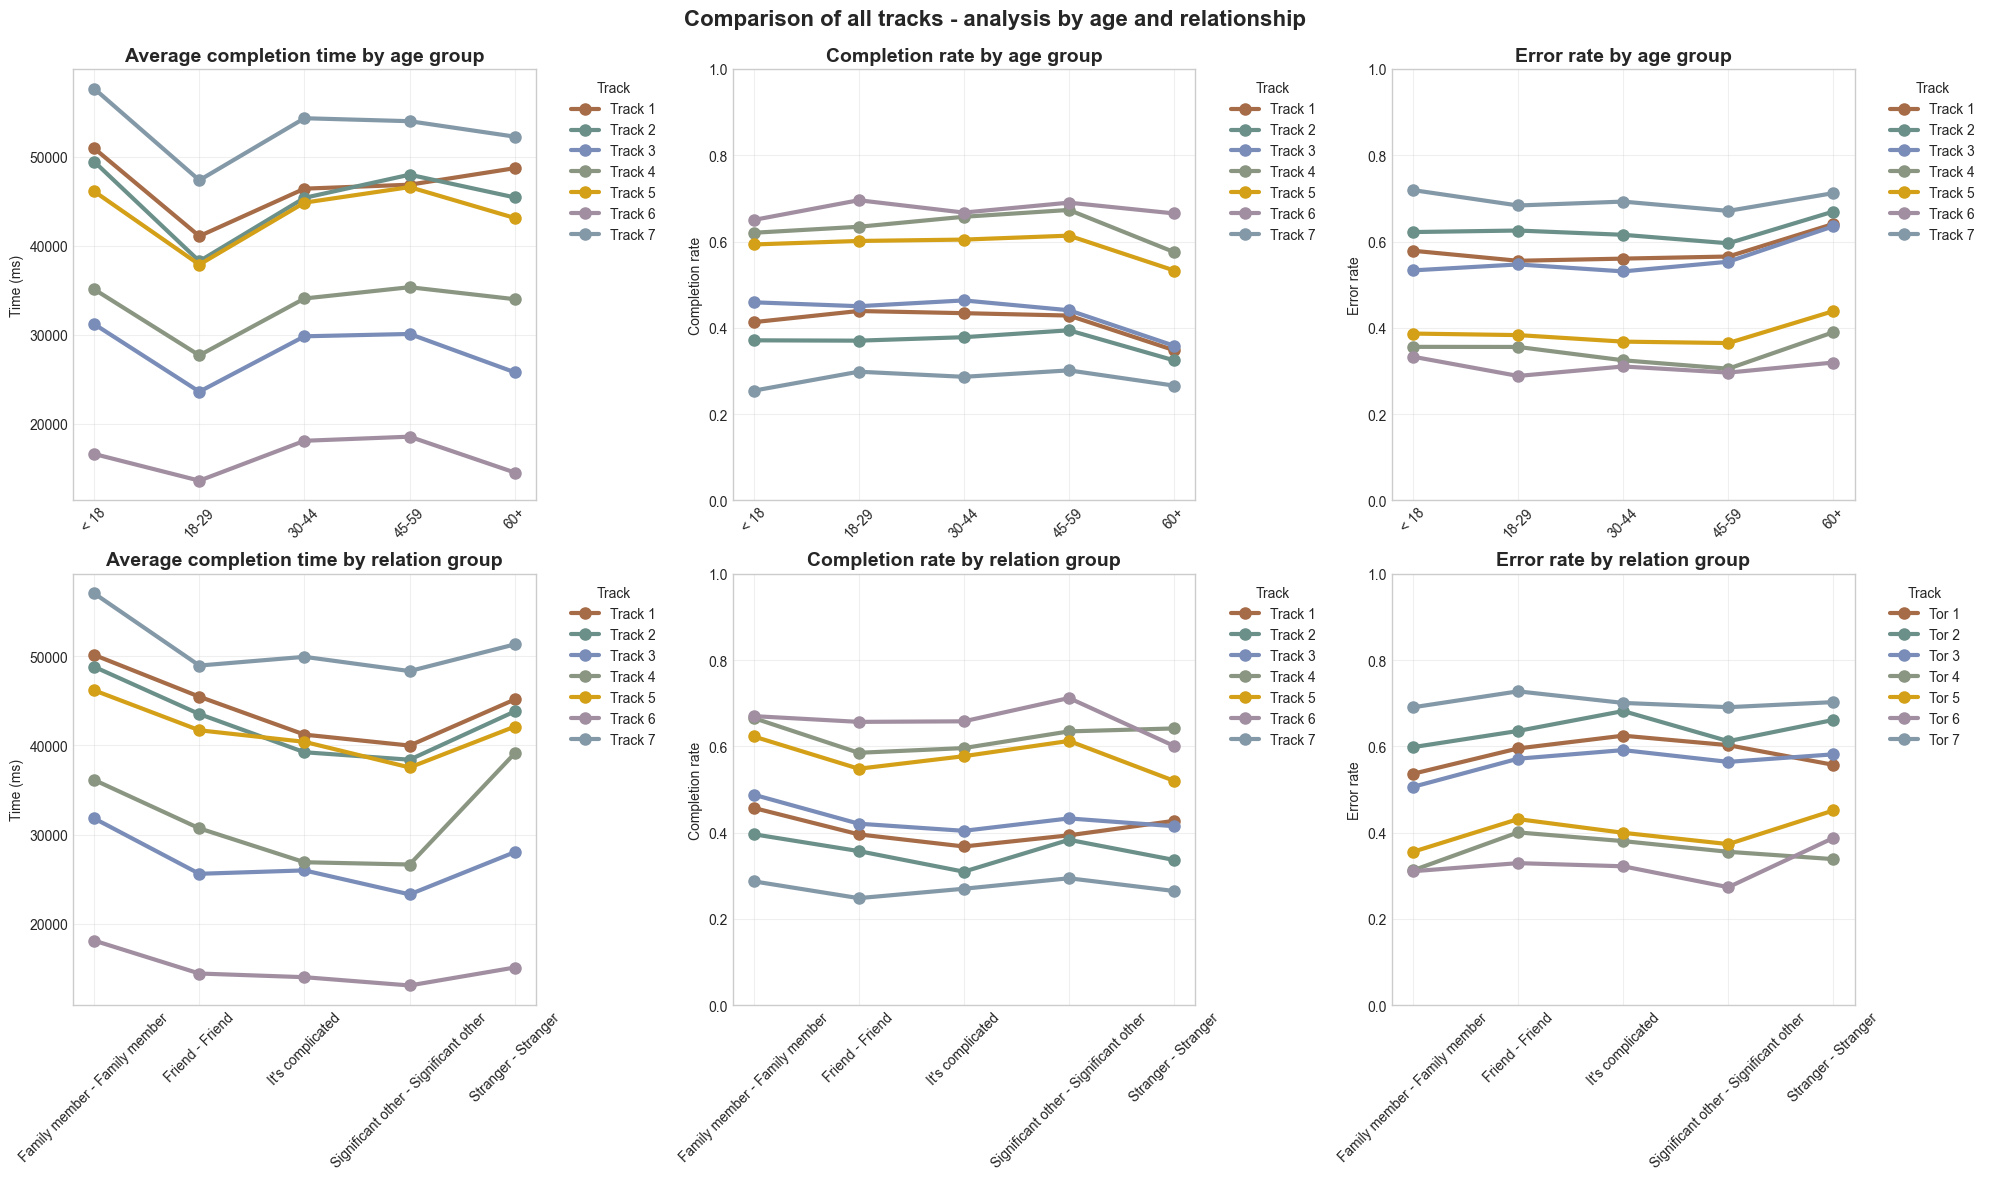

UWAGA: Brak wyników do wygenerowania raportu!

ANALIZA ZAKOŃCZONA
Wyniki zapisane w folderze 'wyniki_analizy':
- Wykresy z testami statystycznymi i wąsami istotności
- Tabele CSV uporządkowane według średnich czasów
- Raport podsumowujący z istotnościami statystycznymi


In [11]:
main()


=== ROZPOCZĘCIE ANALIZY GIER ORTHO ===
Z testami statystycznymi i wąsami istotności

Wczytywanie pliku output/games/games.csv...
Wczytano surowe dane: 128179 wierszy
Filtrowanie danych...
Unikalne Track_ID przed filtrowaniem: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 23]
Liczba wierszy po wstępnym filtrowaniu: 91861
Liczba wierszy po usunięciu brakujących wartości: 91861
Typy danych przed konwersją:
Age_X_axis    float64
Age_Y_axis    float64
Track_Time      int64
Track_ID        int64
dtype: object
Liczba wartości NaN po konwersji:
Age_X_axis    0
Age_Y_axis    0
Track_Time    0
Track_ID      0
dtype: int64
Liczba wierszy po usunięciu wartości NaN po konwersji: 91861
Unikalne wartości w kolumnie Track_Completed: [ True False]
Liczba wartości None/NaN w Track_Completed po konwersji: 0
Unikalne wartości w kolumnie Mistake: [False  True]
Liczba wartości None/NaN w Mistake po konwersji: 0
Unikalne grupy wiekowe X: ['18-29' '30-44' '< 18' '45-59' '60+']
Unikalne grupy wiekowe Y: ['18

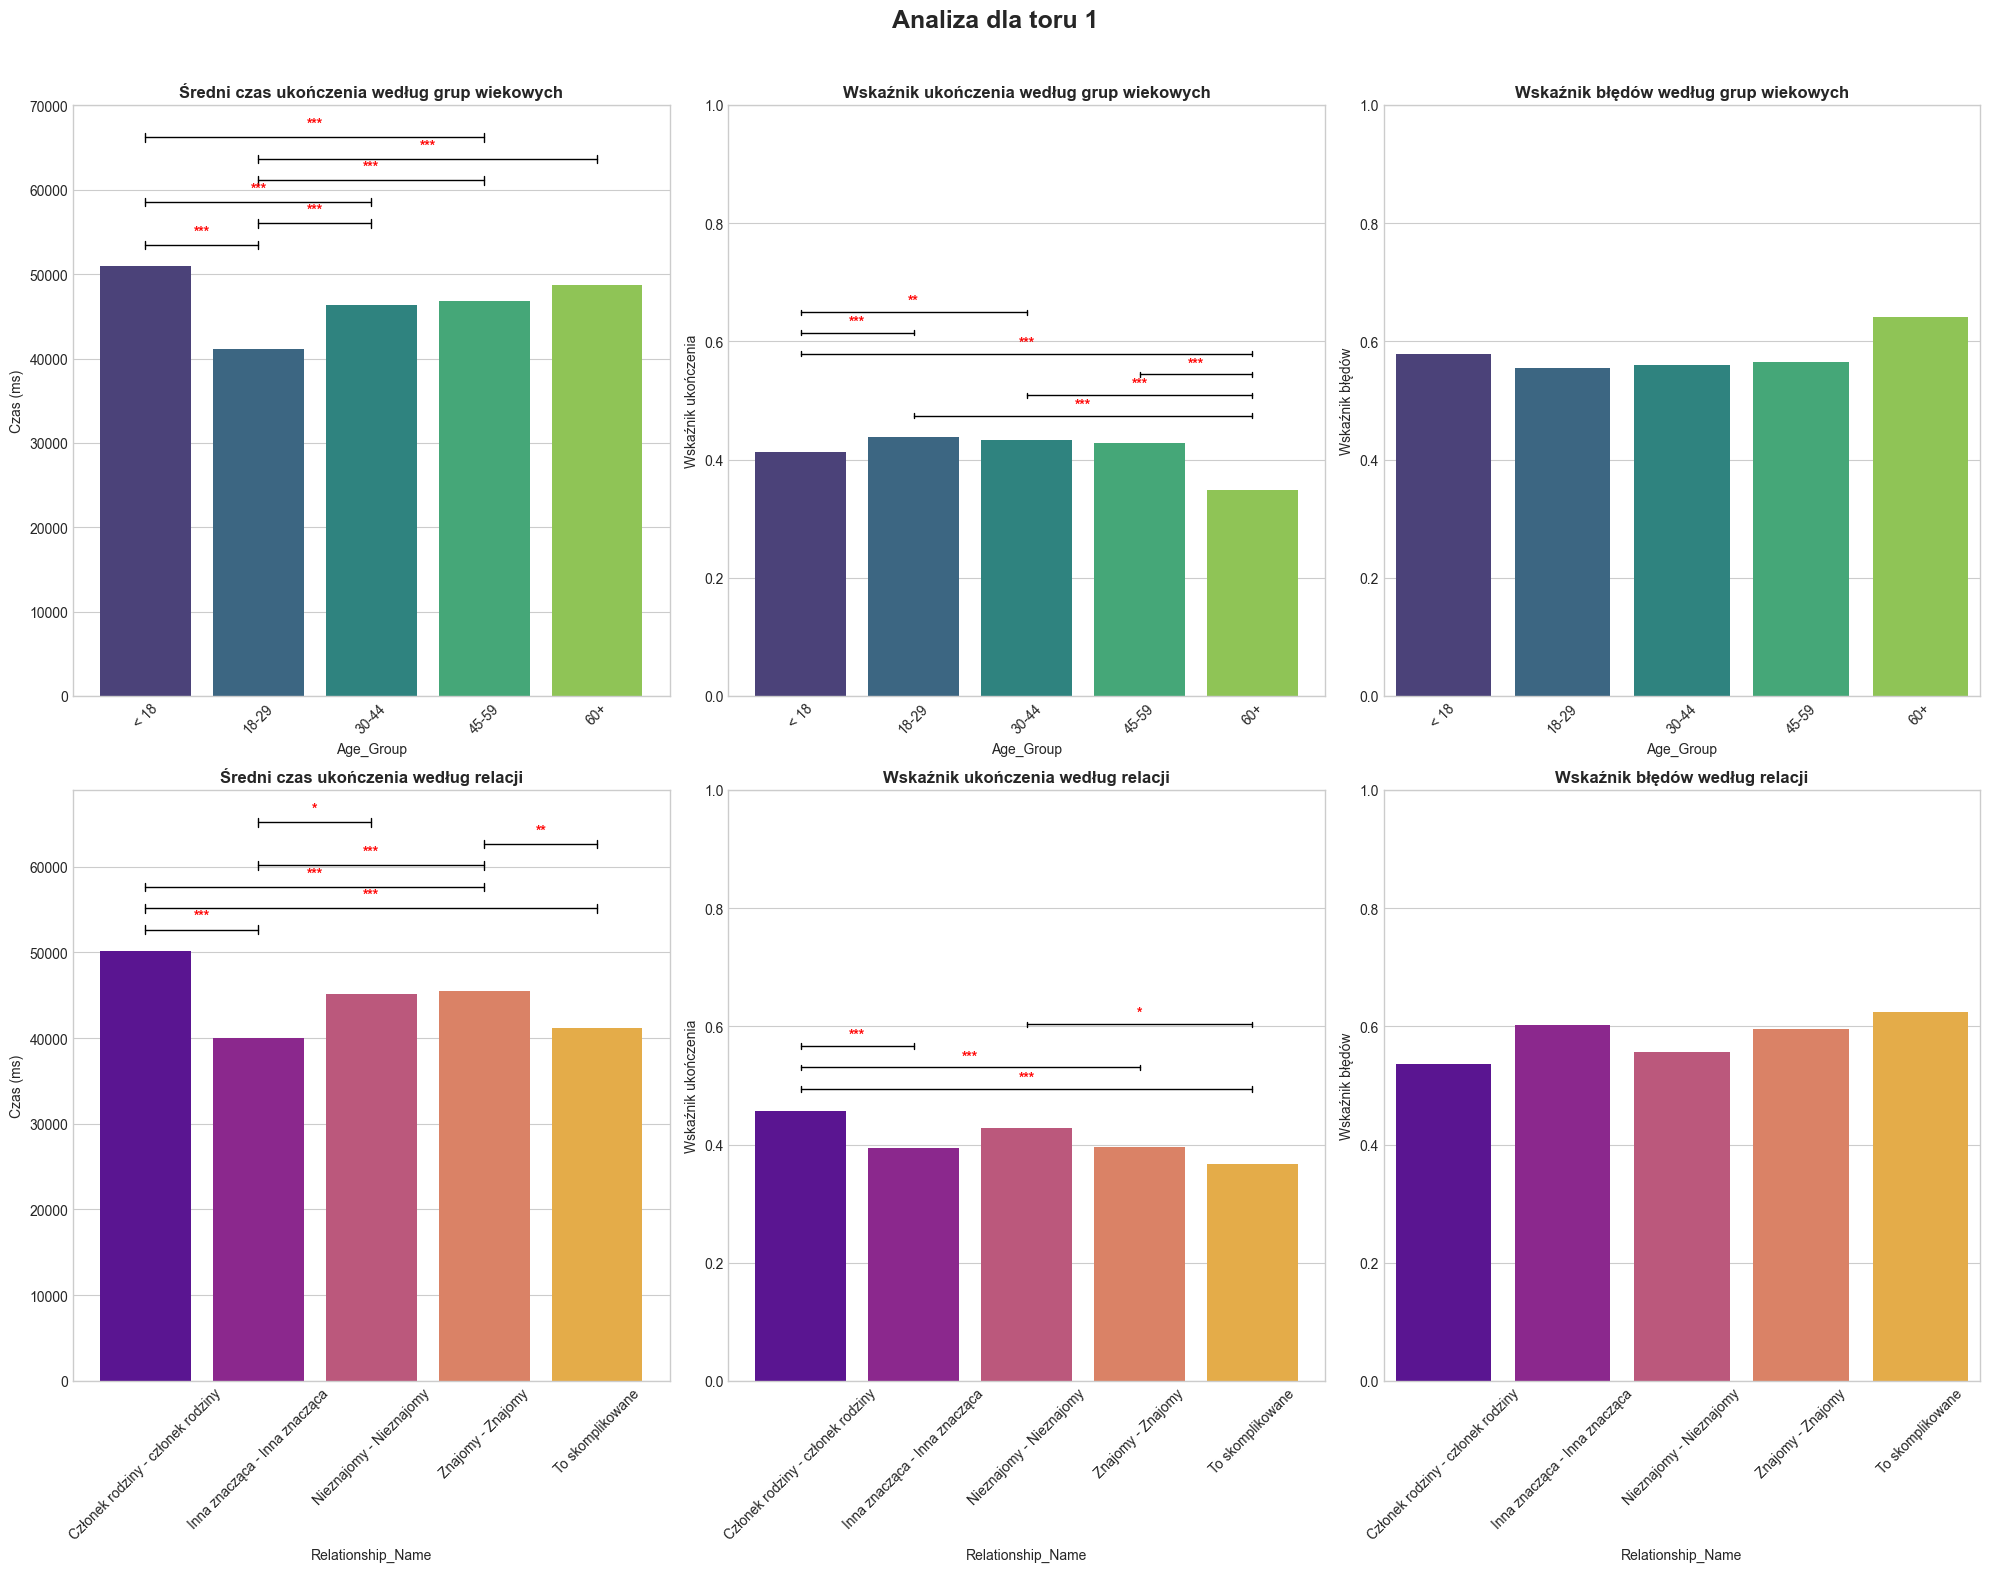

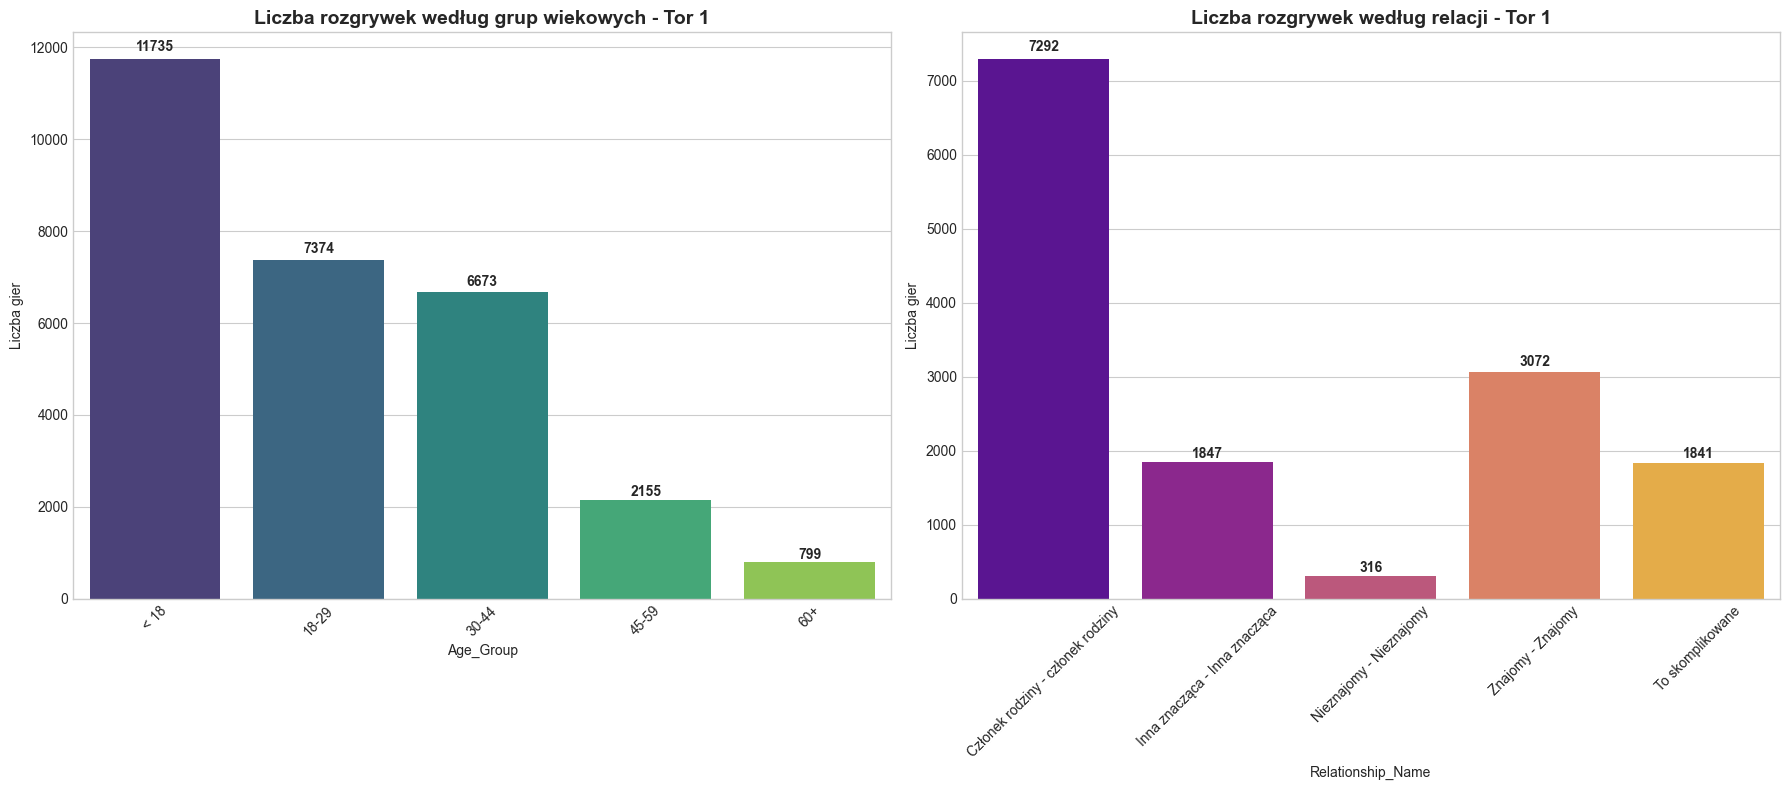


=== WYNIKI TESTÓW STATYSTYCZNYCH - TOR 1 ===

Testy dla CZASU UKOŃCZENIA według WIEKU:
18-29 vs 30-44: p=0.0000 ***
18-29 vs 45-59: p=0.0000 ***
18-29 vs 60+: p=0.0000 ***
18-29 vs < 18: p=0.0000 ***
30-44 vs 45-59: p=0.7020 ns
30-44 vs 60+: p=0.2366 ns
30-44 vs < 18: p=0.0000 ***
45-59 vs 60+: p=0.4019 ns
45-59 vs < 18: p=0.0009 ***
60+ vs < 18: p=0.3009 ns

Testy dla WSKAŹNIKA UKOŃCZENIA według WIEKU:
18-29 vs 30-44: p=0.5506 ns
18-29 vs 45-59: p=0.3858 ns
18-29 vs 60+: p=0.0000 ***
18-29 vs < 18: p=0.0004 ***
30-44 vs 45-59: p=0.6523 ns
30-44 vs 60+: p=0.0000 ***
30-44 vs < 18: p=0.0058 **
45-59 vs 60+: p=0.0001 ***
45-59 vs < 18: p=0.1837 ns
60+ vs < 18: p=0.0003 ***

Testy dla CZASU UKOŃCZENIA według RELACJI:
Członek rodziny - członek rodziny vs Inna znacząca - Inna znacząca: p=0.0000 ***
Członek rodziny - członek rodziny vs Nieznajomy - Nieznajomy: p=0.0888 ns
Członek rodziny - członek rodziny vs To skomplikowane: p=0.0000 ***
Członek rodziny - członek rodziny vs Znajomy - Znajo

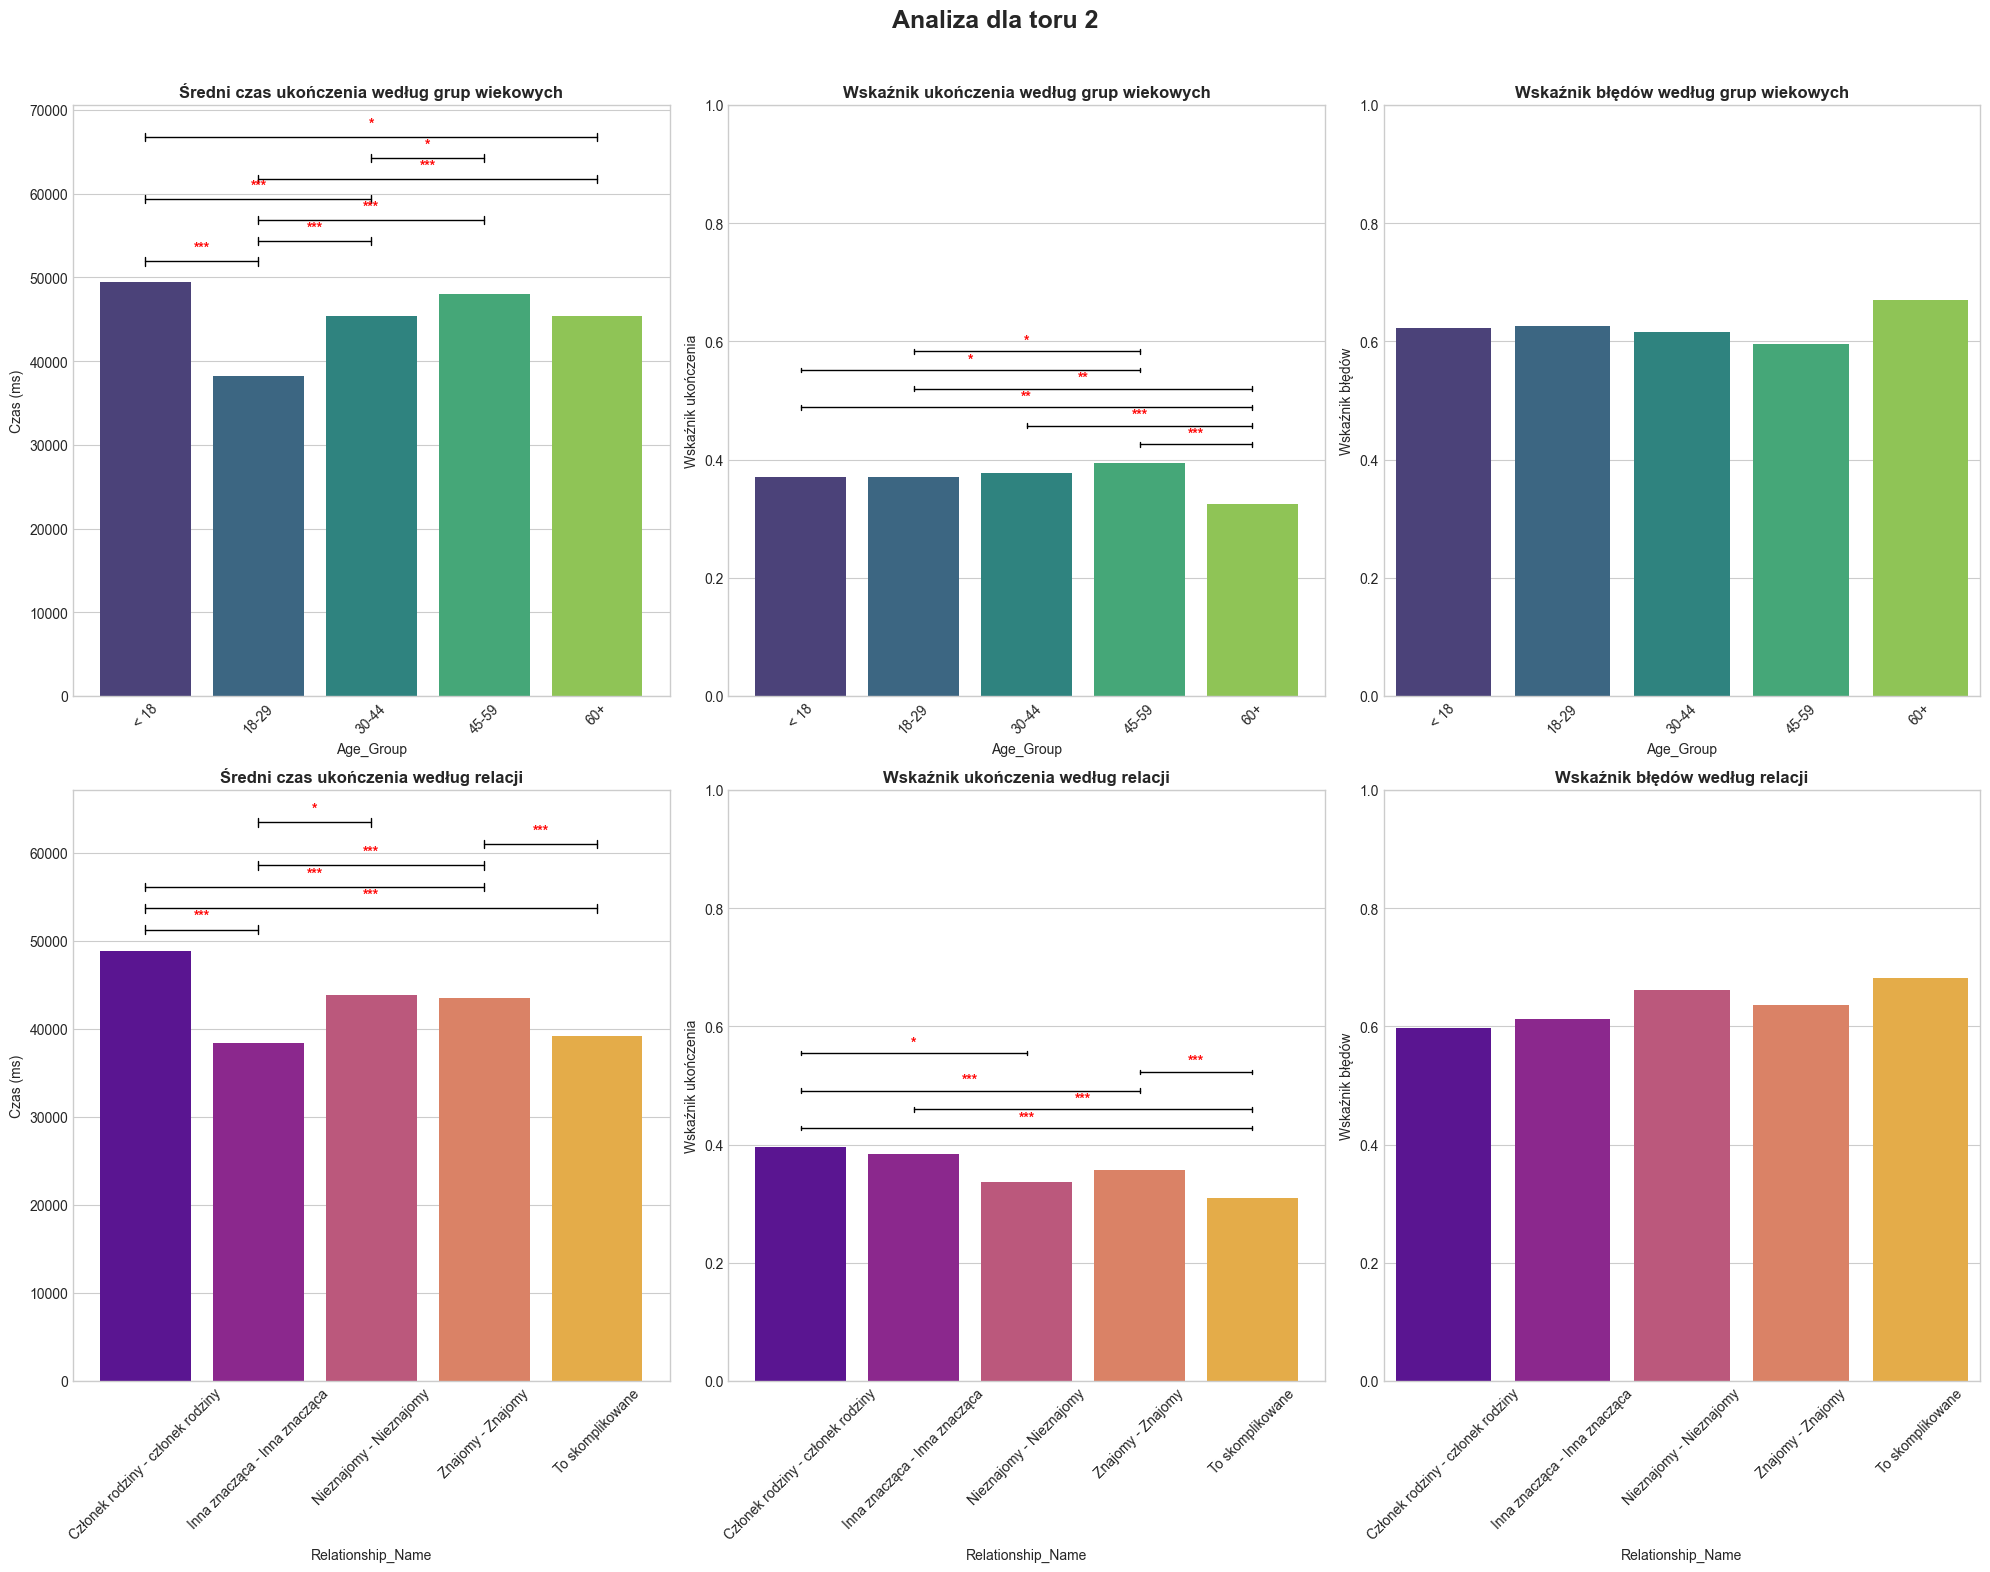

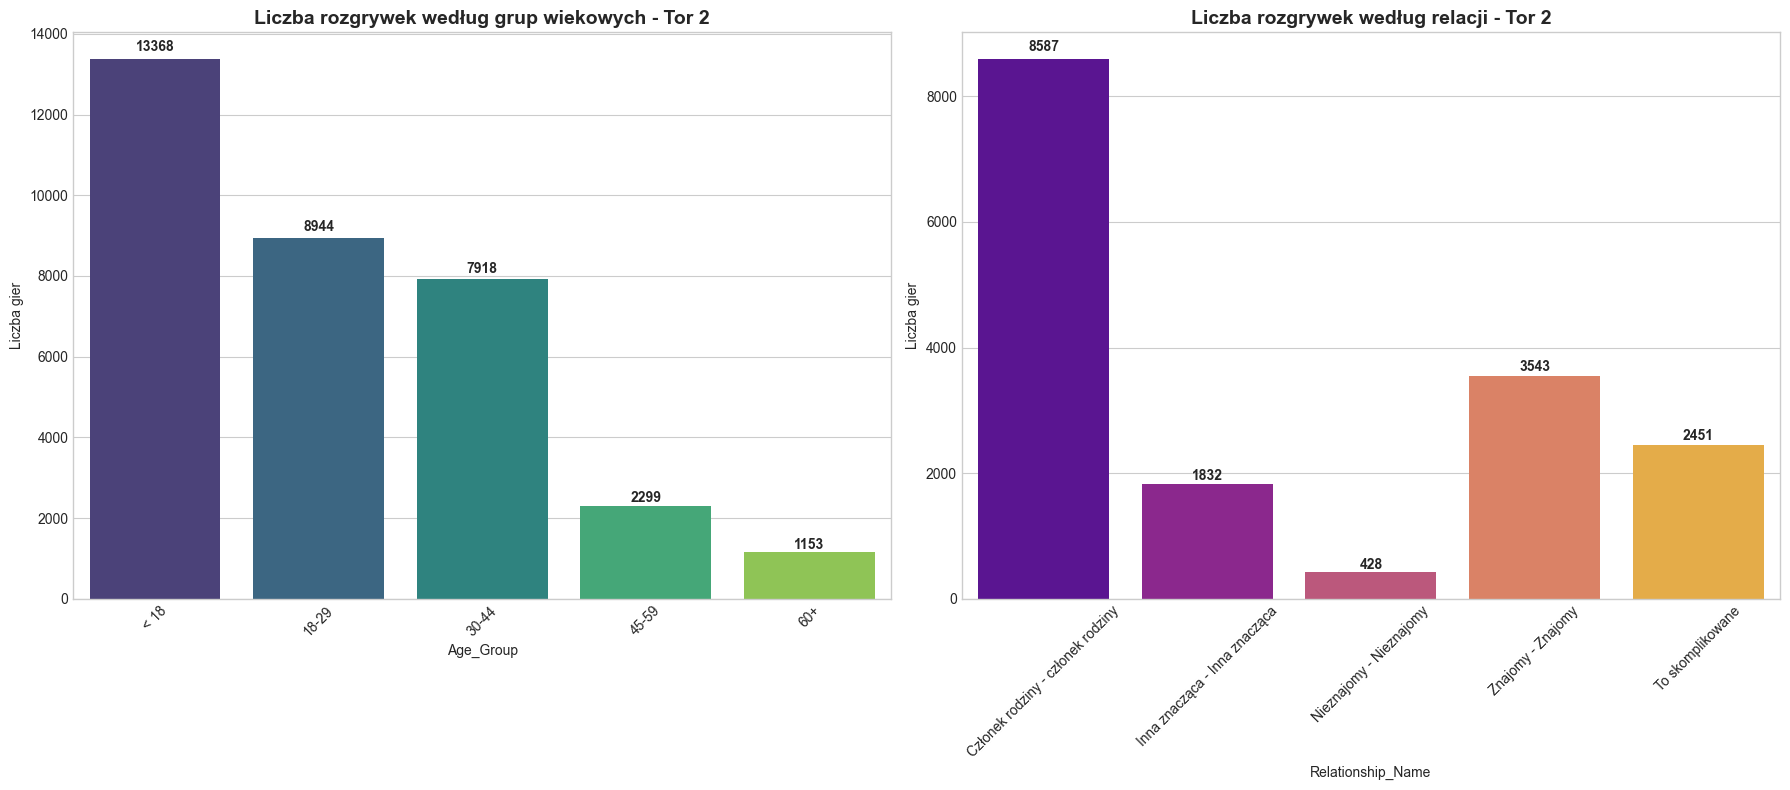


=== WYNIKI TESTÓW STATYSTYCZNYCH - TOR 2 ===

Testy dla CZASU UKOŃCZENIA według WIEKU:
18-29 vs 30-44: p=0.0000 ***
18-29 vs 45-59: p=0.0000 ***
18-29 vs 60+: p=0.0000 ***
18-29 vs < 18: p=0.0000 ***
30-44 vs 45-59: p=0.0155 *
30-44 vs 60+: p=0.9754 ns
30-44 vs < 18: p=0.0000 ***
45-59 vs 60+: p=0.1953 ns
45-59 vs < 18: p=0.1957 ns
60+ vs < 18: p=0.0194 *

Testy dla WSKAŹNIKA UKOŃCZENIA według WIEKU:
18-29 vs 30-44: p=0.2812 ns
18-29 vs 45-59: p=0.0340 *
18-29 vs 60+: p=0.0024 **
18-29 vs < 18: p=0.9029 ns
30-44 vs 45-59: p=0.1656 ns
30-44 vs 60+: p=0.0004 ***
30-44 vs < 18: p=0.2913 ns
45-59 vs 60+: p=0.0001 ***
45-59 vs < 18: p=0.0337 *
60+ vs < 18: p=0.0017 **

Testy dla CZASU UKOŃCZENIA według RELACJI:
Członek rodziny - członek rodziny vs Inna znacząca - Inna znacząca: p=0.0000 ***
Członek rodziny - członek rodziny vs Nieznajomy - Nieznajomy: p=0.0586 ns
Członek rodziny - członek rodziny vs To skomplikowane: p=0.0000 ***
Członek rodziny - członek rodziny vs Znajomy - Znajomy: p=0.

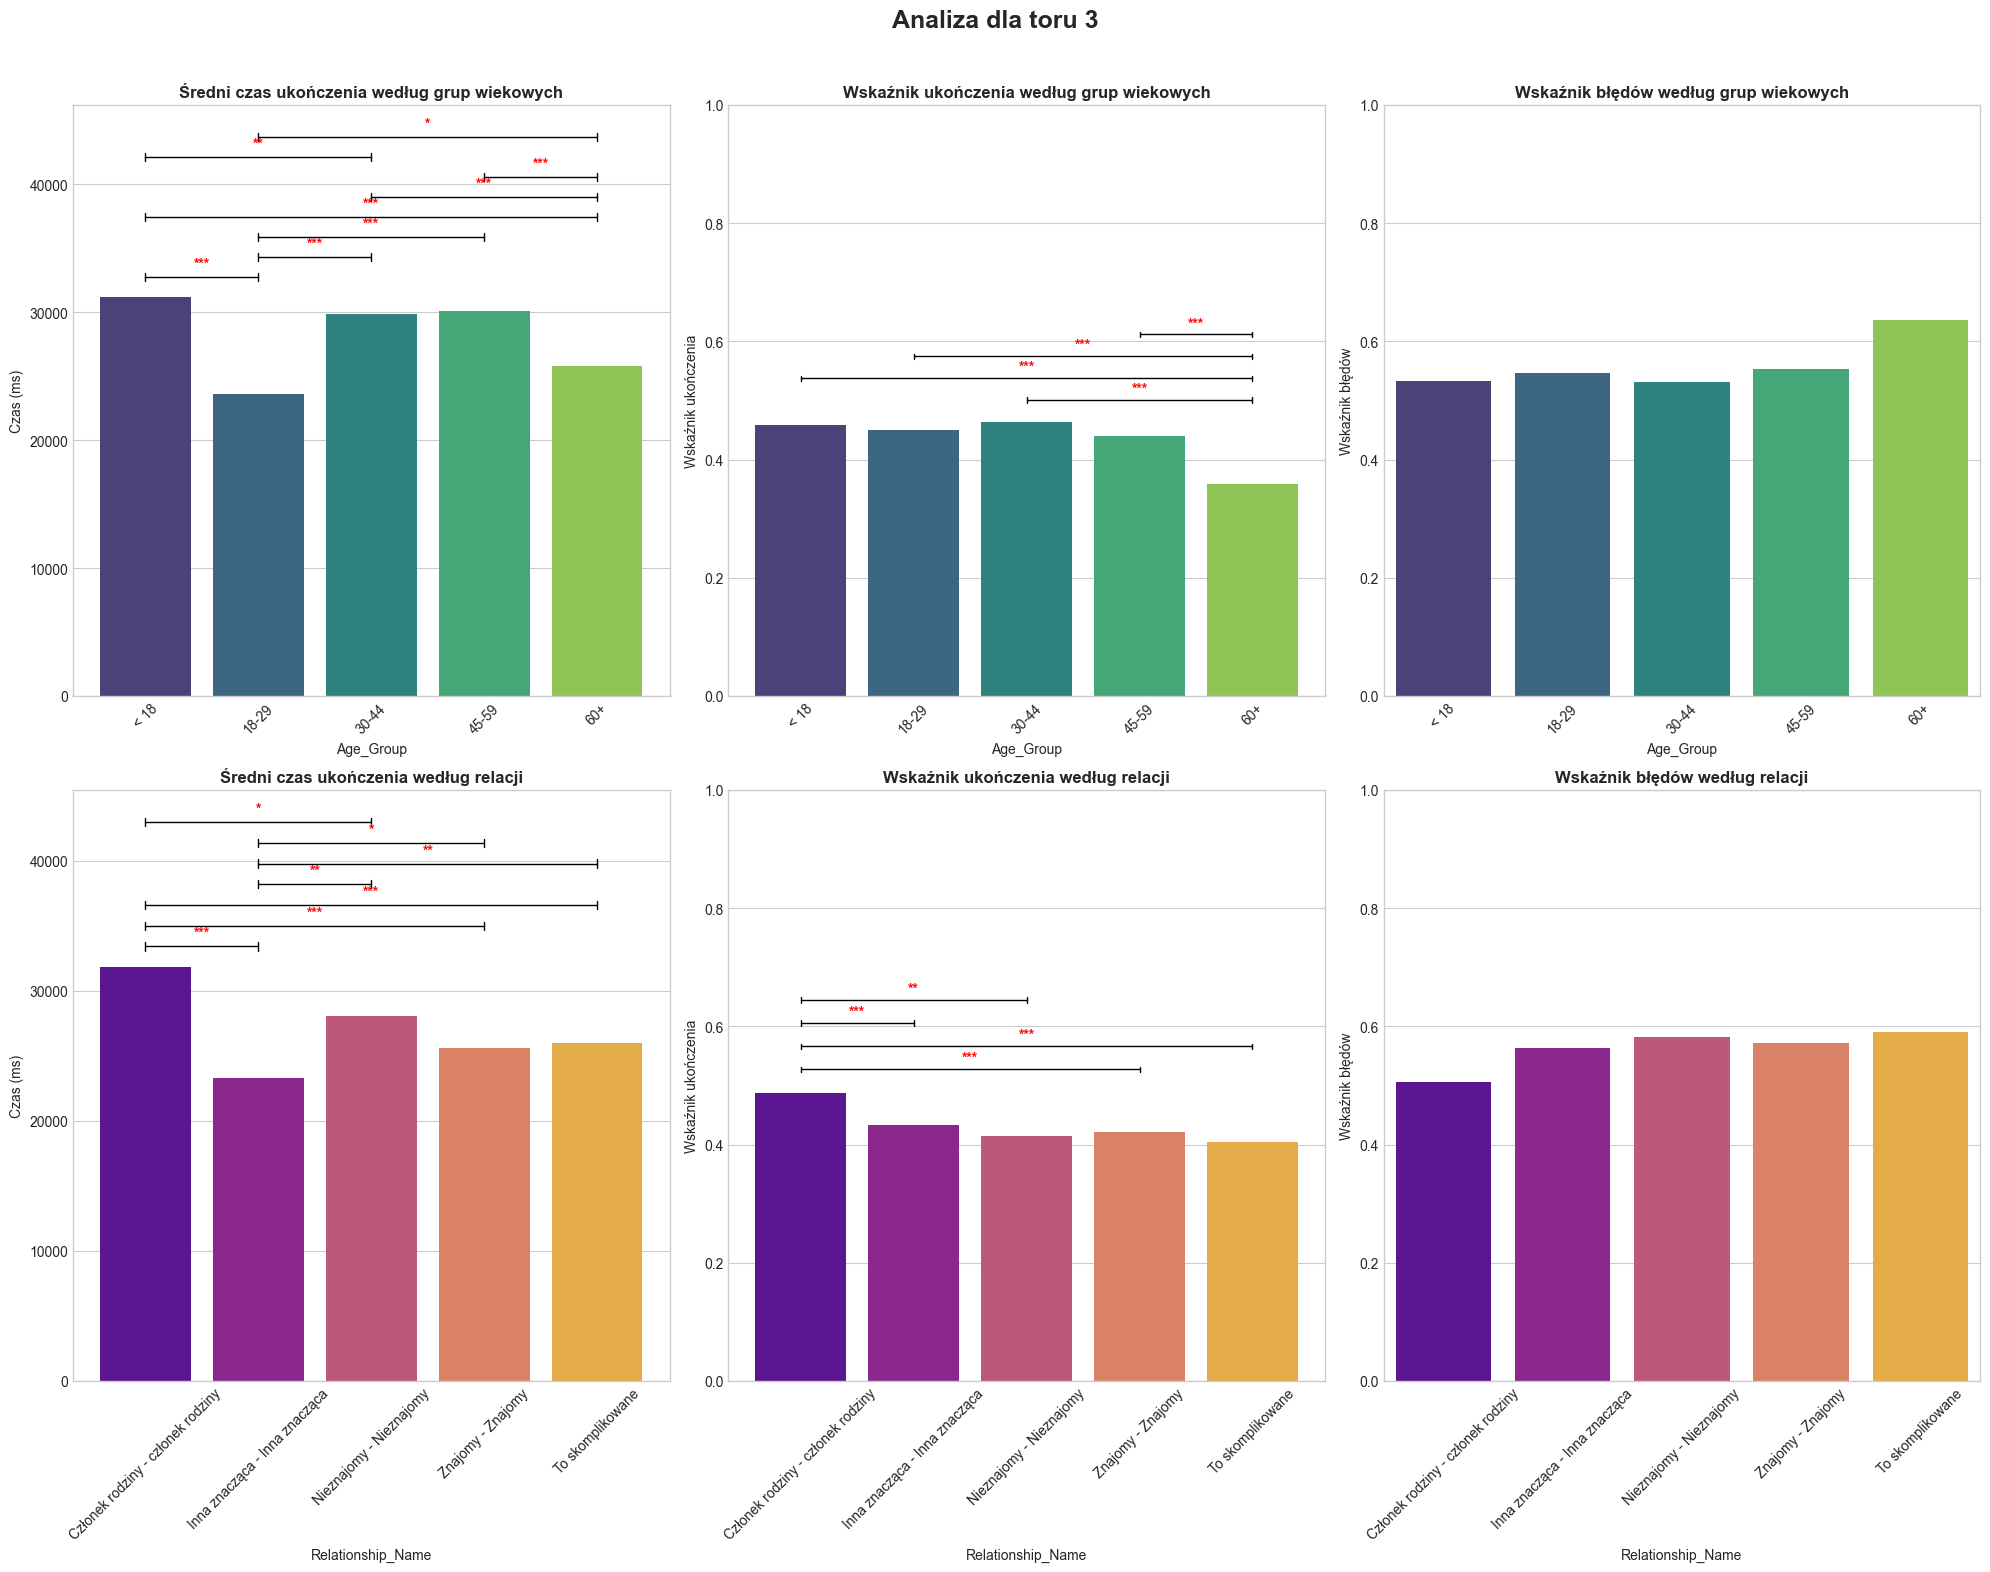

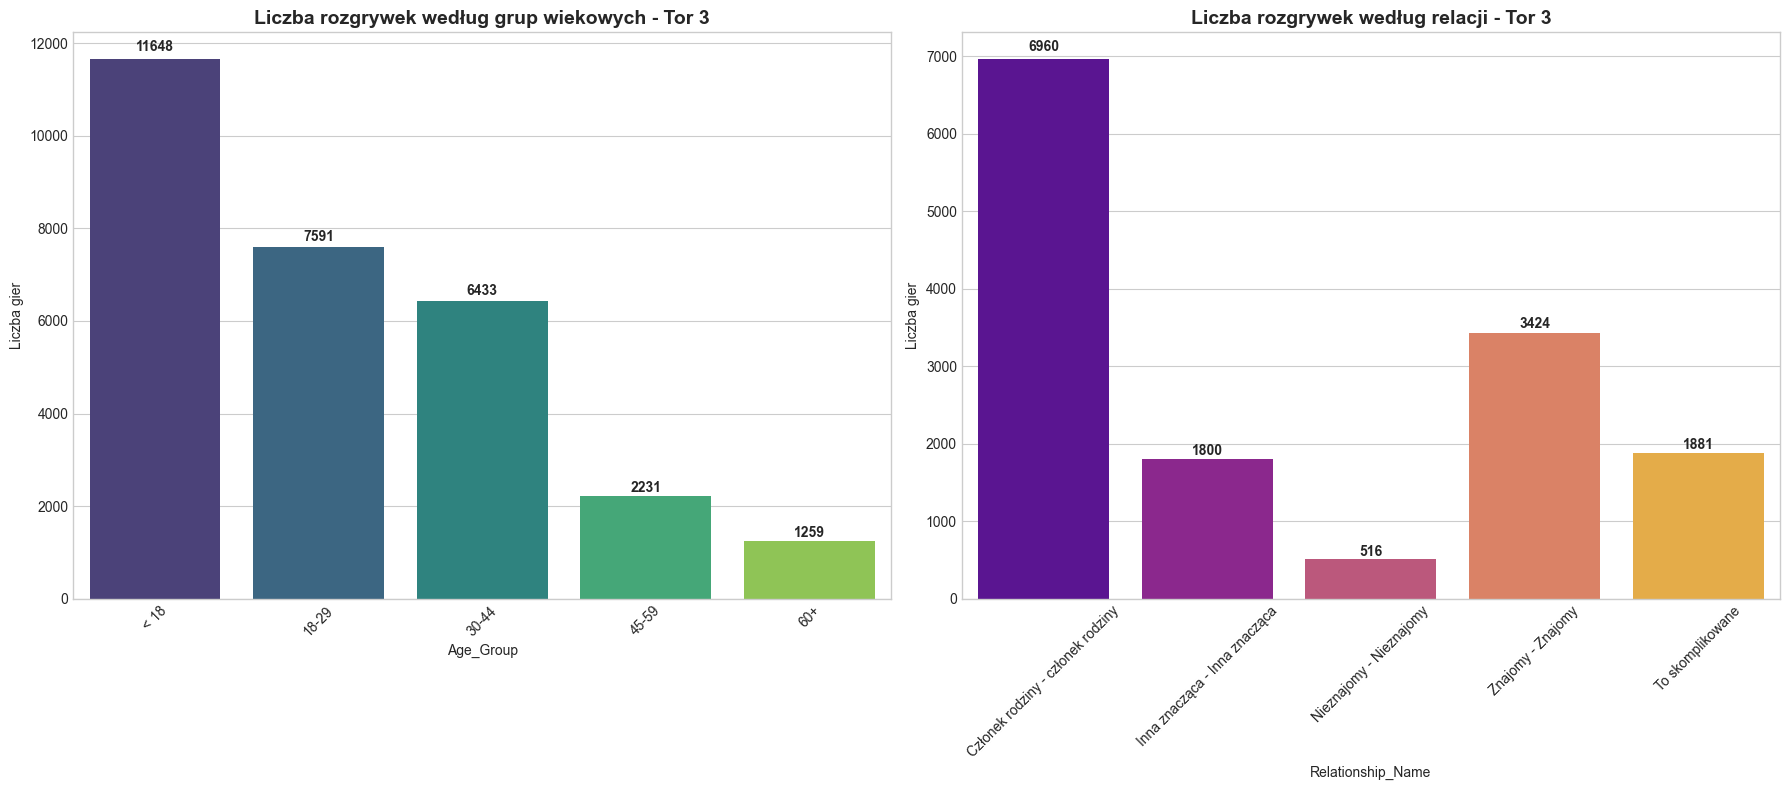


=== WYNIKI TESTÓW STATYSTYCZNYCH - TOR 3 ===

Testy dla CZASU UKOŃCZENIA według WIEKU:
18-29 vs 30-44: p=0.0000 ***
18-29 vs 45-59: p=0.0000 ***
18-29 vs 60+: p=0.0209 *
18-29 vs < 18: p=0.0000 ***
30-44 vs 45-59: p=0.7265 ns
30-44 vs 60+: p=0.0001 ***
30-44 vs < 18: p=0.0054 **
45-59 vs 60+: p=0.0002 ***
45-59 vs < 18: p=0.1438 ns
60+ vs < 18: p=0.0000 ***

Testy dla WSKAŹNIKA UKOŃCZENIA według WIEKU:
18-29 vs 30-44: p=0.1128 ns
18-29 vs 45-59: p=0.4327 ns
18-29 vs 60+: p=0.0000 ***
18-29 vs < 18: p=0.2184 ns
30-44 vs 45-59: p=0.0627 ns
30-44 vs 60+: p=0.0000 ***
30-44 vs < 18: p=0.5749 ns
45-59 vs 60+: p=0.0000 ***
45-59 vs < 18: p=0.1092 ns
60+ vs < 18: p=0.0000 ***

Testy dla CZASU UKOŃCZENIA według RELACJI:
Członek rodziny - członek rodziny vs Inna znacząca - Inna znacząca: p=0.0000 ***
Członek rodziny - członek rodziny vs Nieznajomy - Nieznajomy: p=0.0126 *
Członek rodziny - członek rodziny vs To skomplikowane: p=0.0000 ***
Członek rodziny - członek rodziny vs Znajomy - Znajomy:

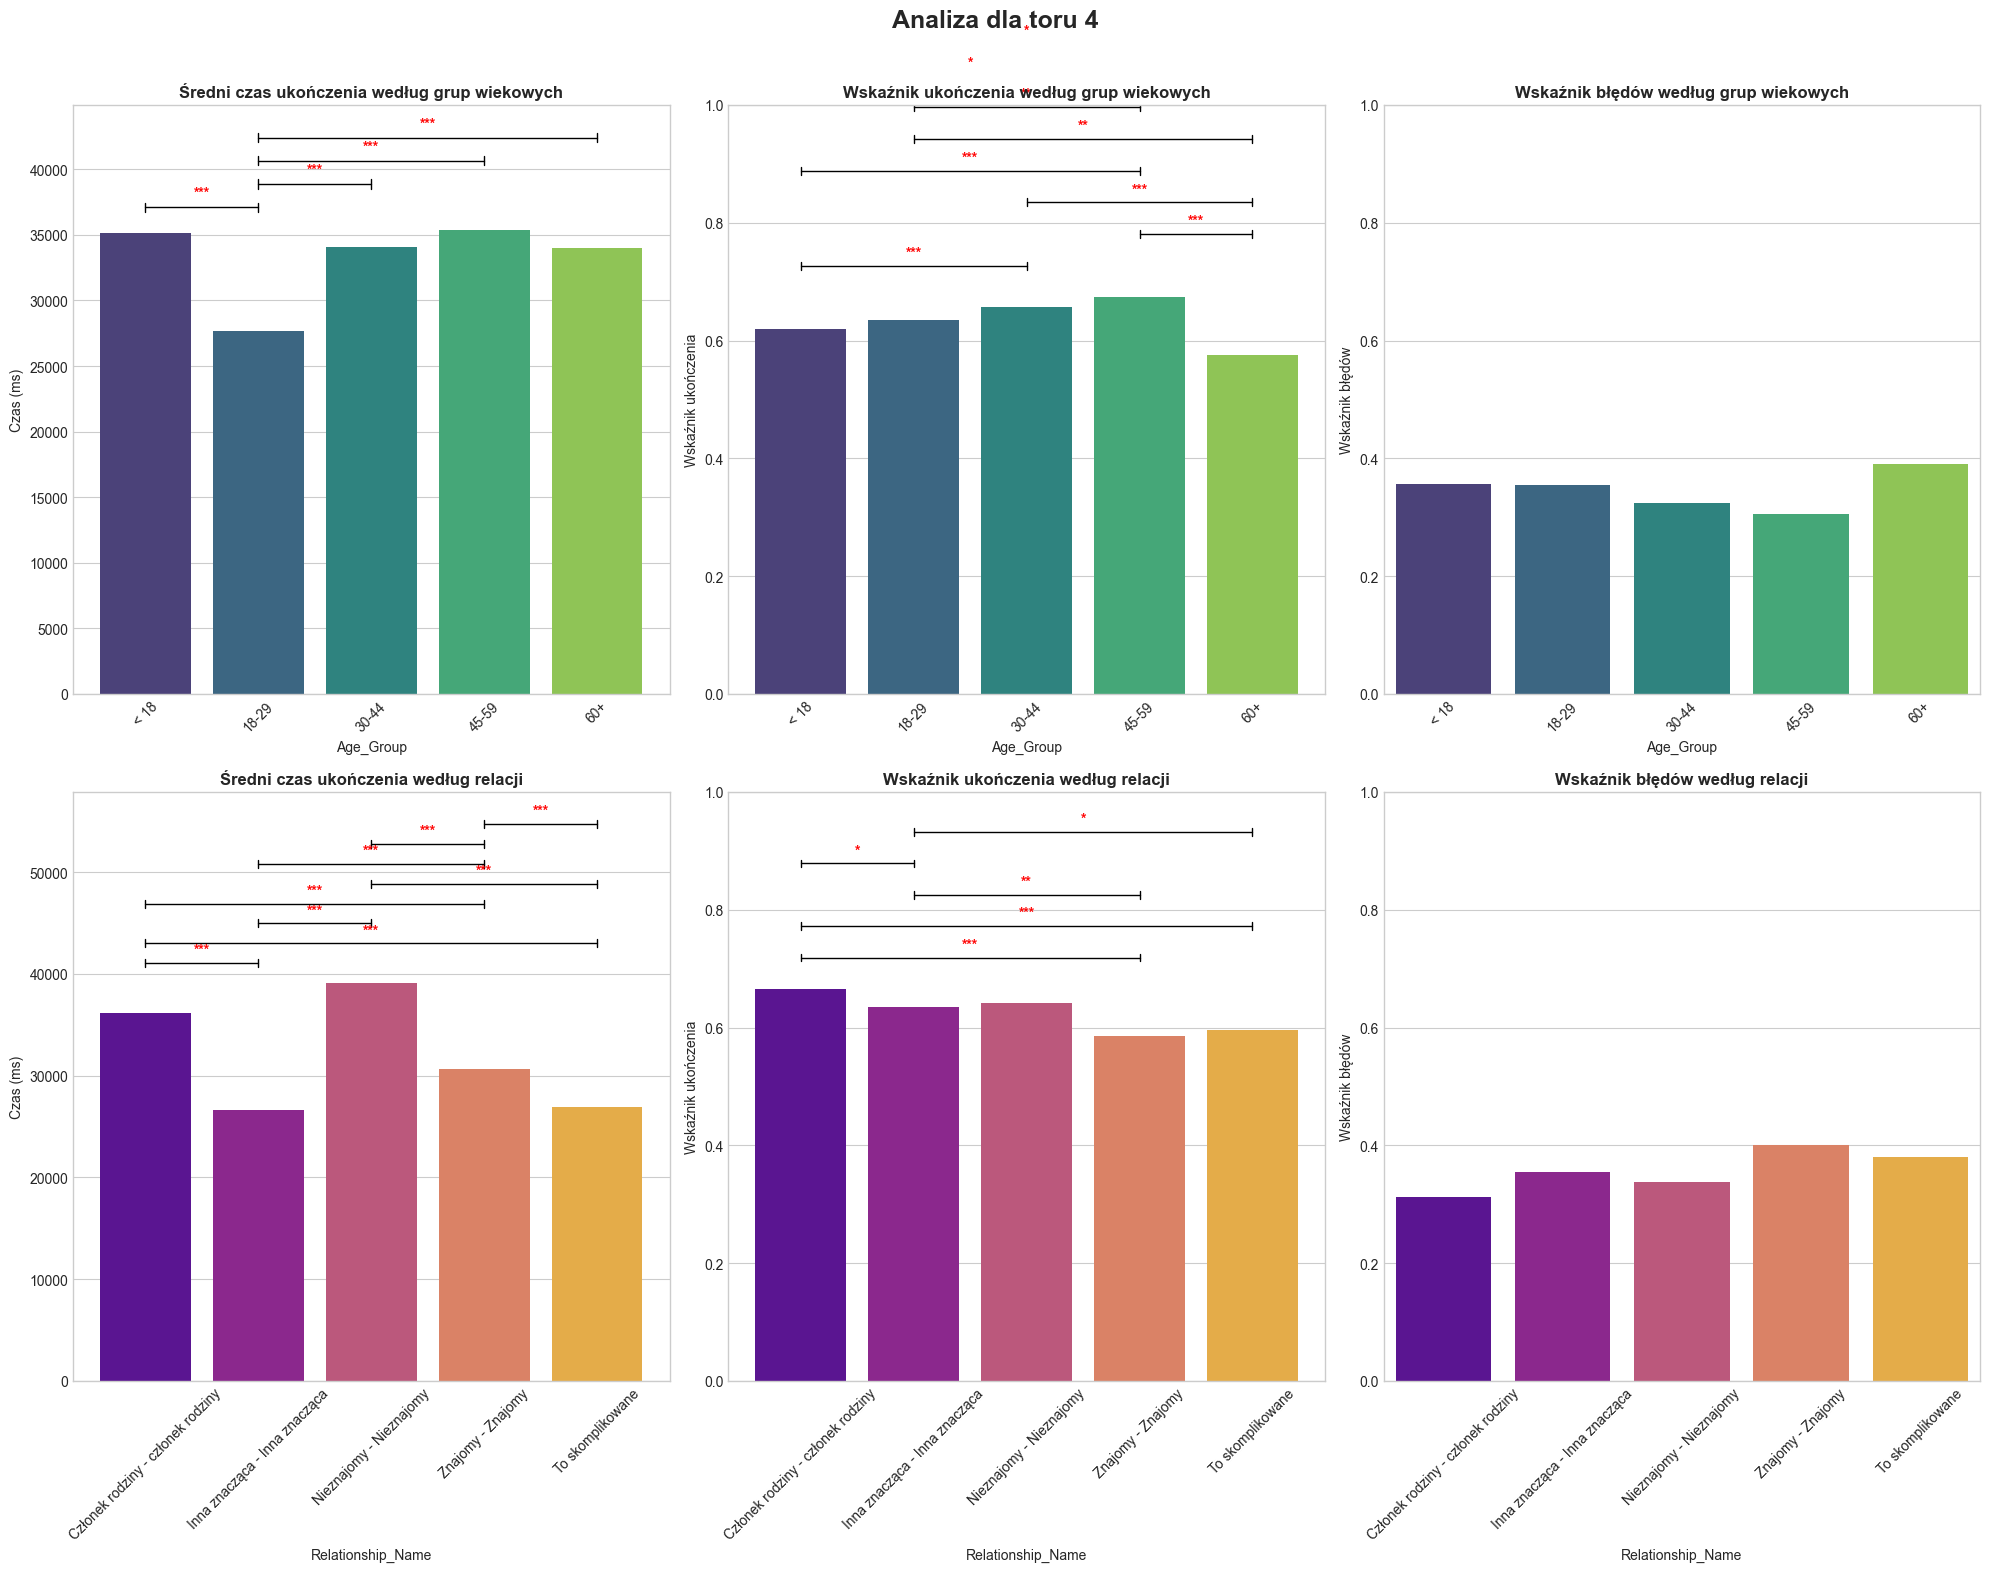

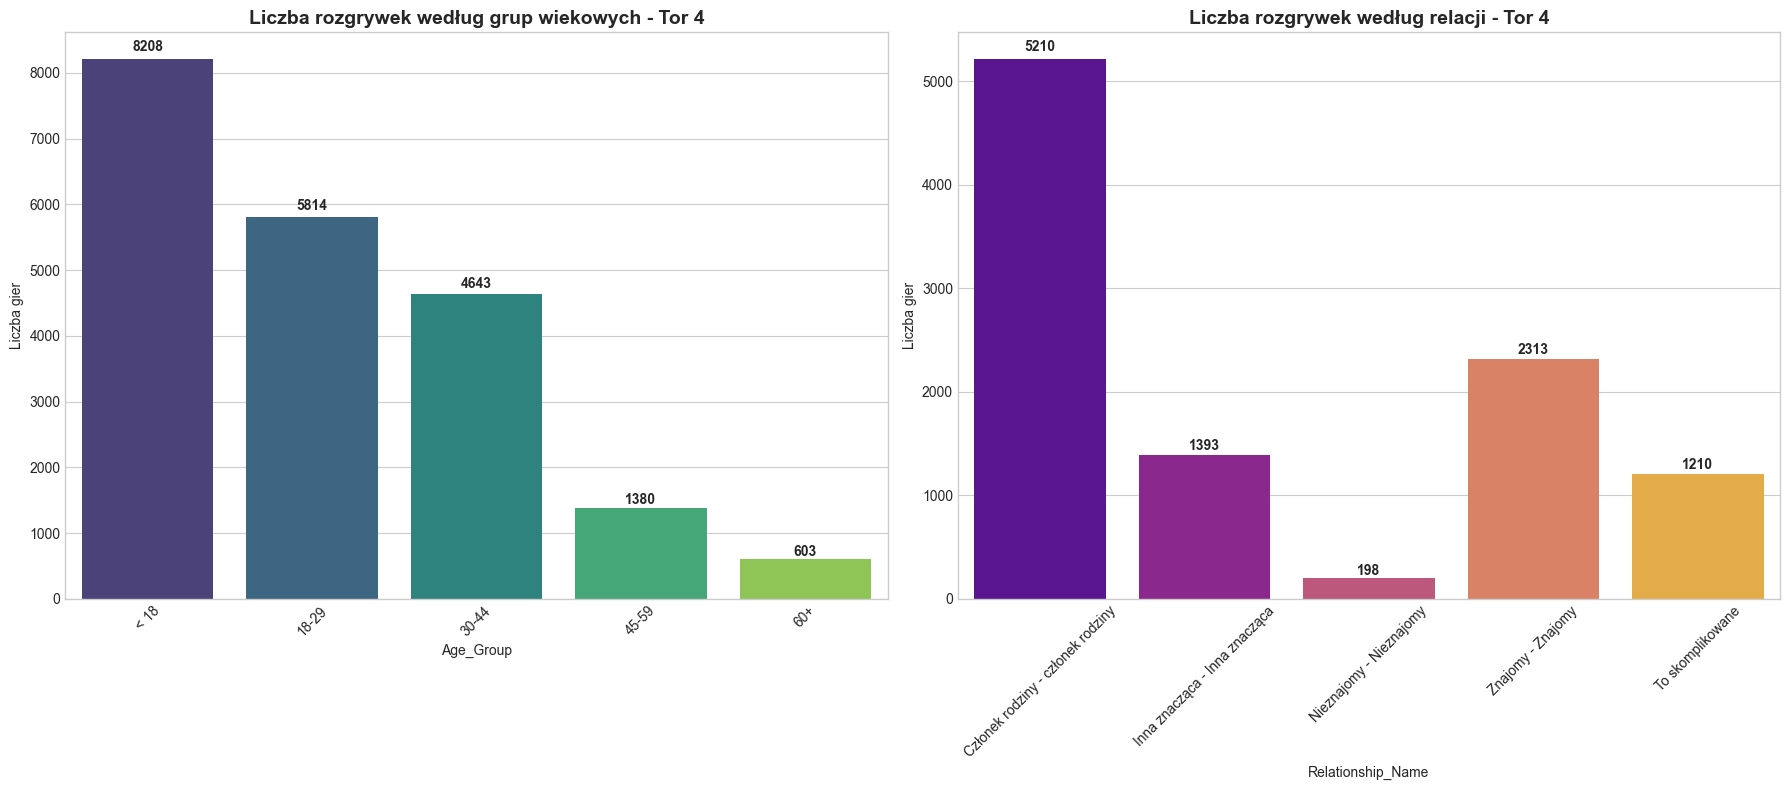


=== WYNIKI TESTÓW STATYSTYCZNYCH - TOR 4 ===

Testy dla CZASU UKOŃCZENIA według WIEKU:
18-29 vs 30-44: p=0.0000 ***
18-29 vs 45-59: p=0.0000 ***
18-29 vs 60+: p=0.0000 ***
18-29 vs < 18: p=0.0000 ***
30-44 vs 45-59: p=0.2028 ns
30-44 vs 60+: p=0.9588 ns
30-44 vs < 18: p=0.1047 ns
45-59 vs 60+: p=0.4214 ns
45-59 vs < 18: p=0.8106 ns
60+ vs < 18: p=0.4798 ns

Testy dla WSKAŹNIKA UKOŃCZENIA według WIEKU:
18-29 vs 30-44: p=0.0139 *
18-29 vs 45-59: p=0.0066 **
18-29 vs 60+: p=0.0045 **
18-29 vs < 18: p=0.0935 ns
30-44 vs 45-59: p=0.2747 ns
30-44 vs 60+: p=0.0001 ***
30-44 vs < 18: p=0.0000 ***
45-59 vs 60+: p=0.0000 ***
45-59 vs < 18: p=0.0002 ***
60+ vs < 18: p=0.0290 *

Testy dla CZASU UKOŃCZENIA według RELACJI:
Członek rodziny - członek rodziny vs Inna znacząca - Inna znacząca: p=0.0000 ***
Członek rodziny - członek rodziny vs Nieznajomy - Nieznajomy: p=0.2377 ns
Członek rodziny - członek rodziny vs To skomplikowane: p=0.0000 ***
Członek rodziny - członek rodziny vs Znajomy - Znajomy: p

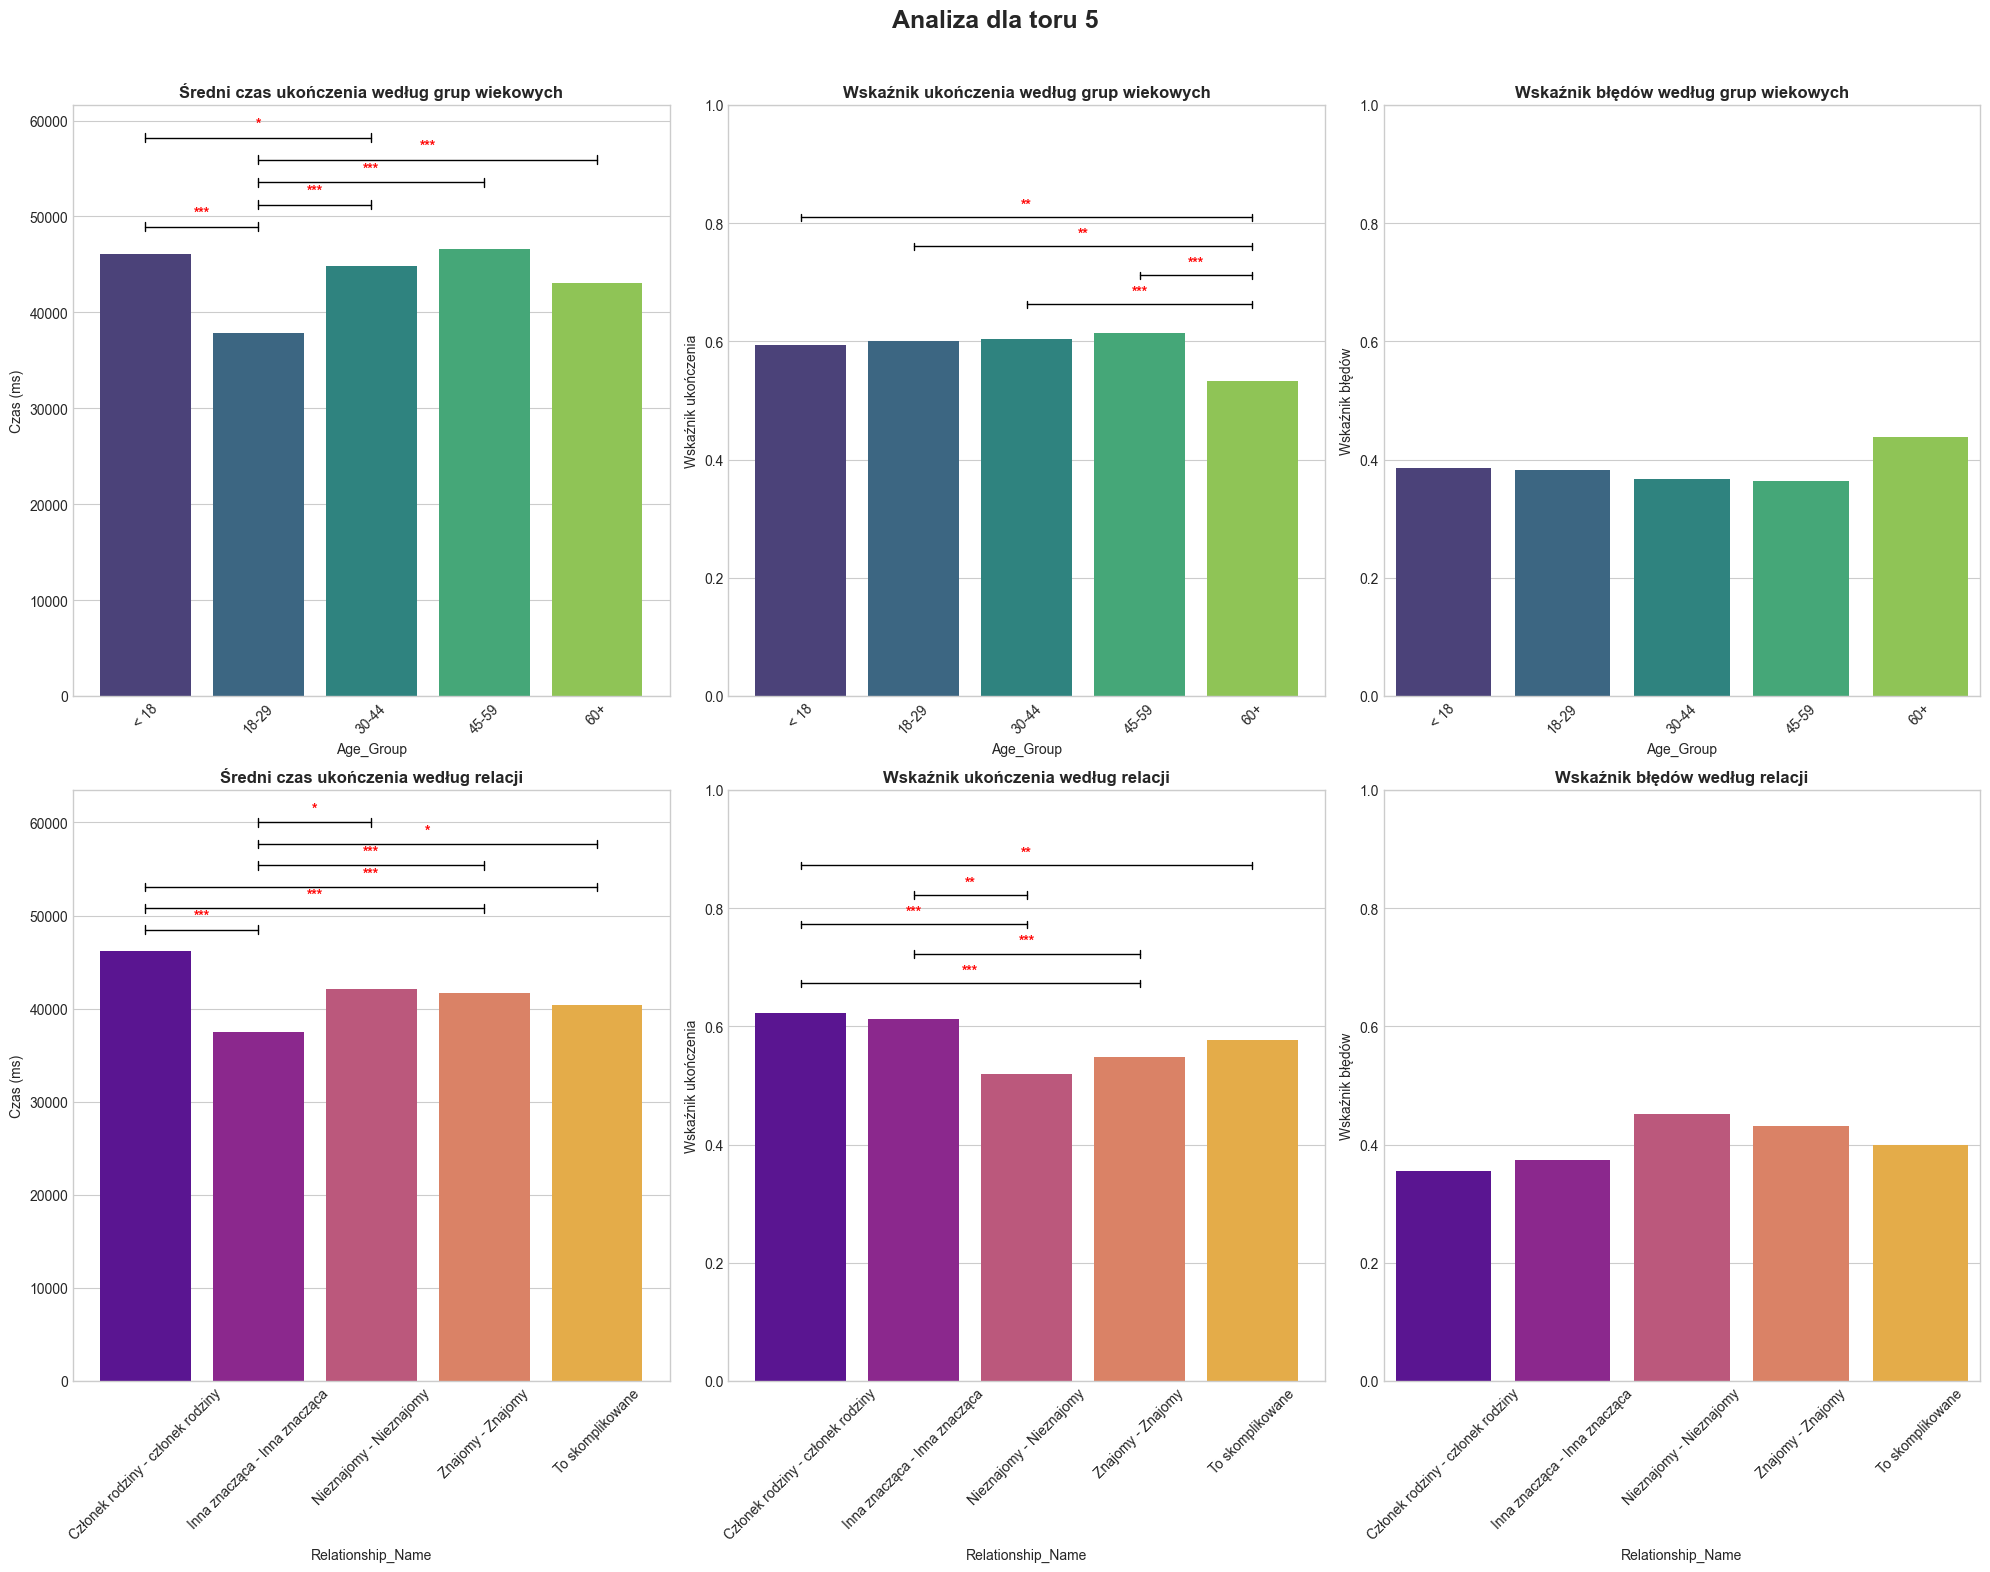

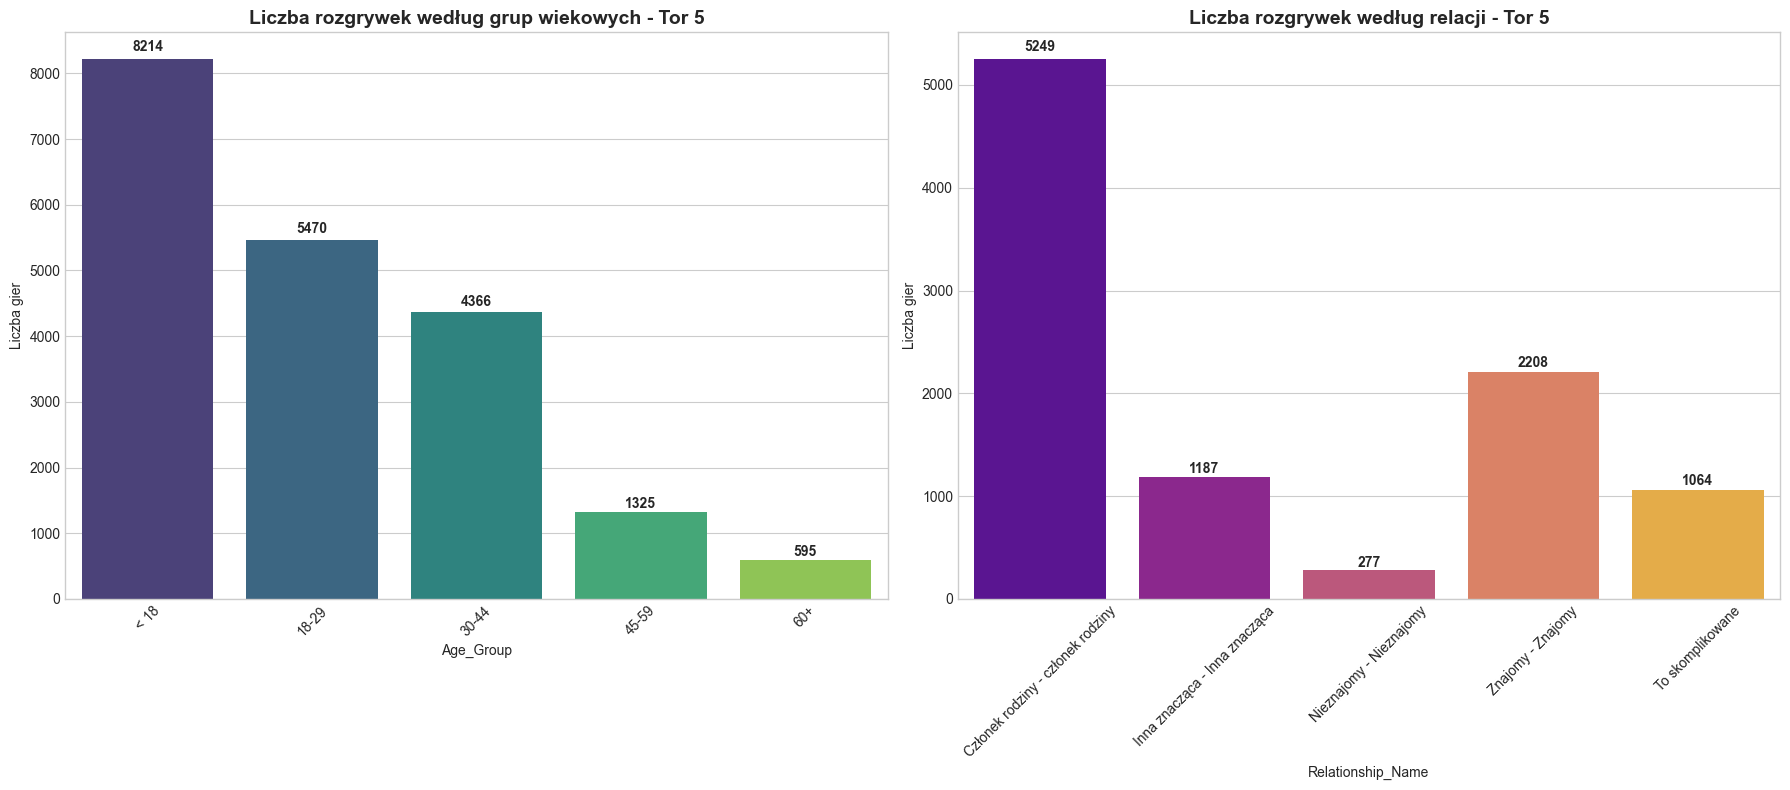


=== WYNIKI TESTÓW STATYSTYCZNYCH - TOR 5 ===

Testy dla CZASU UKOŃCZENIA według WIEKU:
18-29 vs 30-44: p=0.0000 ***
18-29 vs 45-59: p=0.0000 ***
18-29 vs 60+: p=0.0003 ***
18-29 vs < 18: p=0.0000 ***
30-44 vs 45-59: p=0.0794 ns
30-44 vs 60+: p=0.2471 ns
30-44 vs < 18: p=0.0401 *
45-59 vs 60+: p=0.0571 ns
45-59 vs < 18: p=0.6267 ns
60+ vs < 18: p=0.0505 ns

Testy dla WSKAŹNIKA UKOŃCZENIA według WIEKU:
18-29 vs 30-44: p=0.7501 ns
18-29 vs 45-59: p=0.4114 ns
18-29 vs 60+: p=0.0012 **
18-29 vs < 18: p=0.3414 ns
30-44 vs 45-59: p=0.5508 ns
30-44 vs 60+: p=0.0008 ***
30-44 vs < 18: p=0.2183 ns
45-59 vs 60+: p=0.0009 ***
45-59 vs < 18: p=0.1592 ns
60+ vs < 18: p=0.0039 **

Testy dla CZASU UKOŃCZENIA według RELACJI:
Członek rodziny - członek rodziny vs Inna znacząca - Inna znacząca: p=0.0000 ***
Członek rodziny - członek rodziny vs Nieznajomy - Nieznajomy: p=0.0701 ns
Członek rodziny - członek rodziny vs To skomplikowane: p=0.0000 ***
Członek rodziny - członek rodziny vs Znajomy - Znajomy: p=

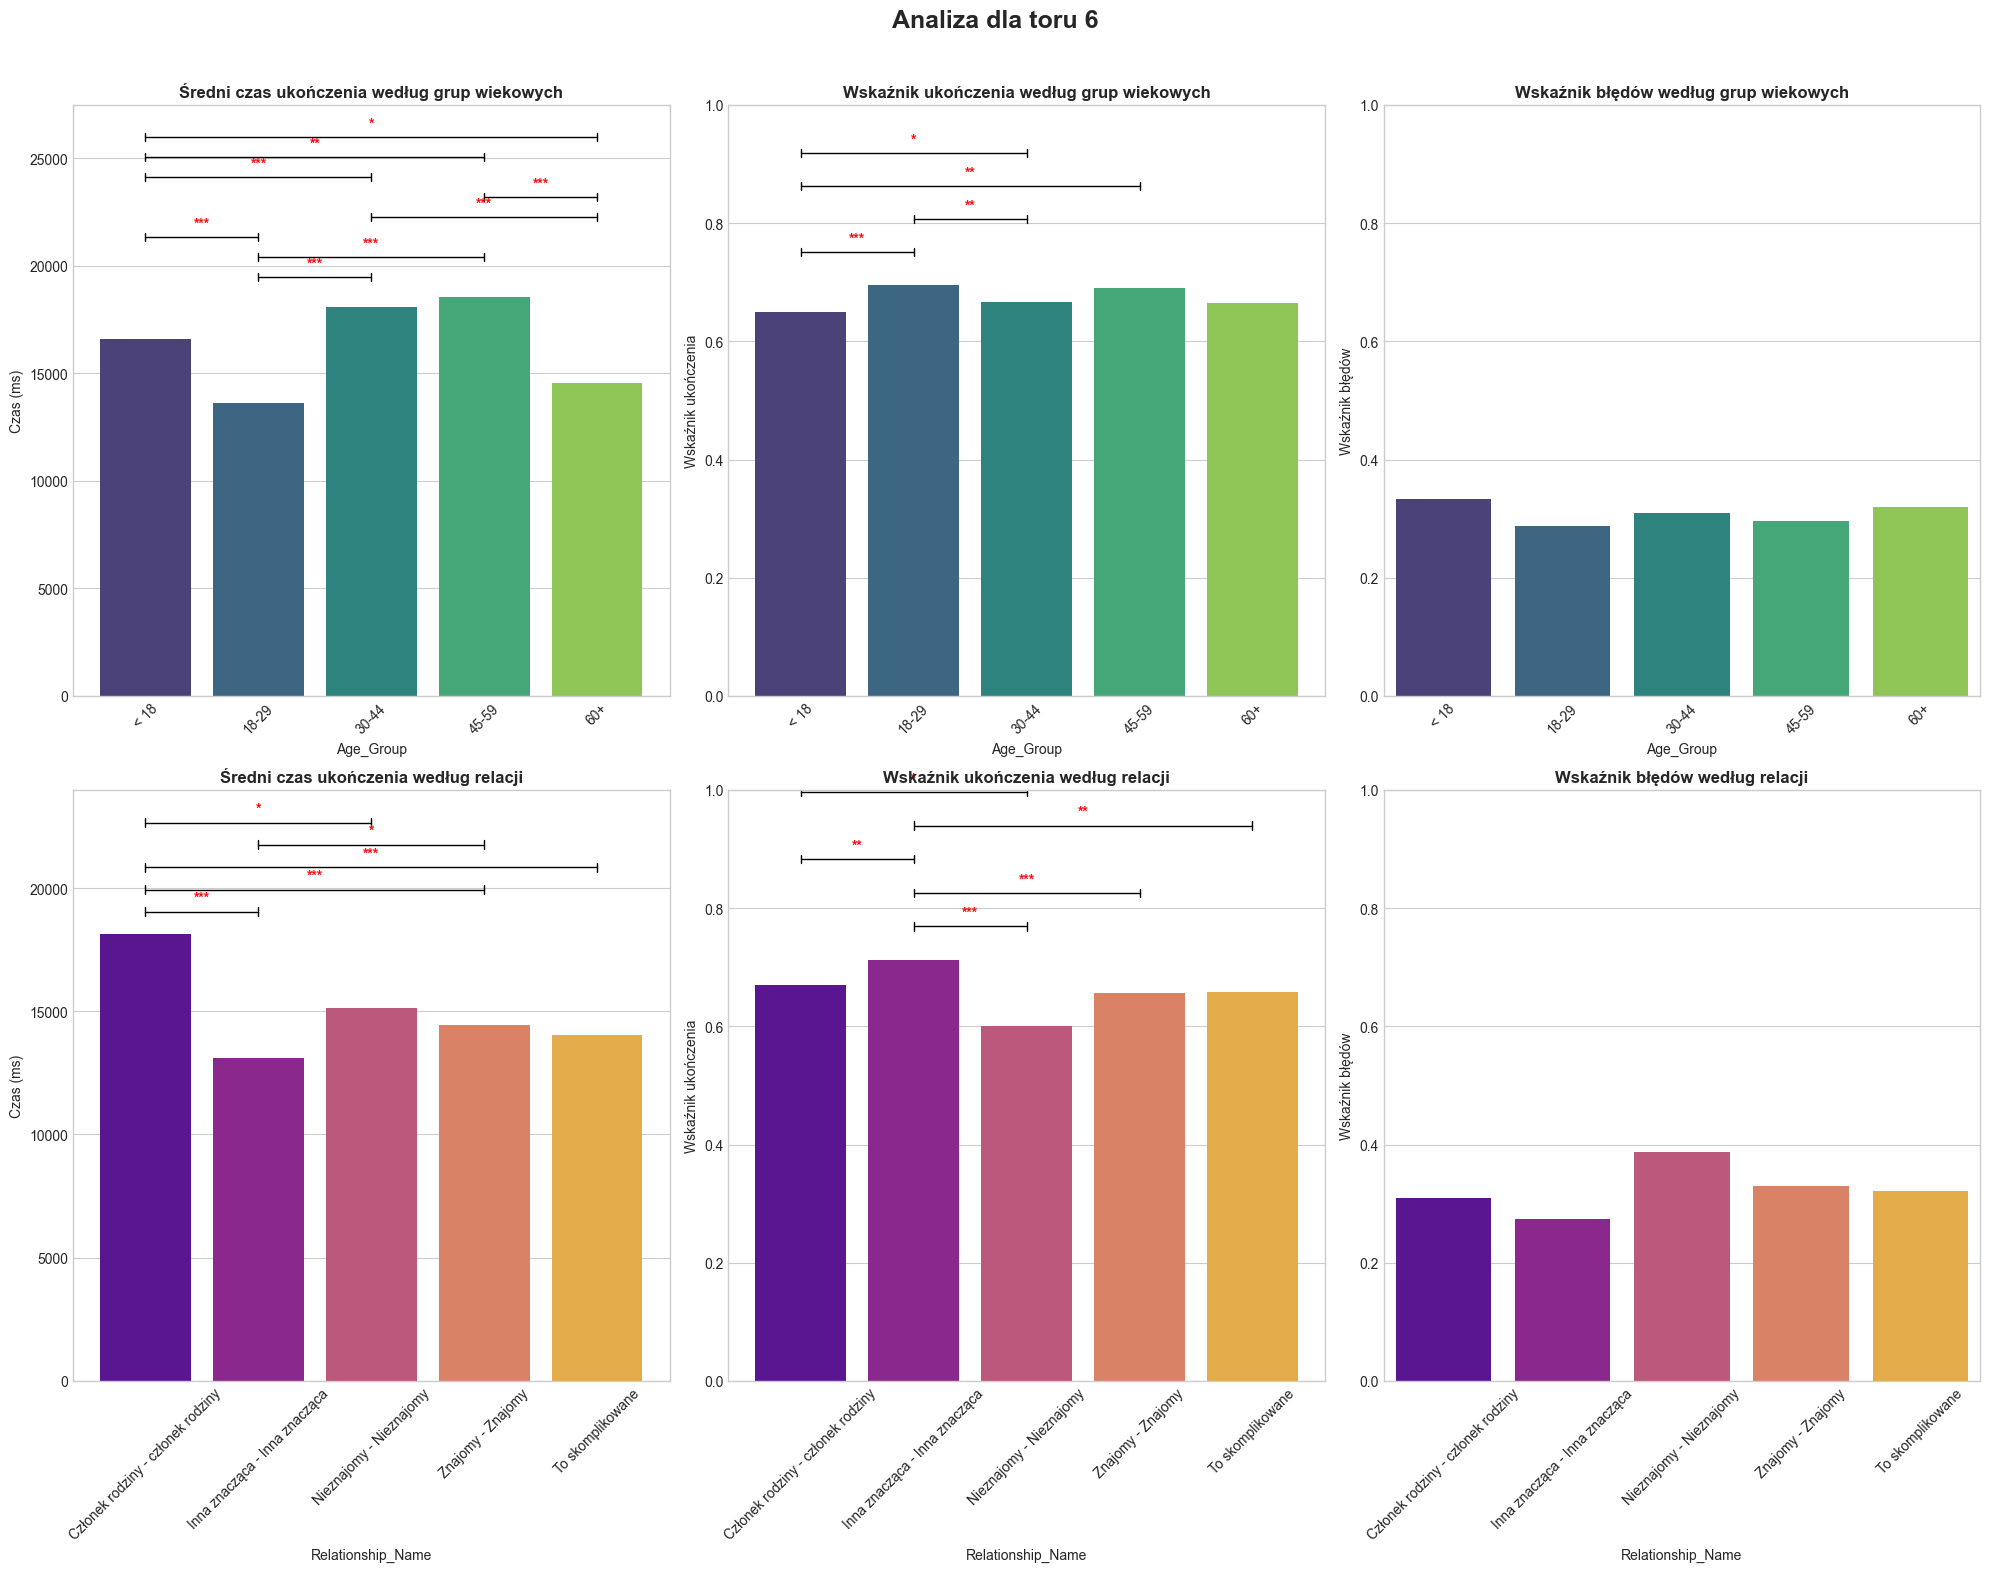

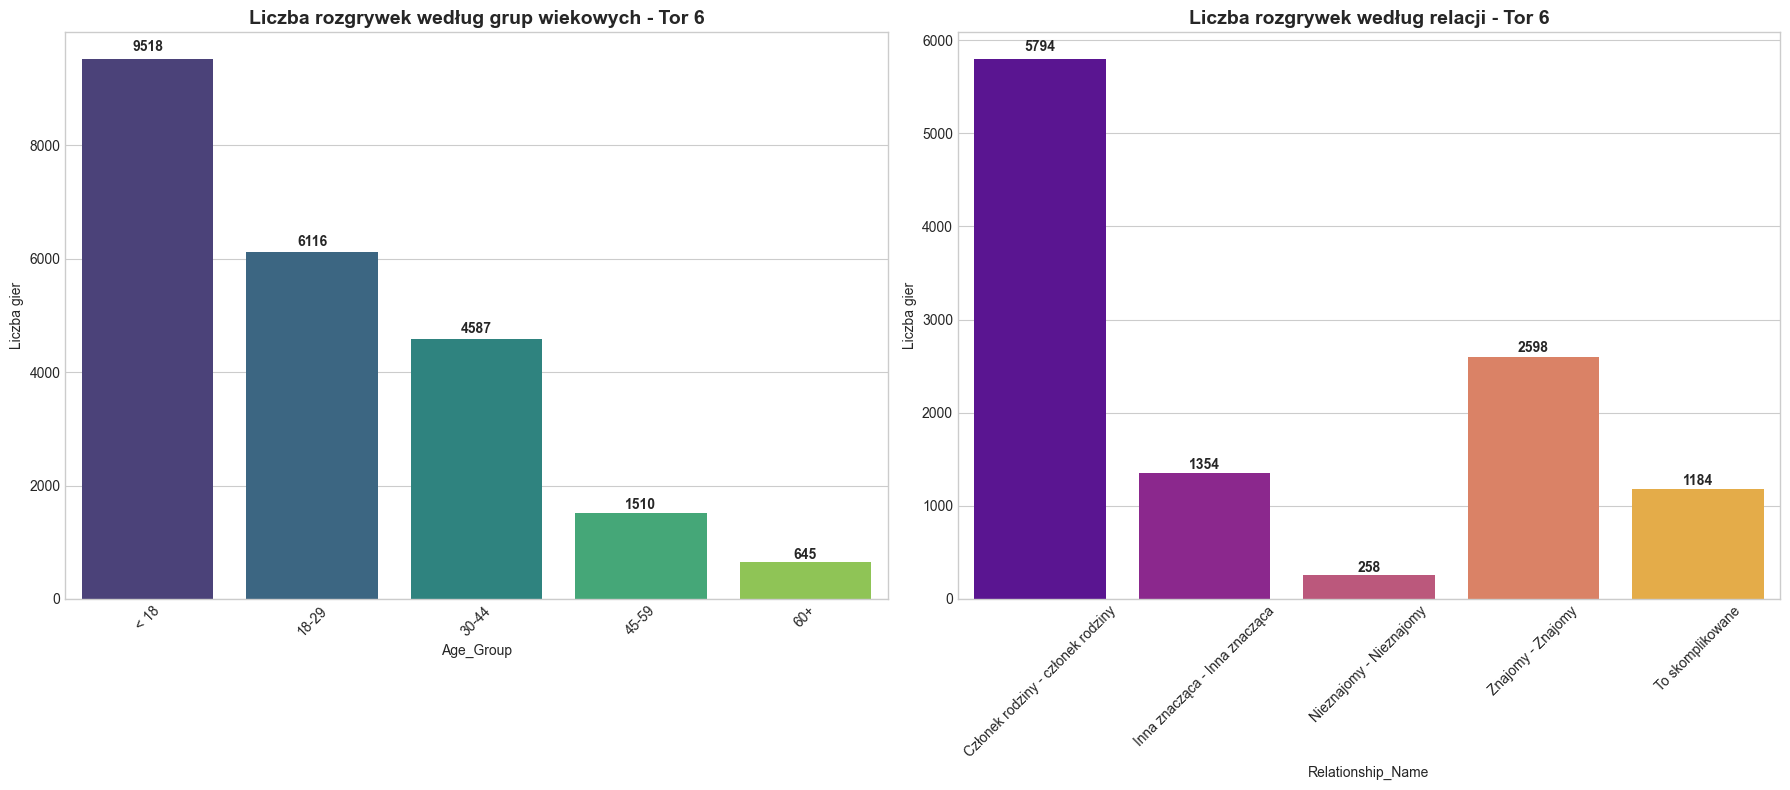


=== WYNIKI TESTÓW STATYSTYCZNYCH - TOR 6 ===

Testy dla CZASU UKOŃCZENIA według WIEKU:
18-29 vs 30-44: p=0.0000 ***
18-29 vs 45-59: p=0.0000 ***
18-29 vs 60+: p=0.2129 ns
18-29 vs < 18: p=0.0000 ***
30-44 vs 45-59: p=0.4742 ns
30-44 vs 60+: p=0.0001 ***
30-44 vs < 18: p=0.0002 ***
45-59 vs 60+: p=0.0001 ***
45-59 vs < 18: p=0.0014 **
60+ vs < 18: p=0.0209 *

Testy dla WSKAŹNIKA UKOŃCZENIA według WIEKU:
18-29 vs 30-44: p=0.0016 **
18-29 vs 45-59: p=0.6695 ns
18-29 vs 60+: p=0.1091 ns
18-29 vs < 18: p=0.0000 ***
30-44 vs 45-59: p=0.0991 ns
30-44 vs 60+: p=0.9202 ns
30-44 vs < 18: p=0.0443 *
45-59 vs 60+: p=0.2547 ns
45-59 vs < 18: p=0.0023 **
60+ vs < 18: p=0.4336 ns

Testy dla CZASU UKOŃCZENIA według RELACJI:
Członek rodziny - członek rodziny vs Inna znacząca - Inna znacząca: p=0.0000 ***
Członek rodziny - członek rodziny vs Nieznajomy - Nieznajomy: p=0.0459 *
Członek rodziny - członek rodziny vs To skomplikowane: p=0.0000 ***
Członek rodziny - członek rodziny vs Znajomy - Znajomy: p=0

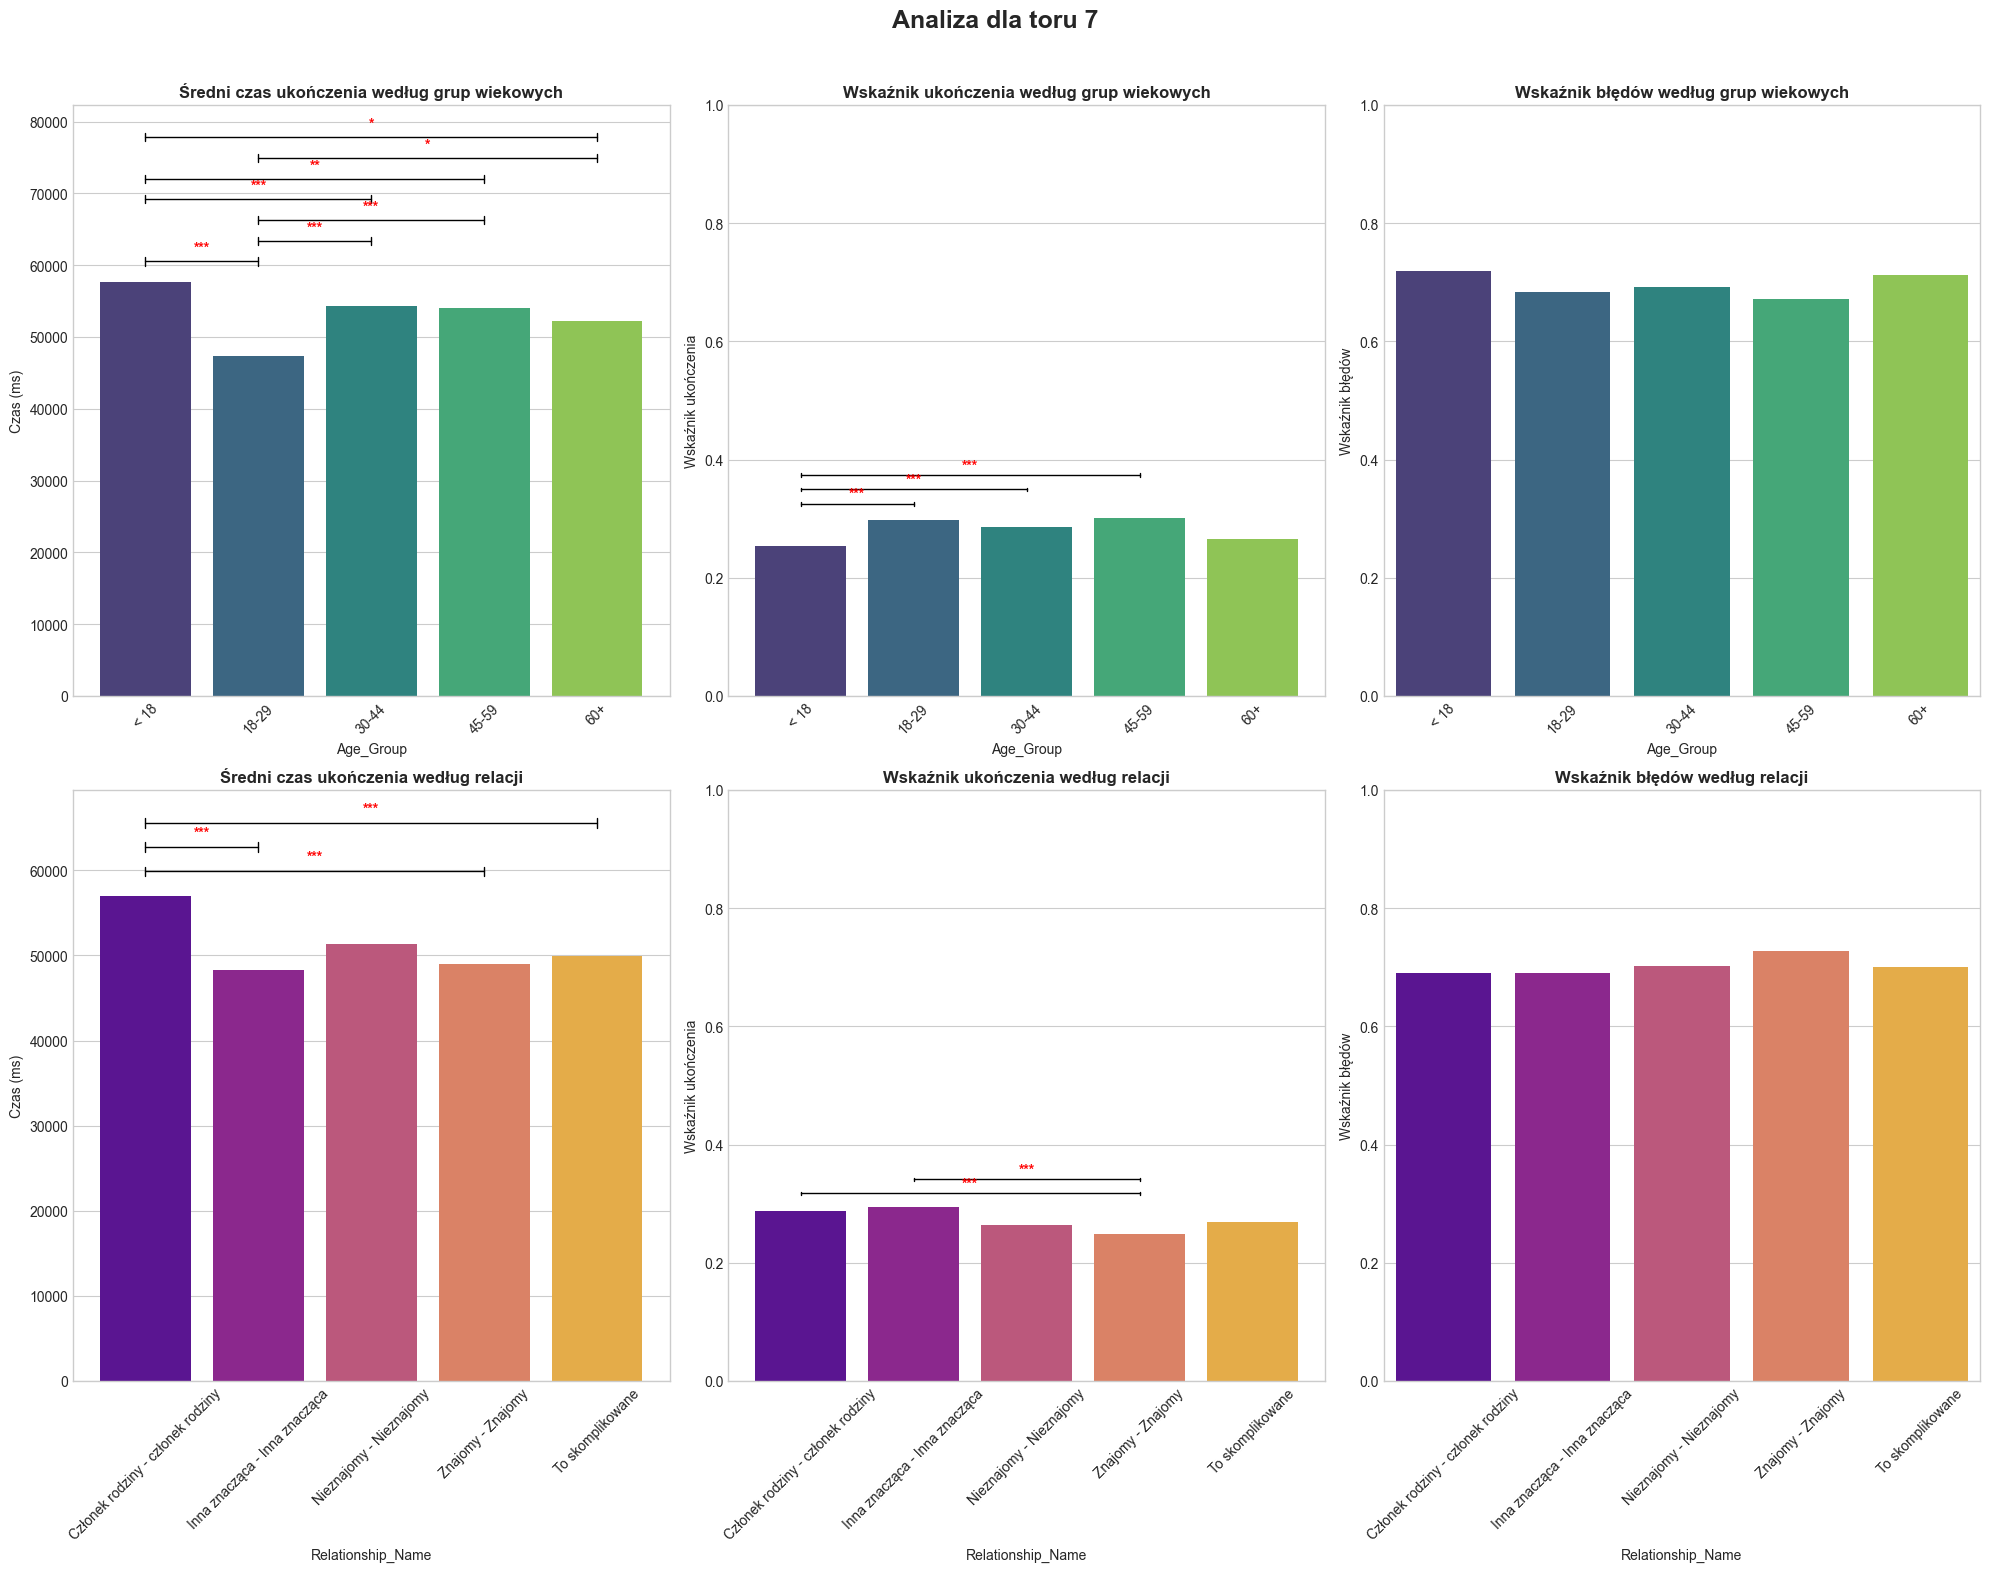

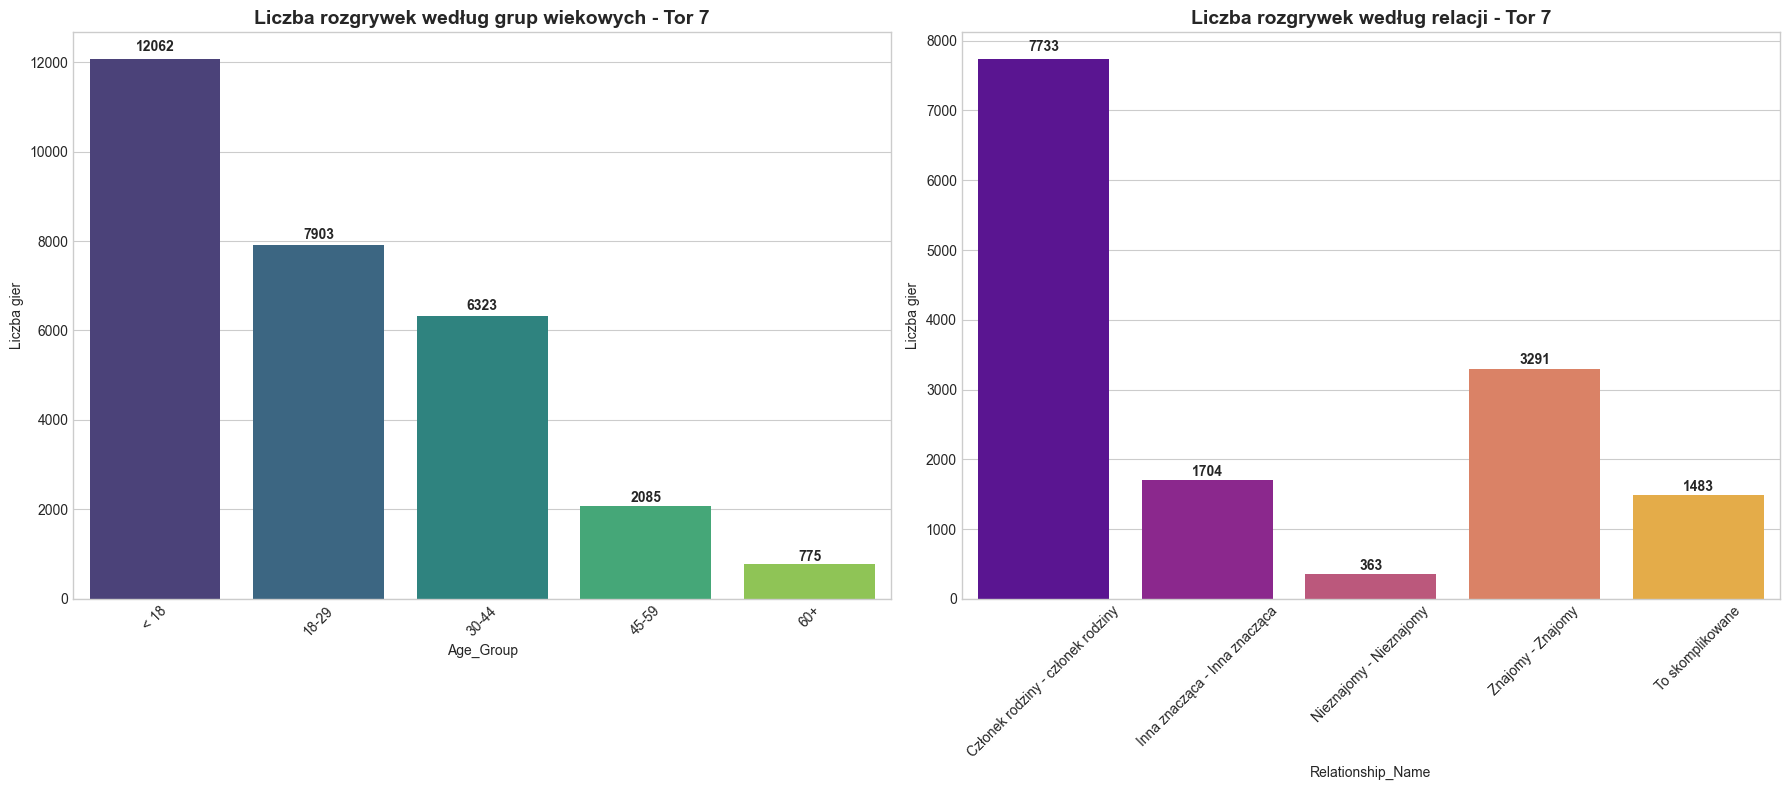


=== WYNIKI TESTÓW STATYSTYCZNYCH - TOR 7 ===

Testy dla CZASU UKOŃCZENIA według WIEKU:
18-29 vs 30-44: p=0.0000 ***
18-29 vs 45-59: p=0.0000 ***
18-29 vs 60+: p=0.0107 *
18-29 vs < 18: p=0.0000 ***
30-44 vs 45-59: p=0.7969 ns
30-44 vs 60+: p=0.3154 ns
30-44 vs < 18: p=0.0001 ***
45-59 vs 60+: p=0.4864 ns
45-59 vs < 18: p=0.0049 **
60+ vs < 18: p=0.0123 *

Testy dla WSKAŹNIKA UKOŃCZENIA według WIEKU:
18-29 vs 30-44: p=0.1225 ns
18-29 vs 45-59: p=0.7843 ns
18-29 vs 60+: p=0.0599 ns
18-29 vs < 18: p=0.0000 ***
30-44 vs 45-59: p=0.1923 ns
30-44 vs 60+: p=0.2335 ns
30-44 vs < 18: p=0.0000 ***
45-59 vs 60+: p=0.0642 ns
45-59 vs < 18: p=0.0000 ***
60+ vs < 18: p=0.4655 ns

Testy dla CZASU UKOŃCZENIA według RELACJI:
Członek rodziny - członek rodziny vs Inna znacząca - Inna znacząca: p=0.0000 ***
Członek rodziny - członek rodziny vs Nieznajomy - Nieznajomy: p=0.0551 ns
Członek rodziny - członek rodziny vs To skomplikowane: p=0.0000 ***
Członek rodziny - członek rodziny vs Znajomy - Znajomy: p=

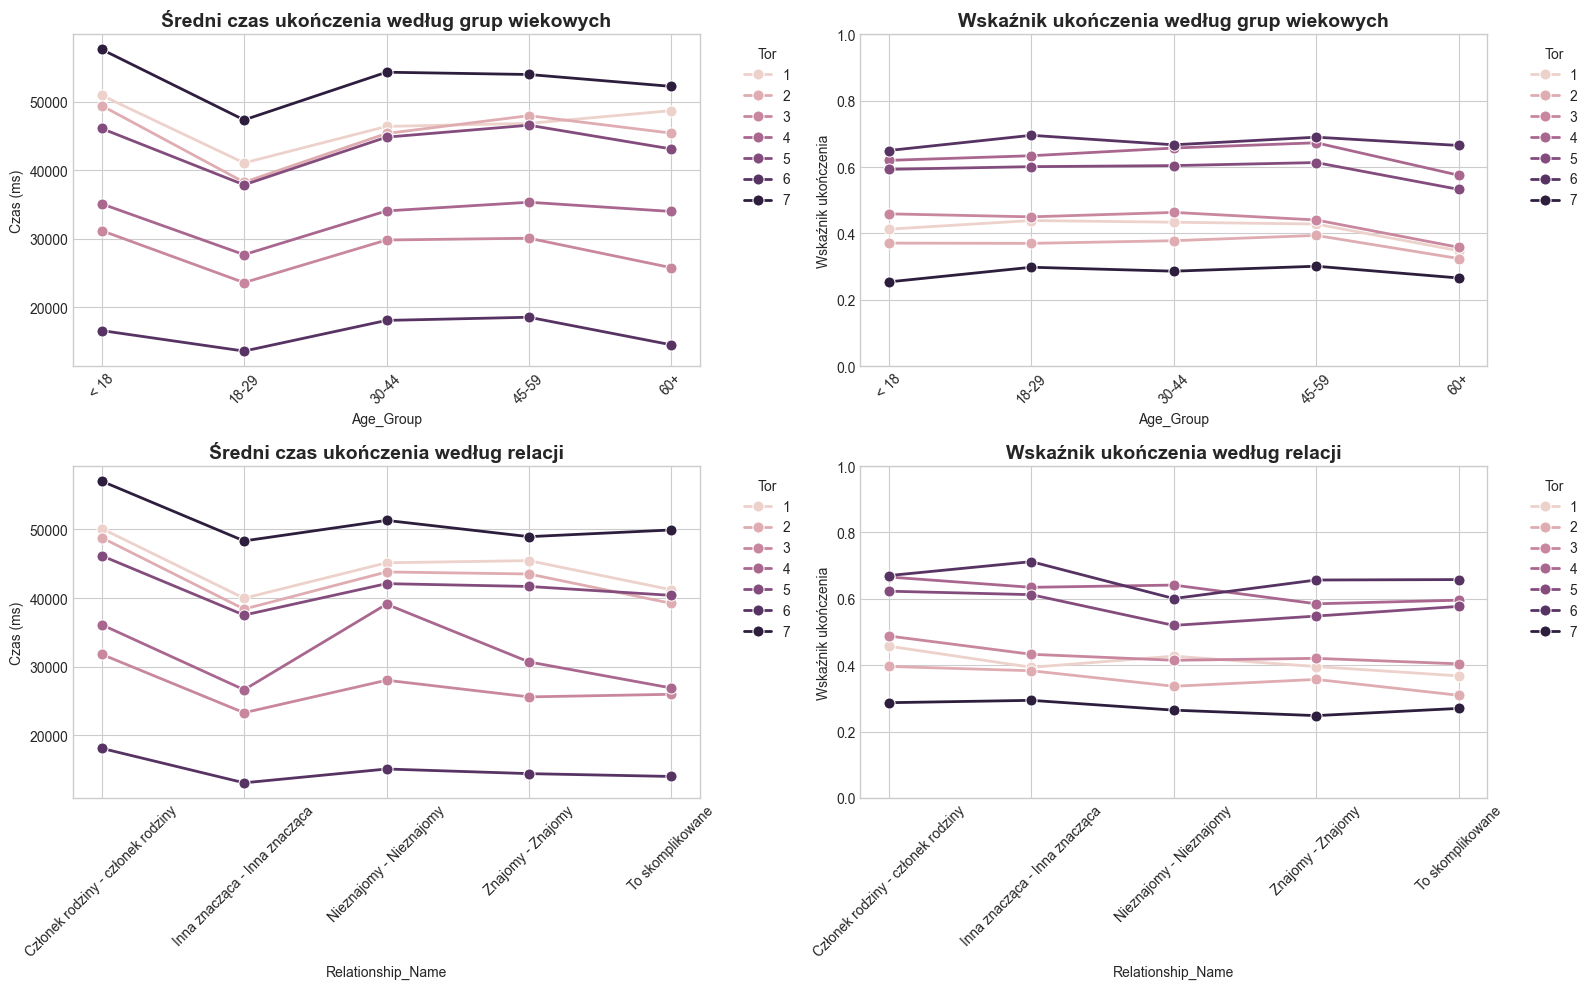


=== TABELA GRUP WIEKOWYCH - WSZYSTKIE TORY ===
 Tor Grupa_wiekowa  Licznosc  Sredni_czas_ms  Odch_standardowe  Blad_standardowy  Wskaznik_ukonczenia  Wskaznik_bledow
   1         18-29      7374    41076.322002      27898.361784        490.427083             0.438839         0.555330
   1         30-44      6673    46403.509499      30488.329561        566.642763             0.433838         0.560318
   1         45-59      2155    46847.809317      31408.873067       1033.835650             0.428306         0.565197
   1           60+       799    48702.575540      35237.189647       2113.386193             0.347935         0.640801
   1          < 18     11735    50930.649608      34904.241682        501.402508             0.412953         0.578611
   2         18-29      8944    38262.584290      22958.951155        399.059861             0.370081         0.625447
   2         30-44      7918    45371.960922      27852.584209        509.025569             0.378126         0.615559


In [5]:
main()

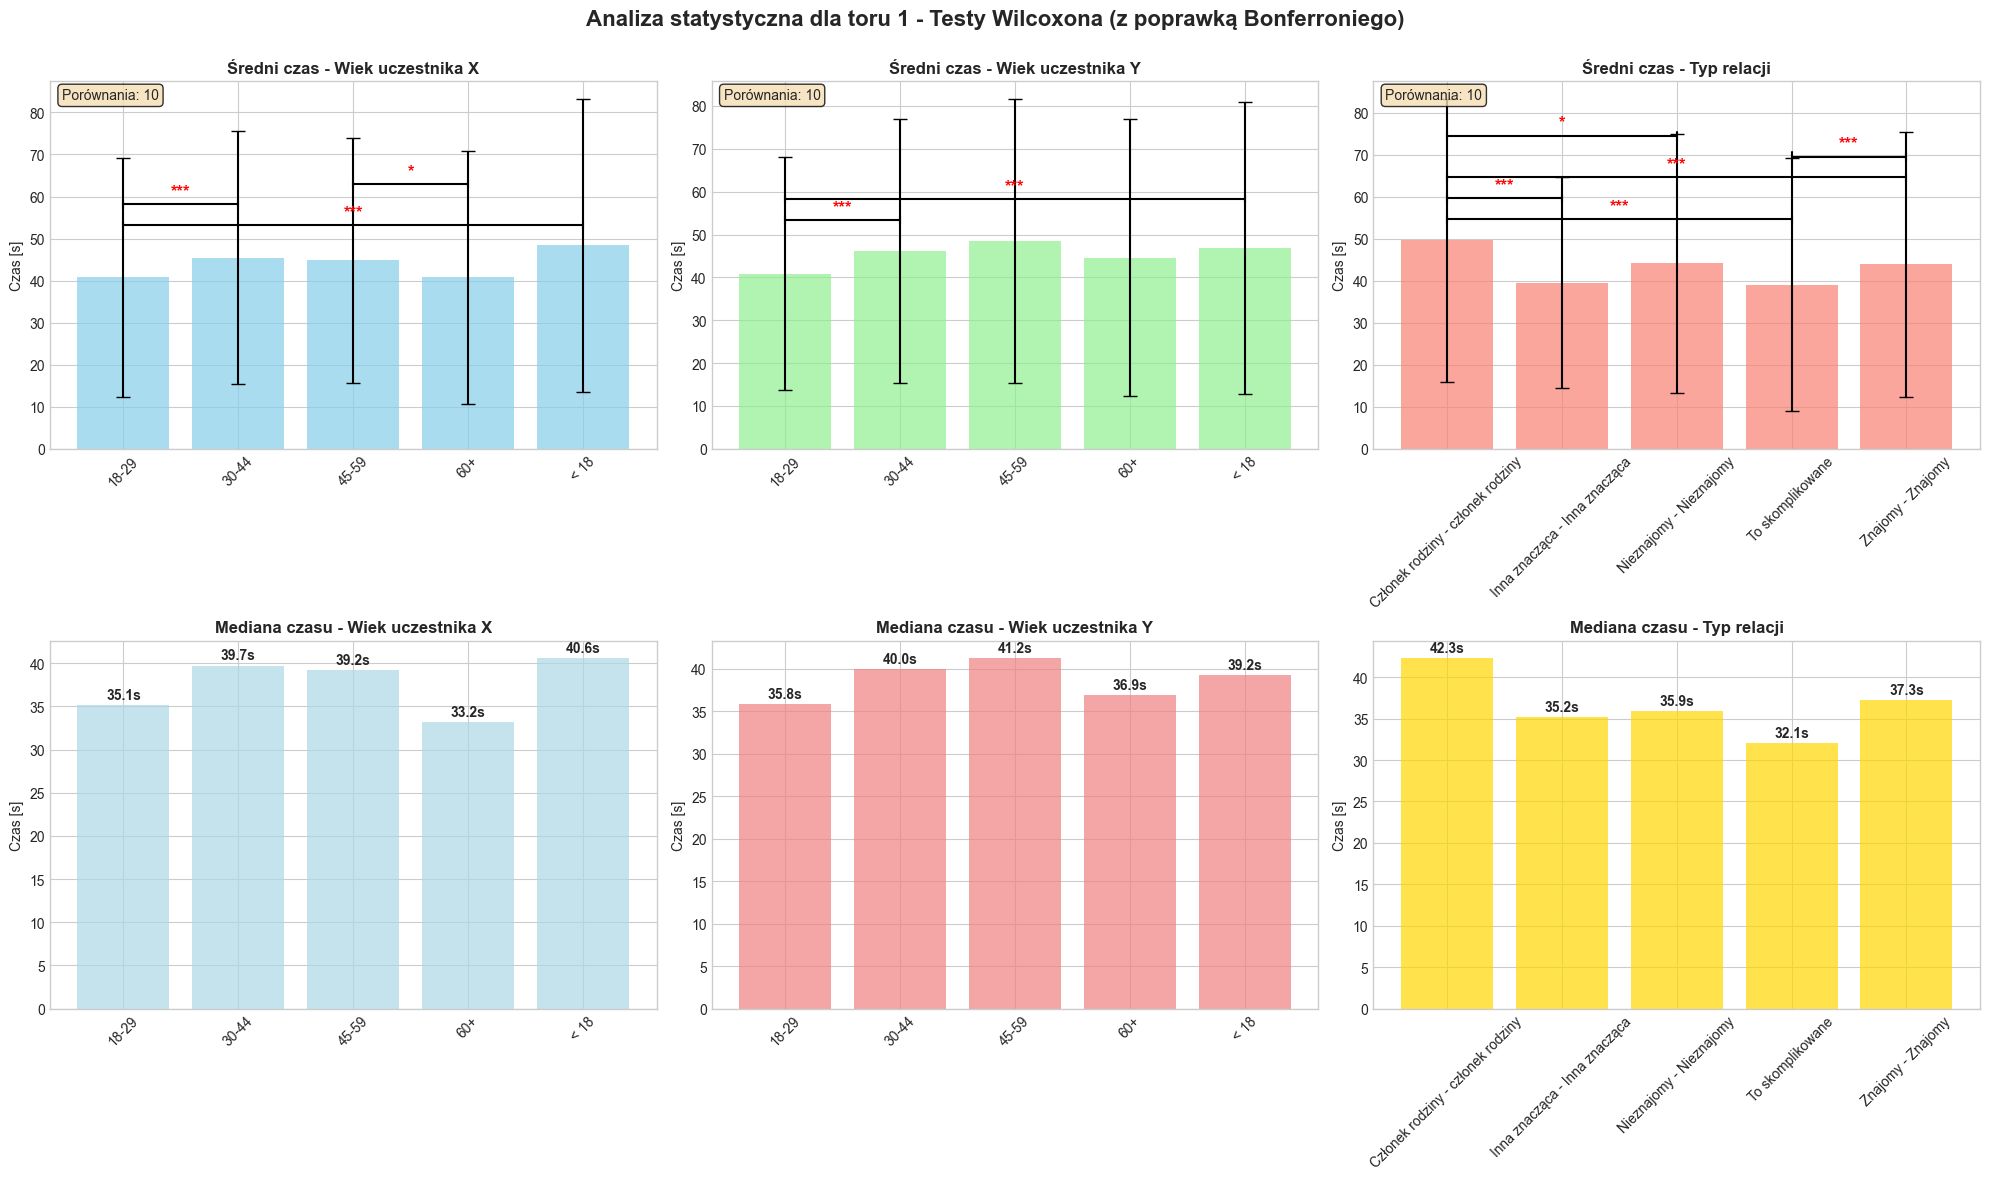

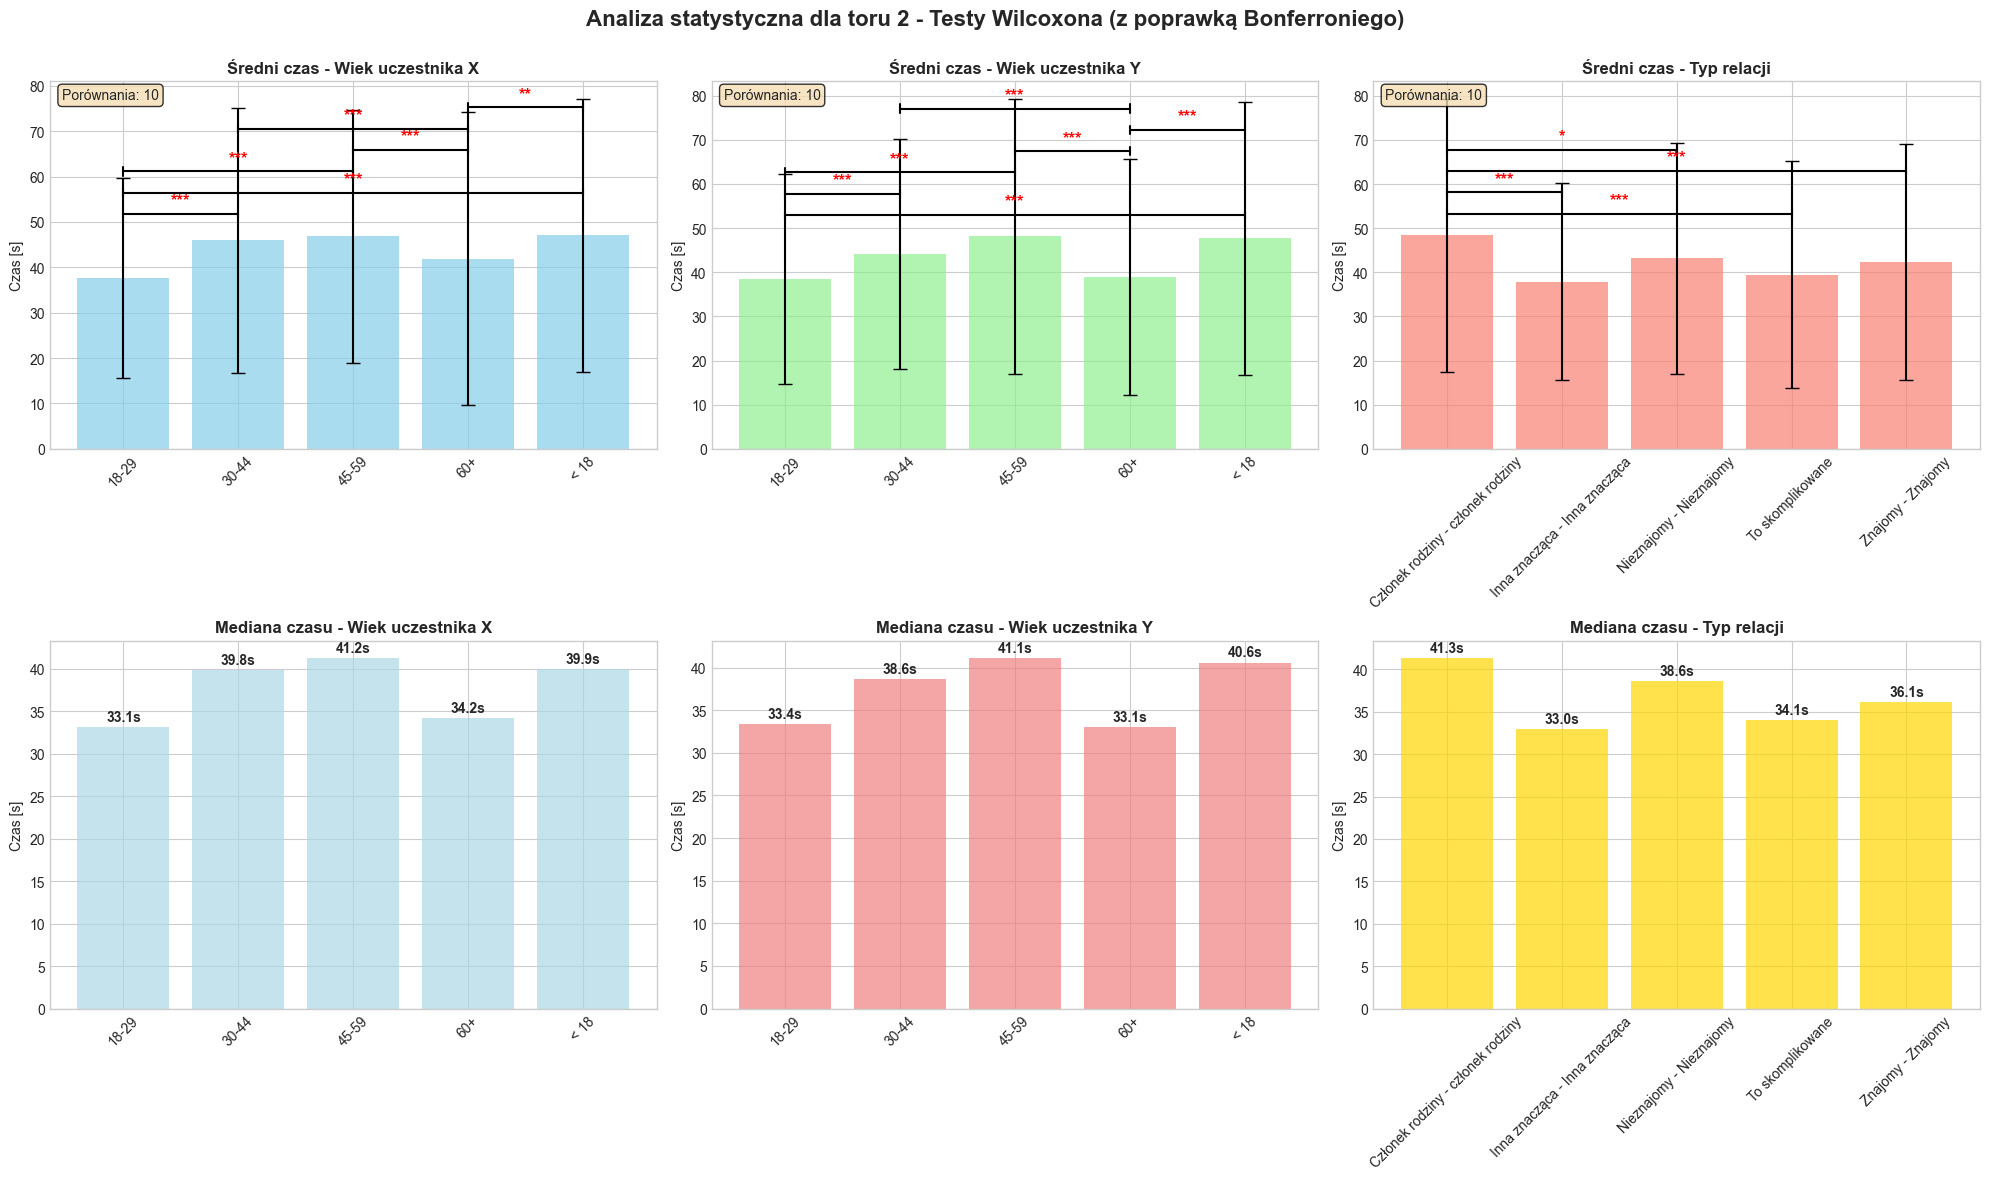

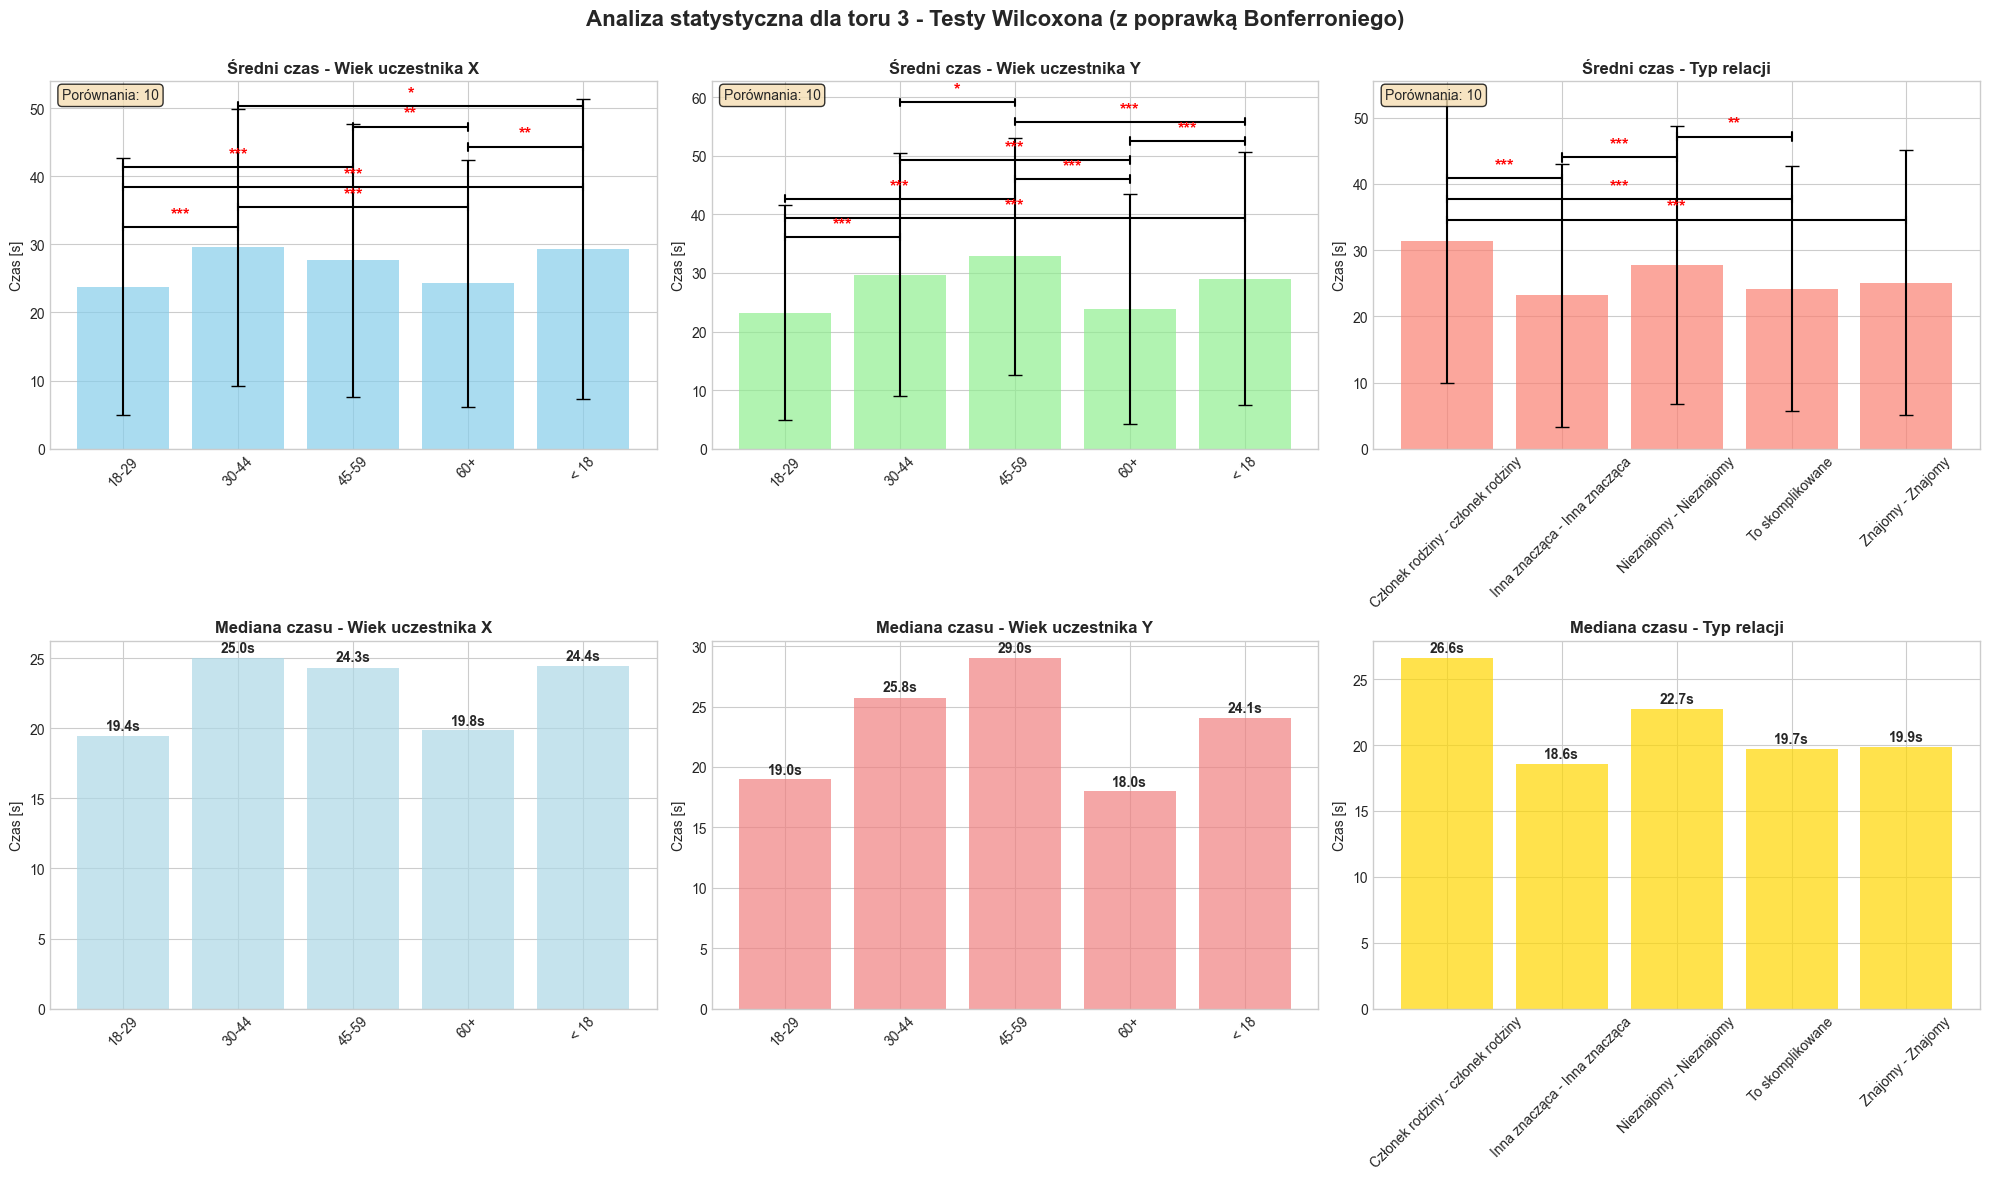

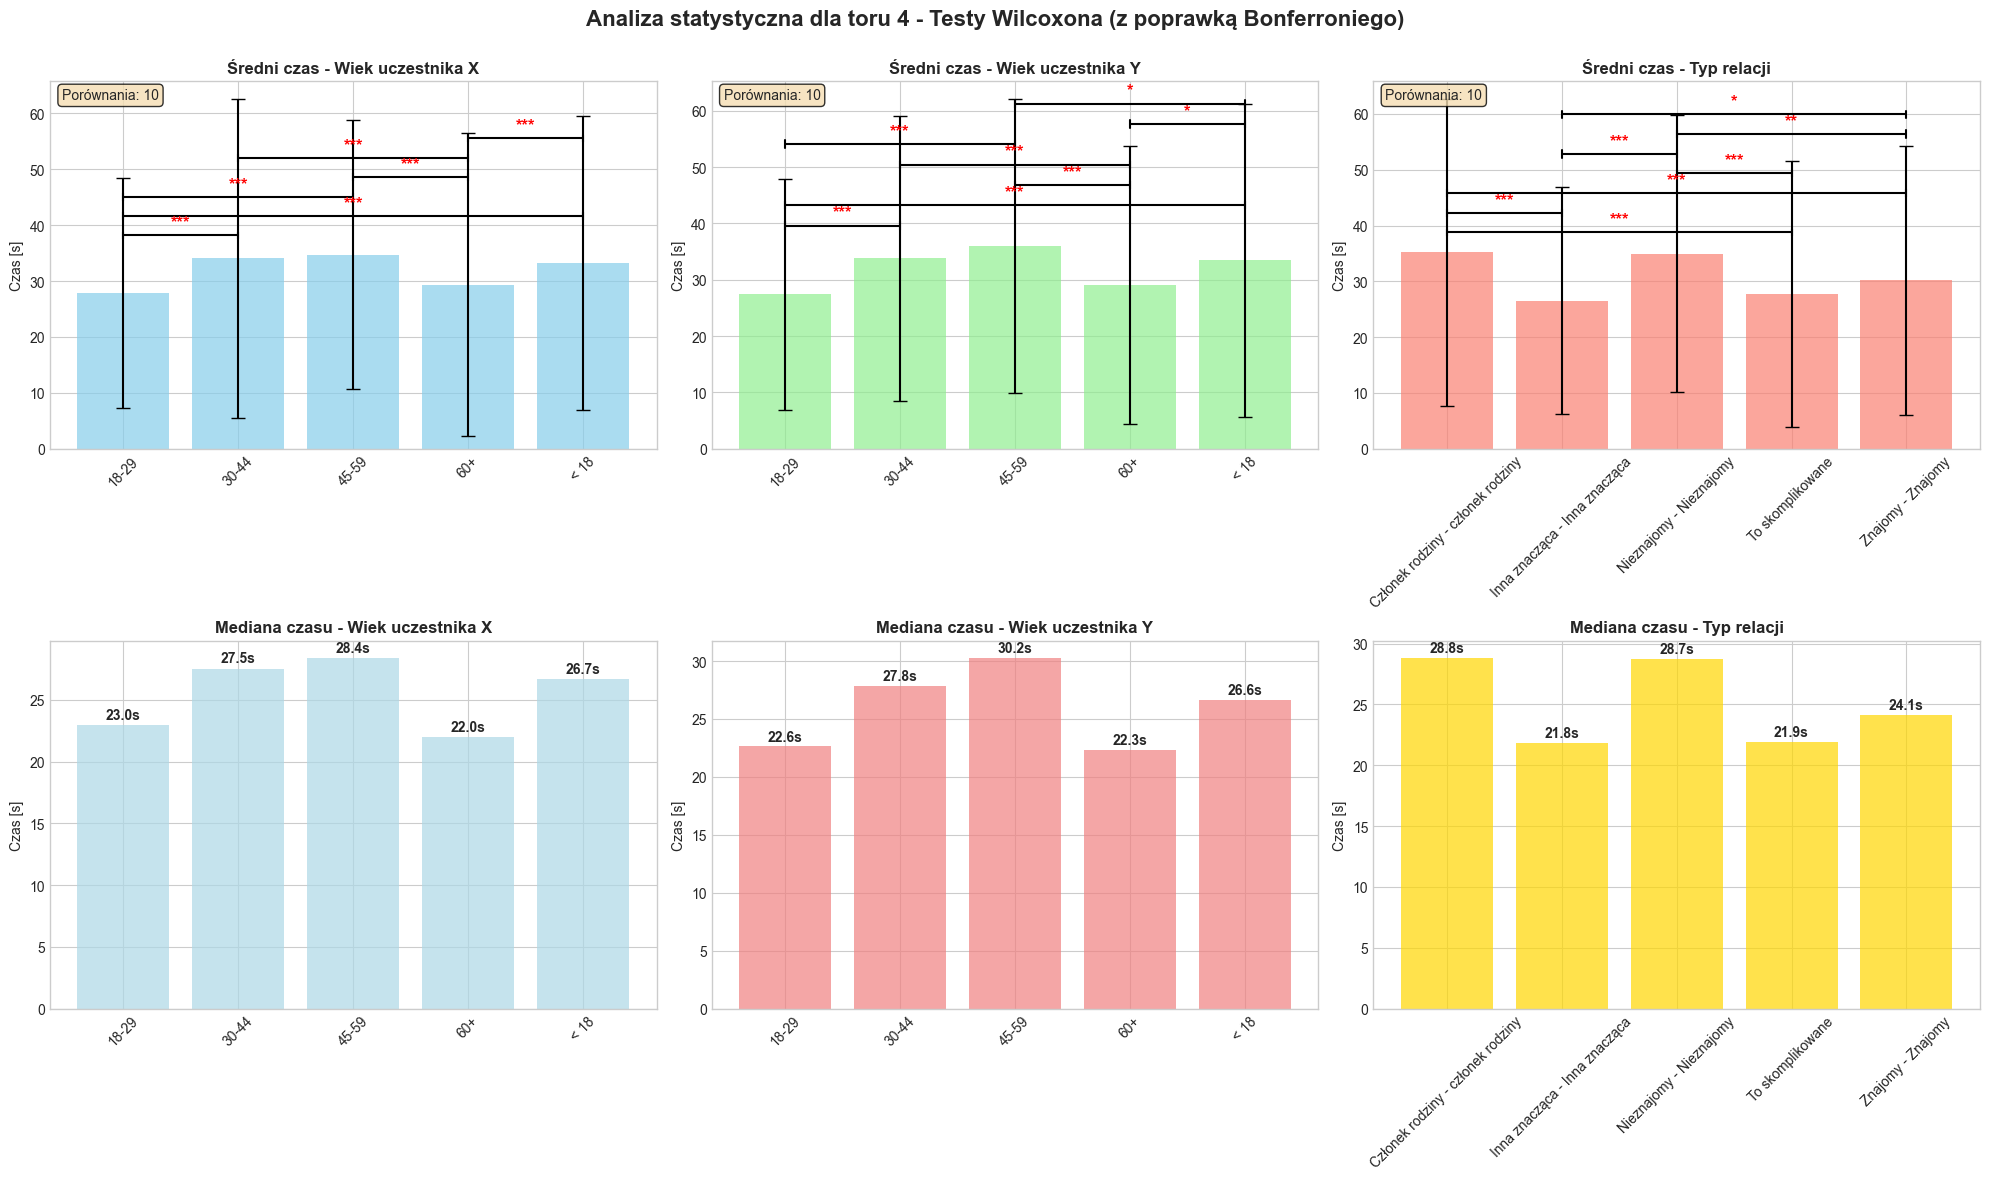

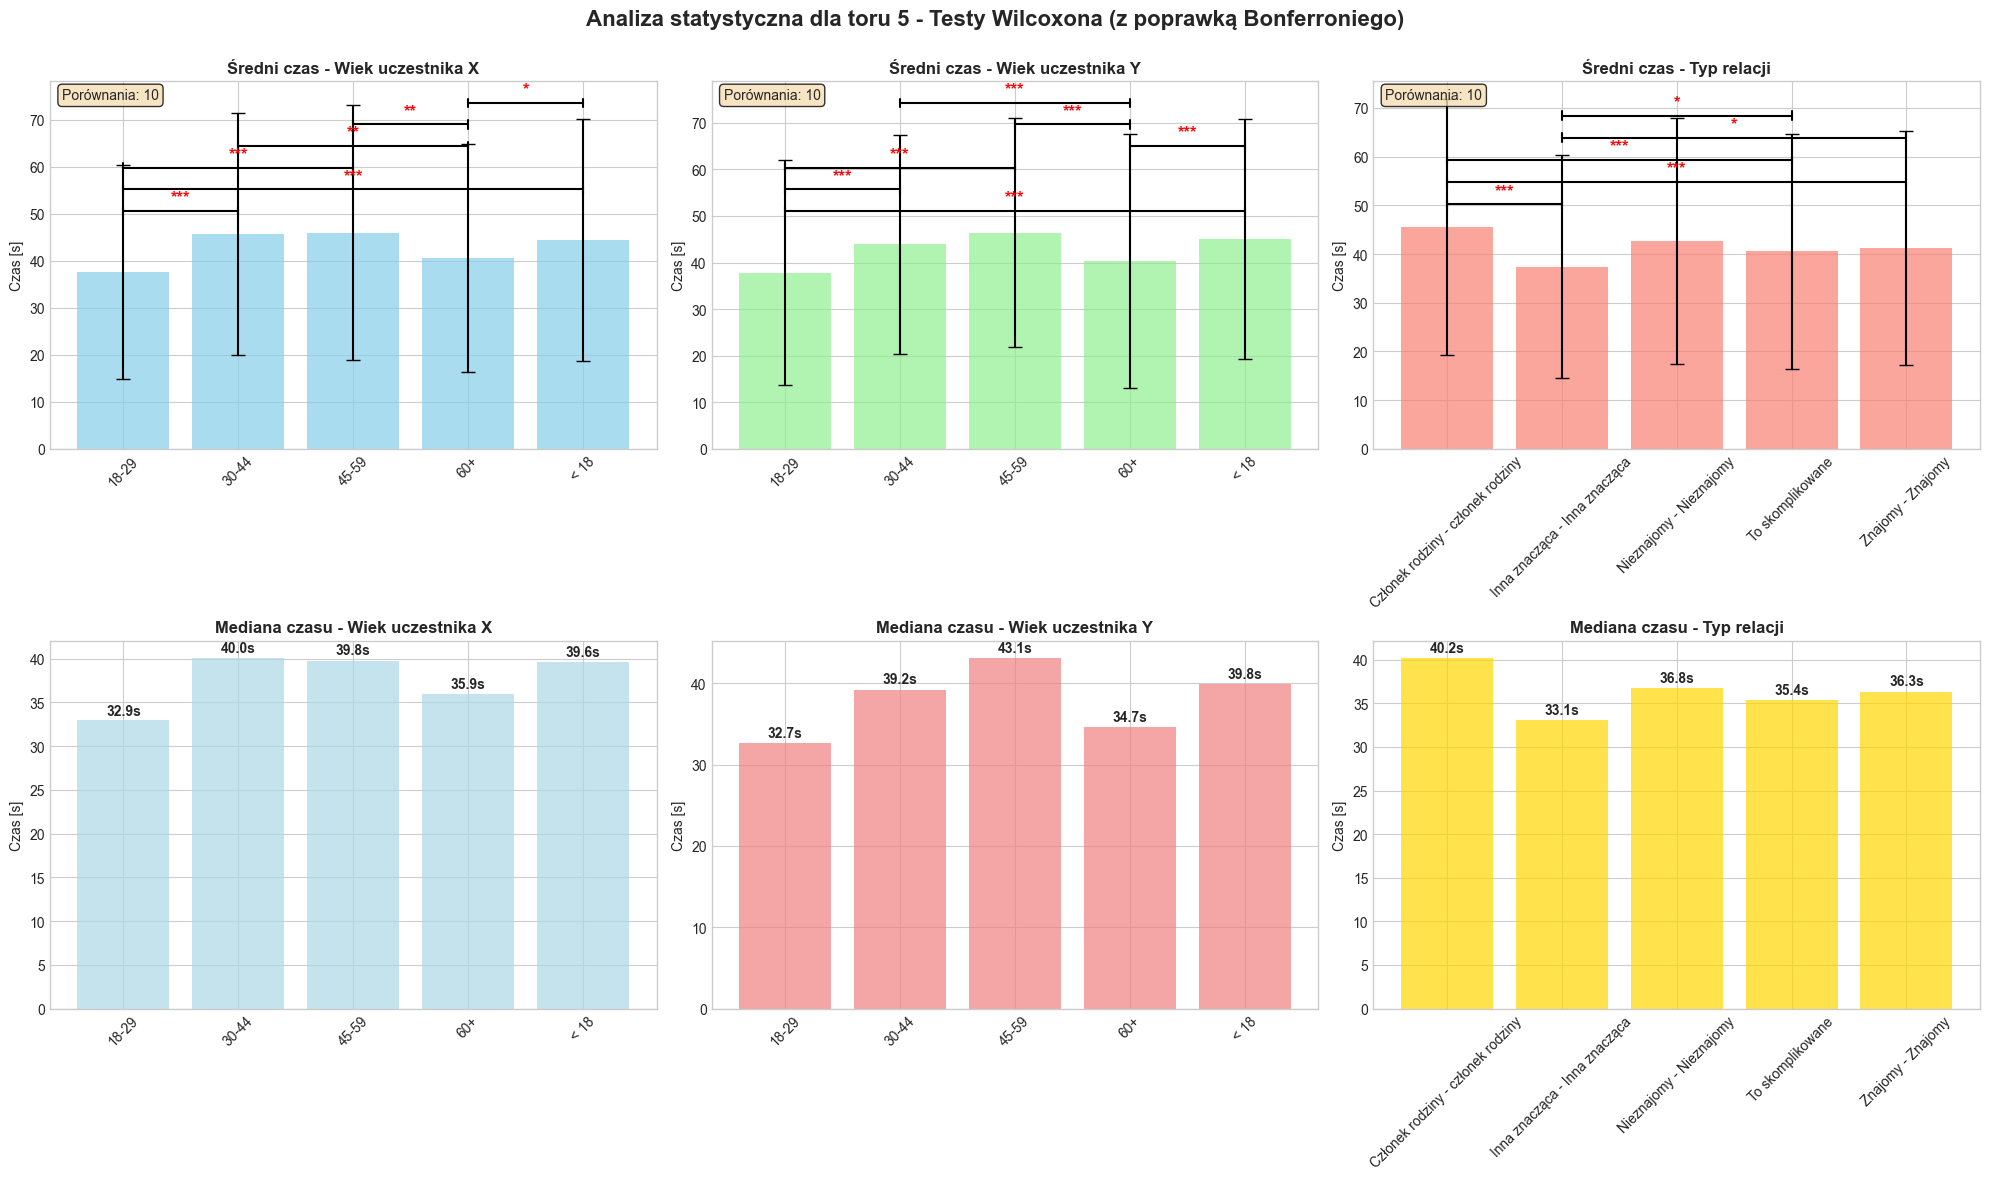

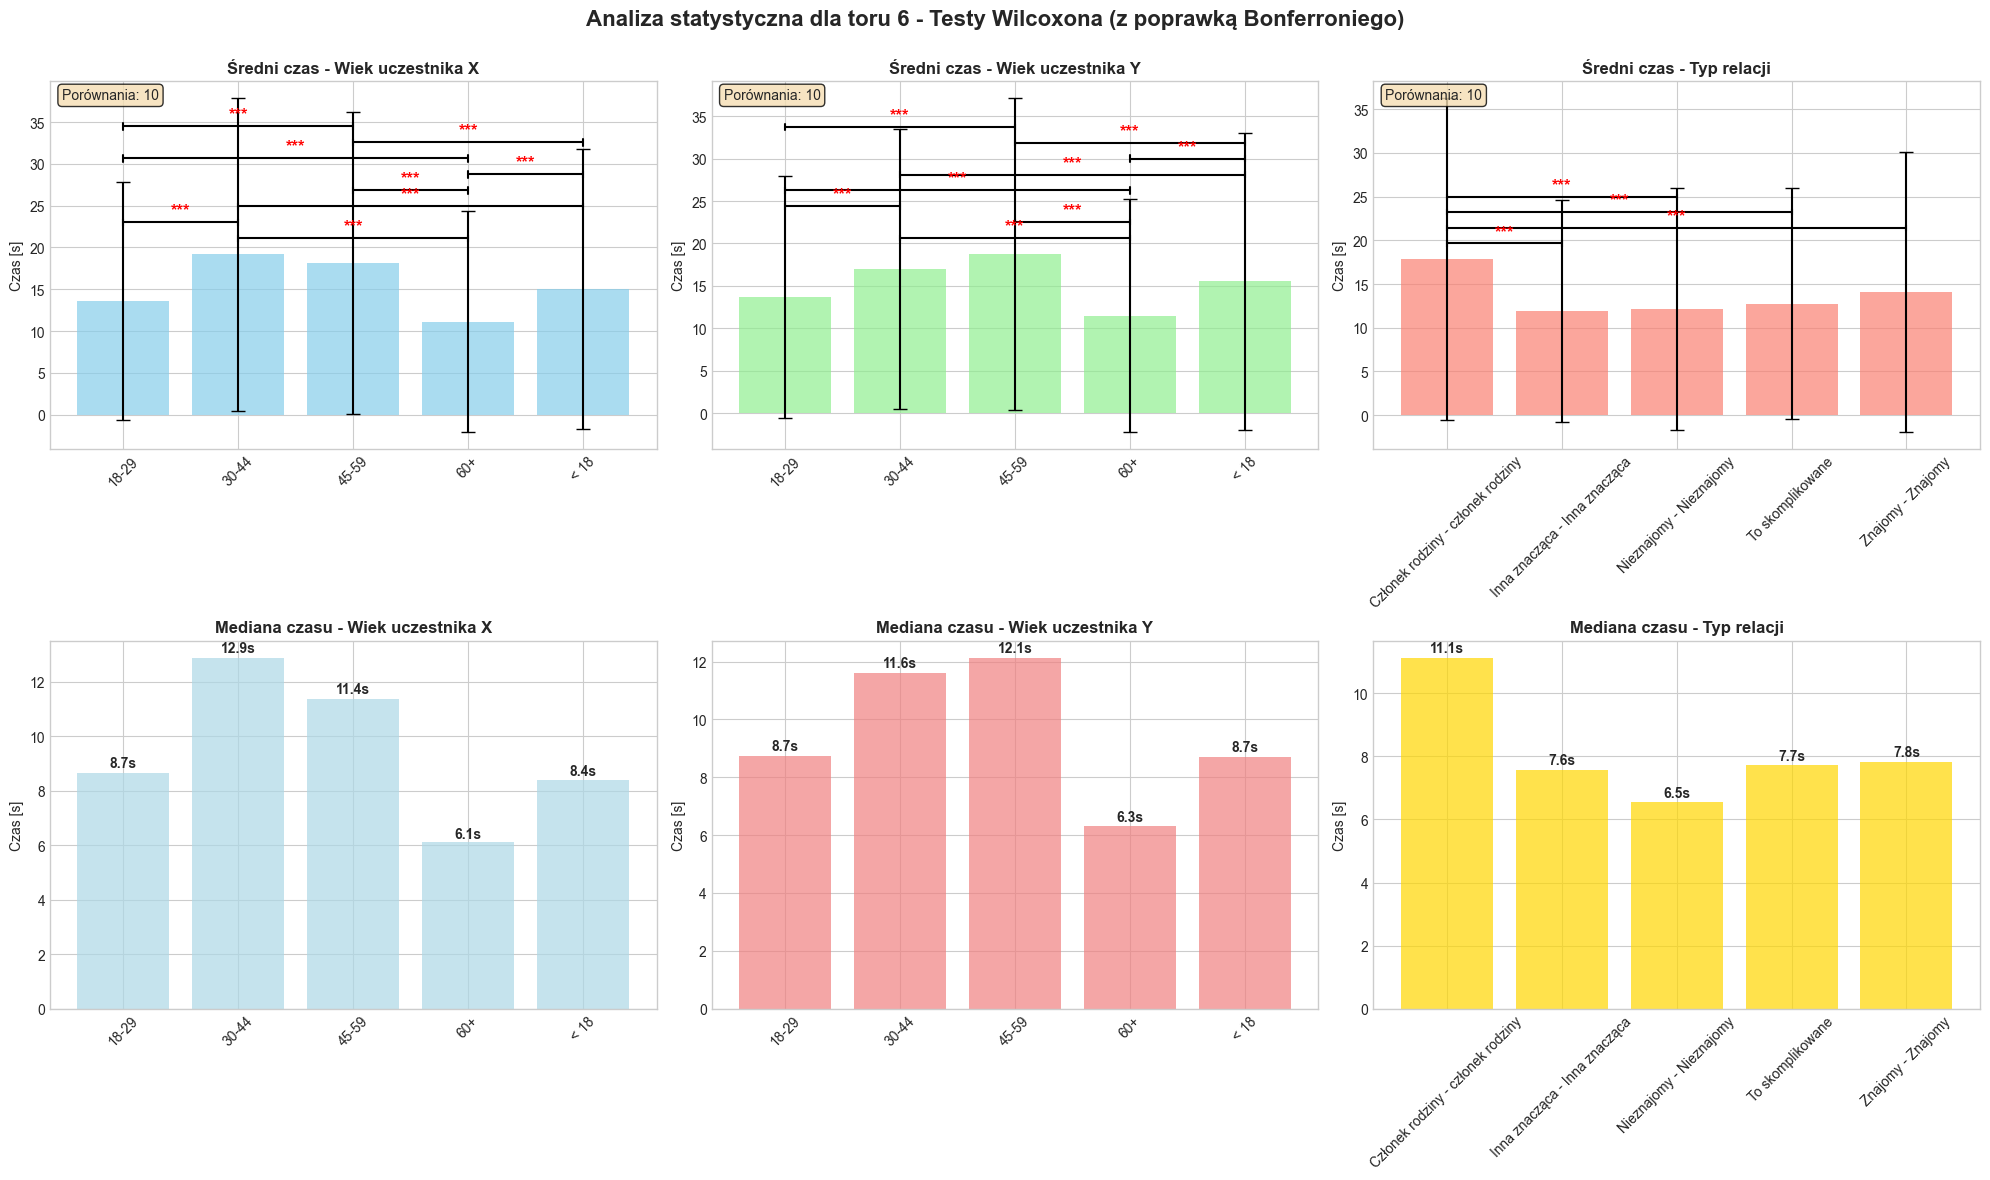

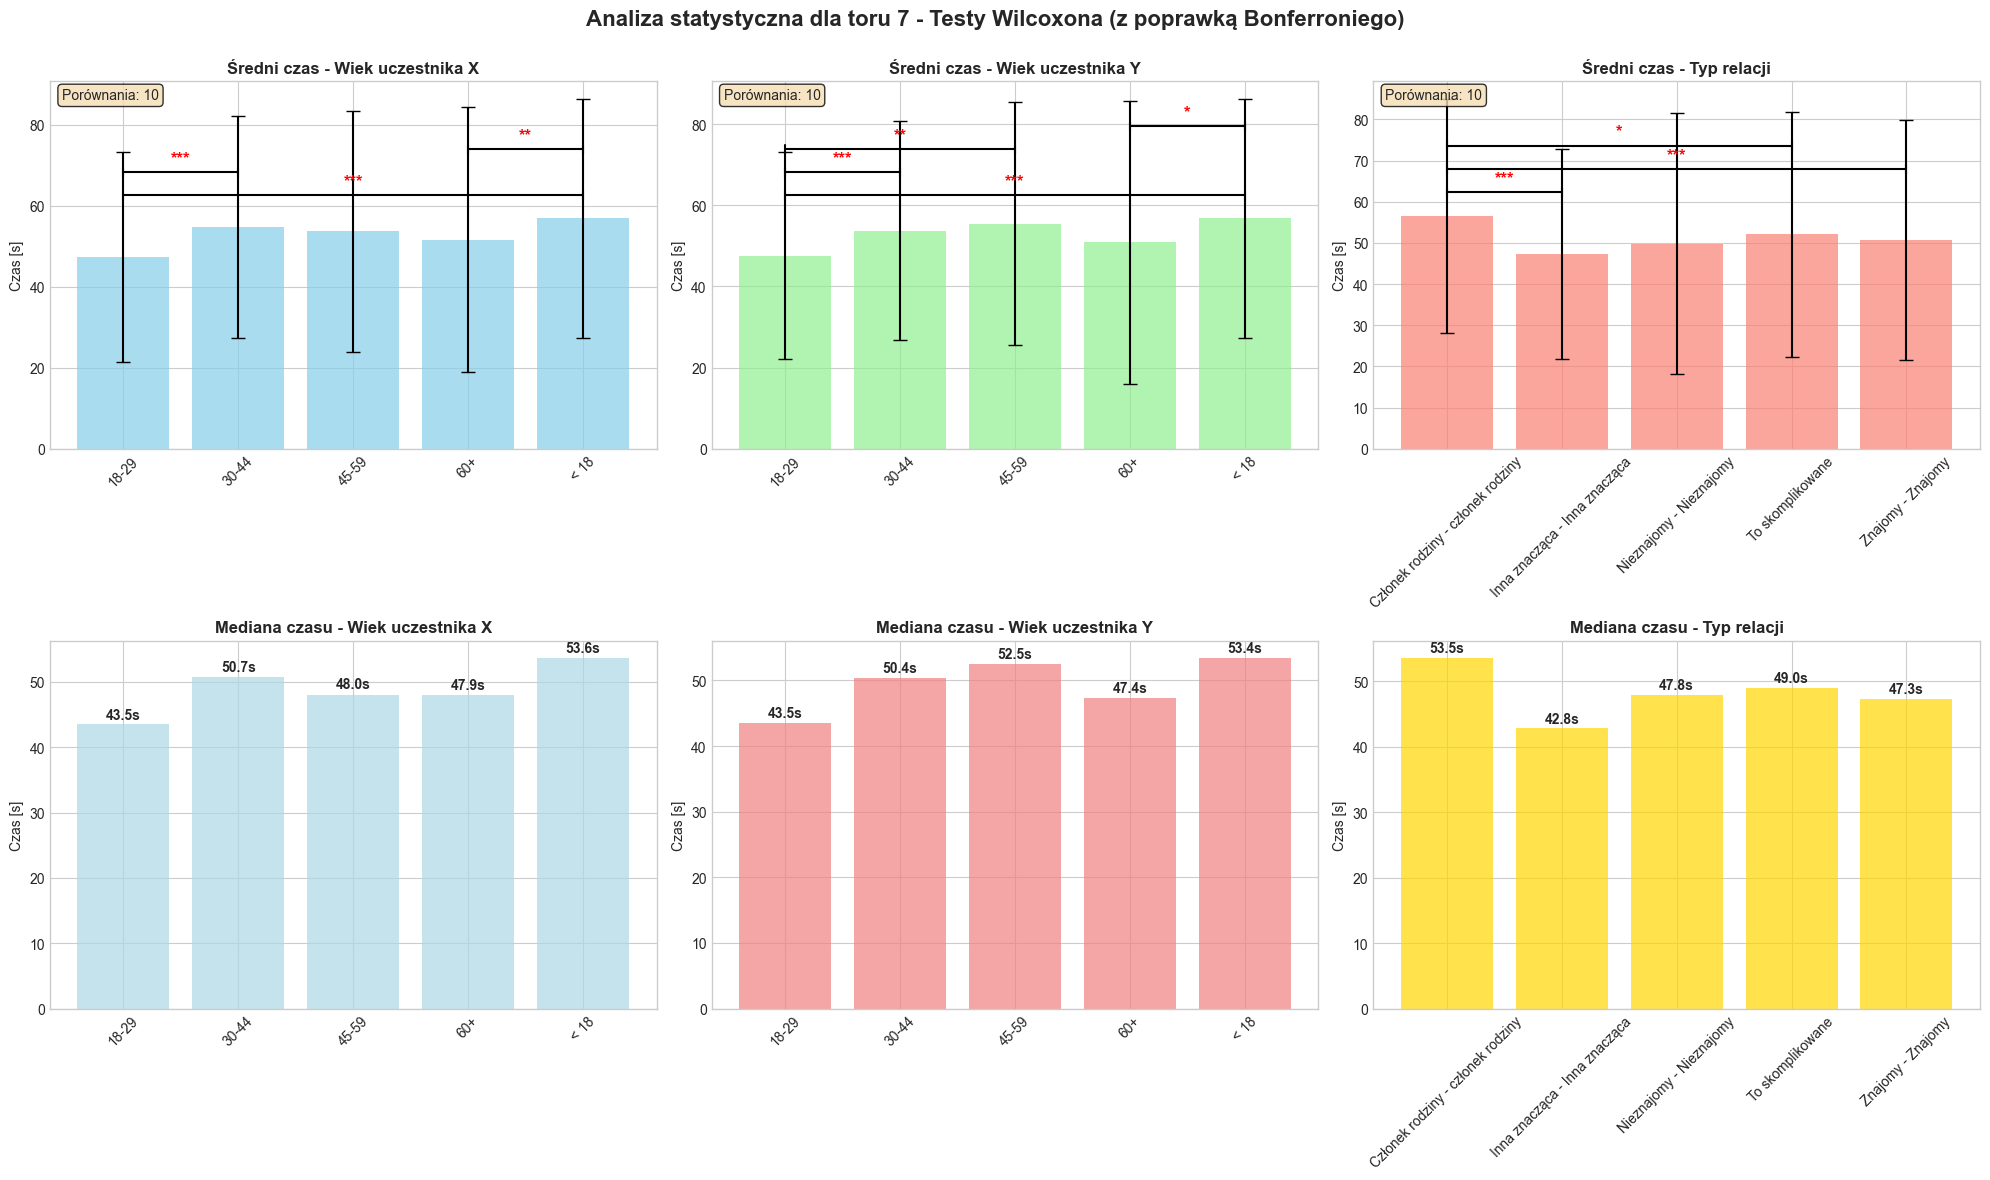

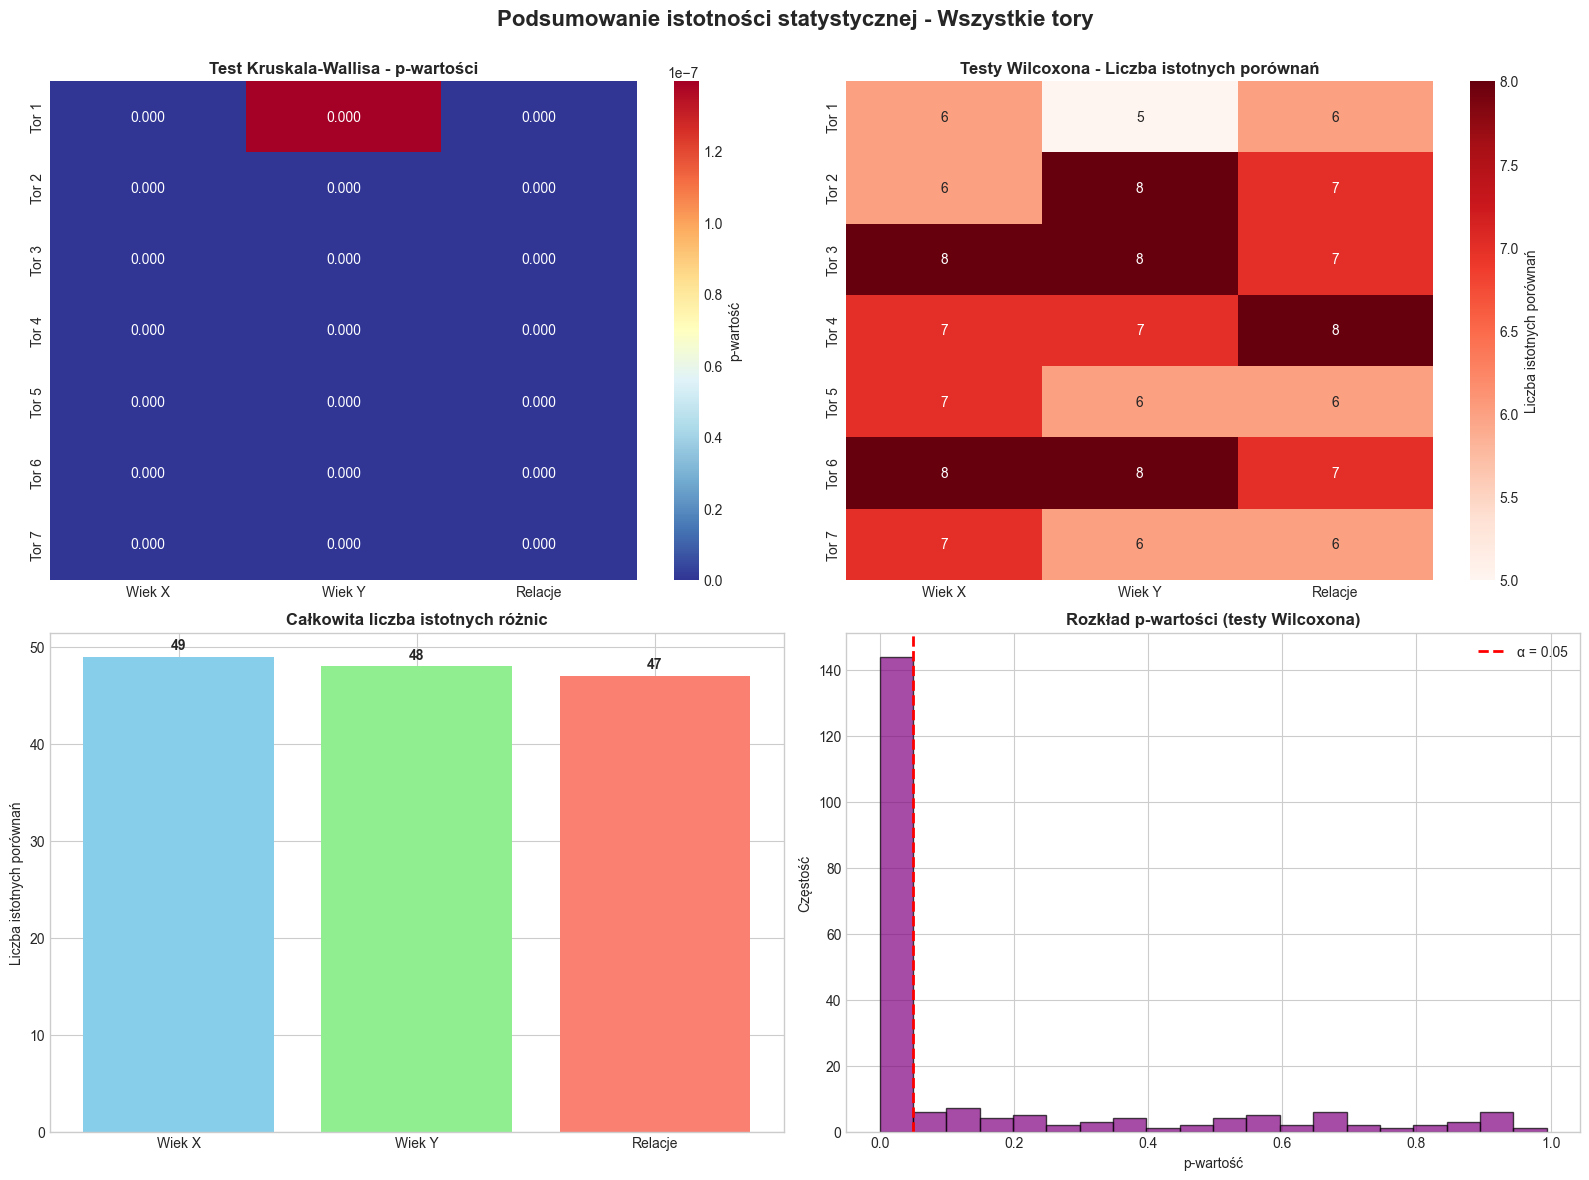

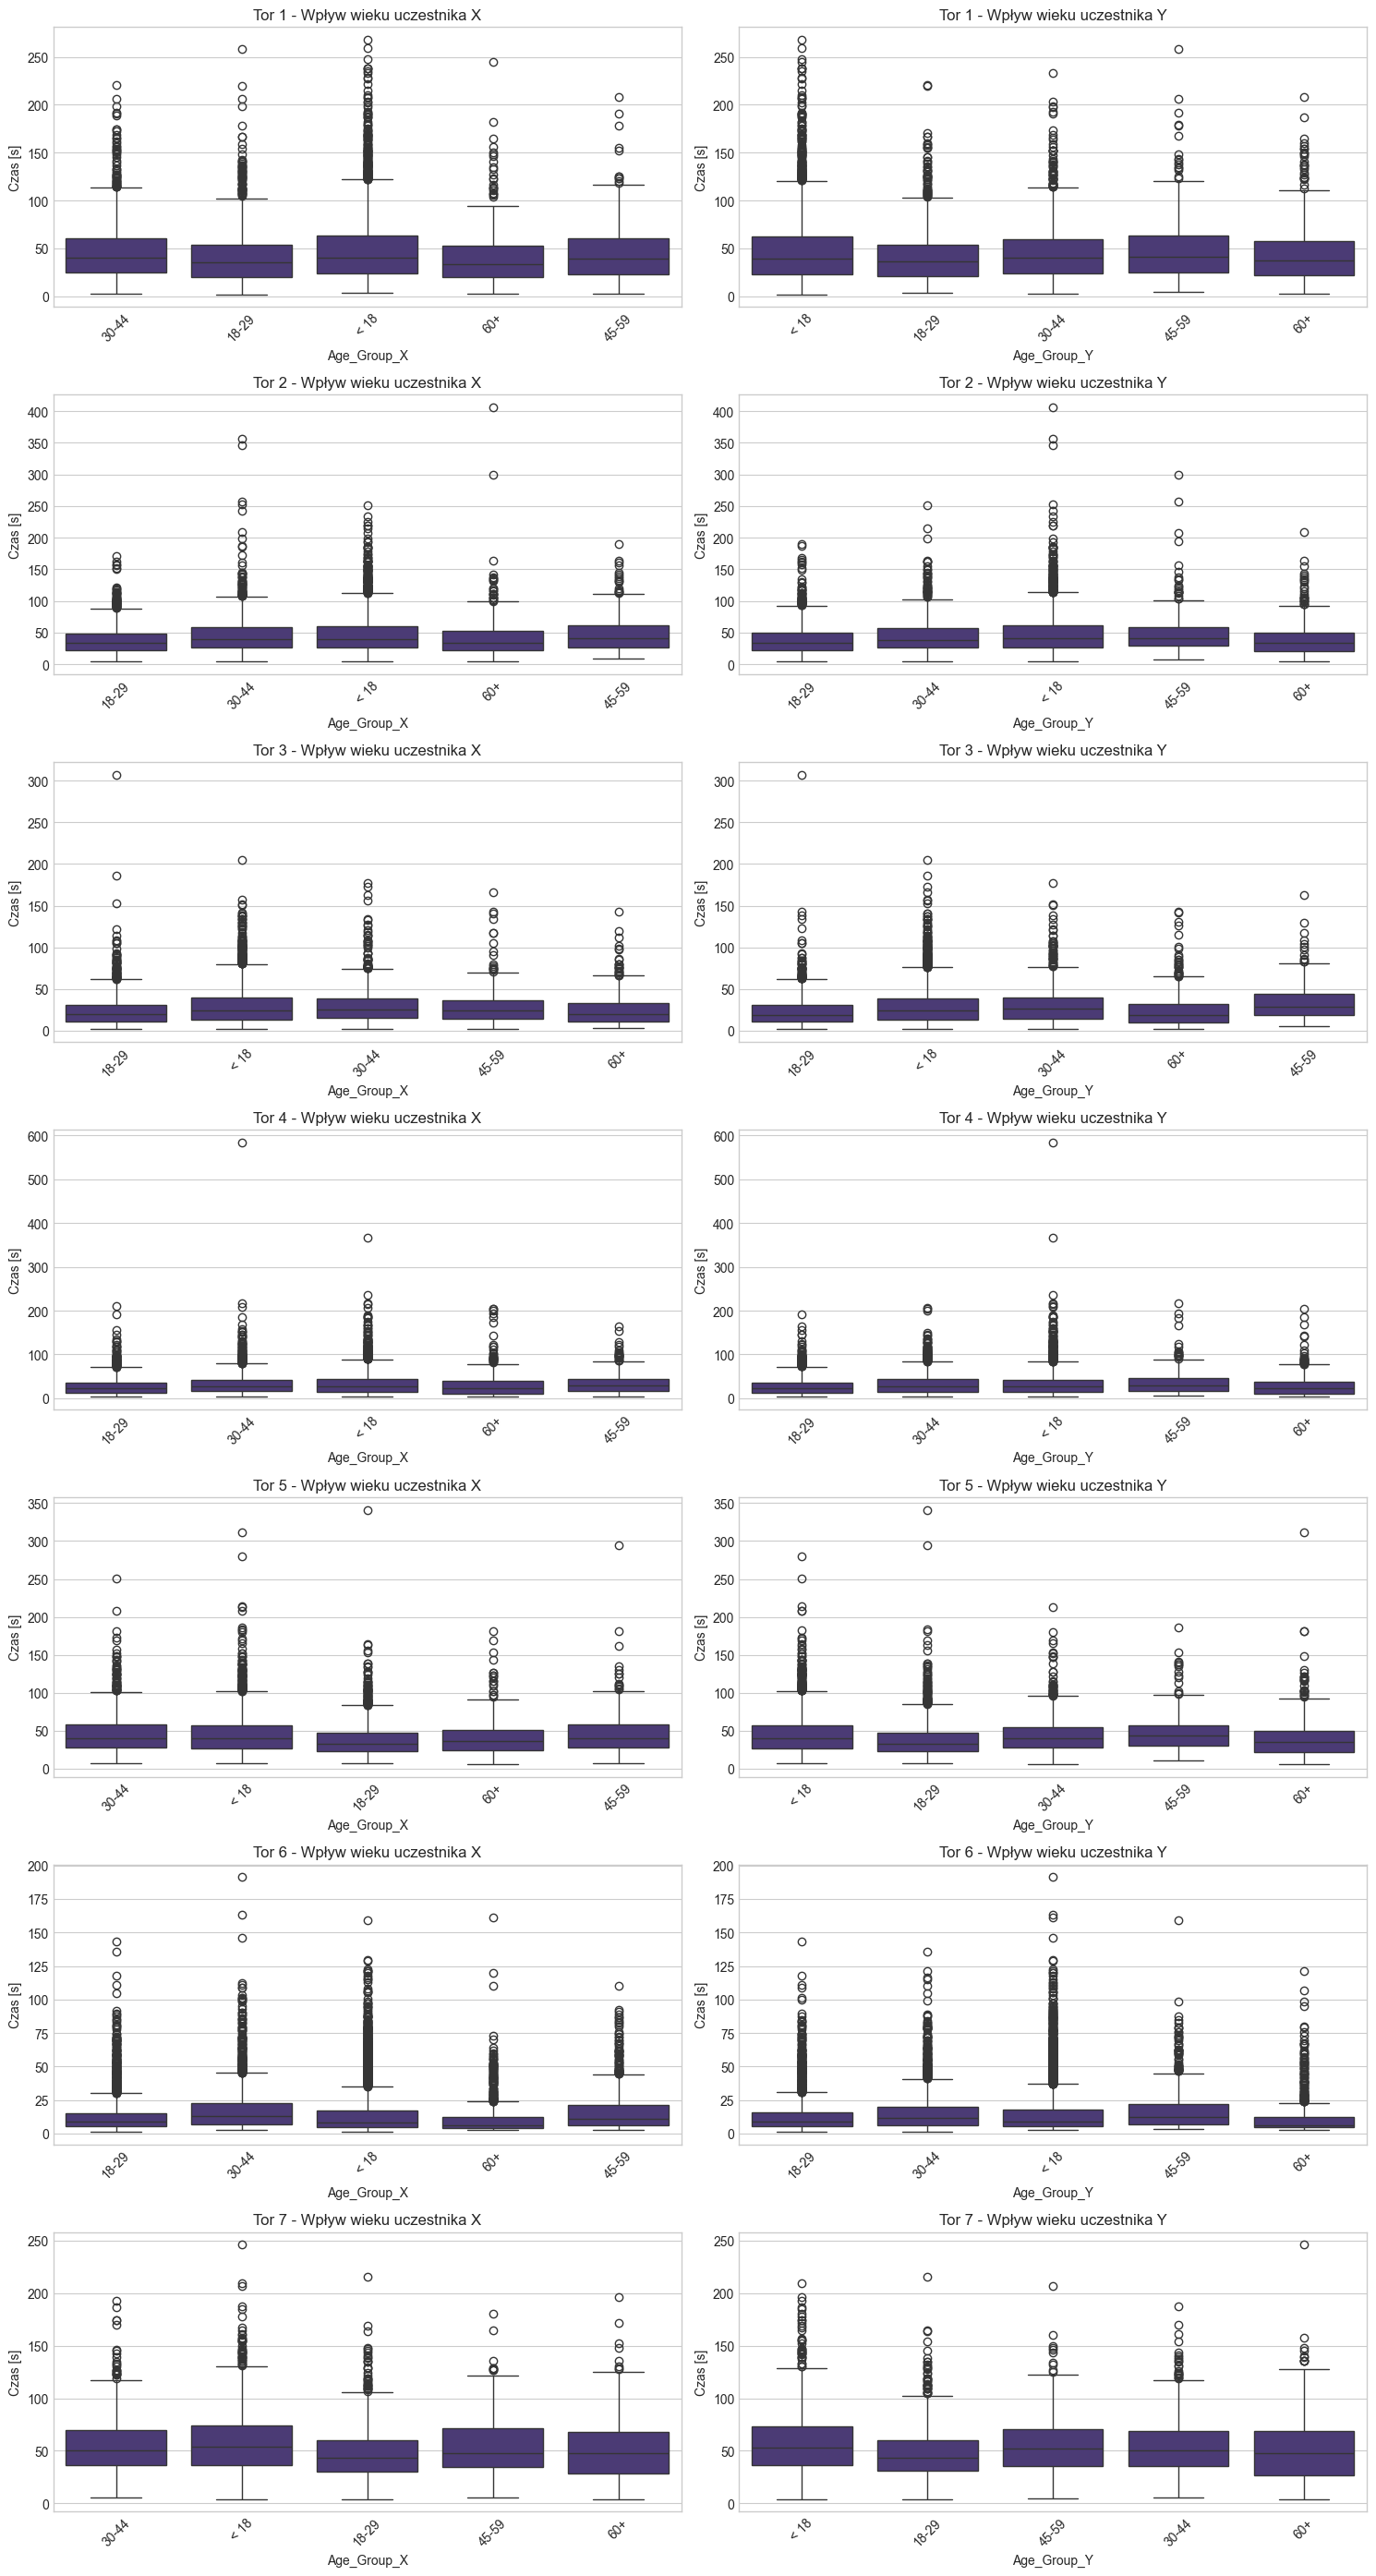

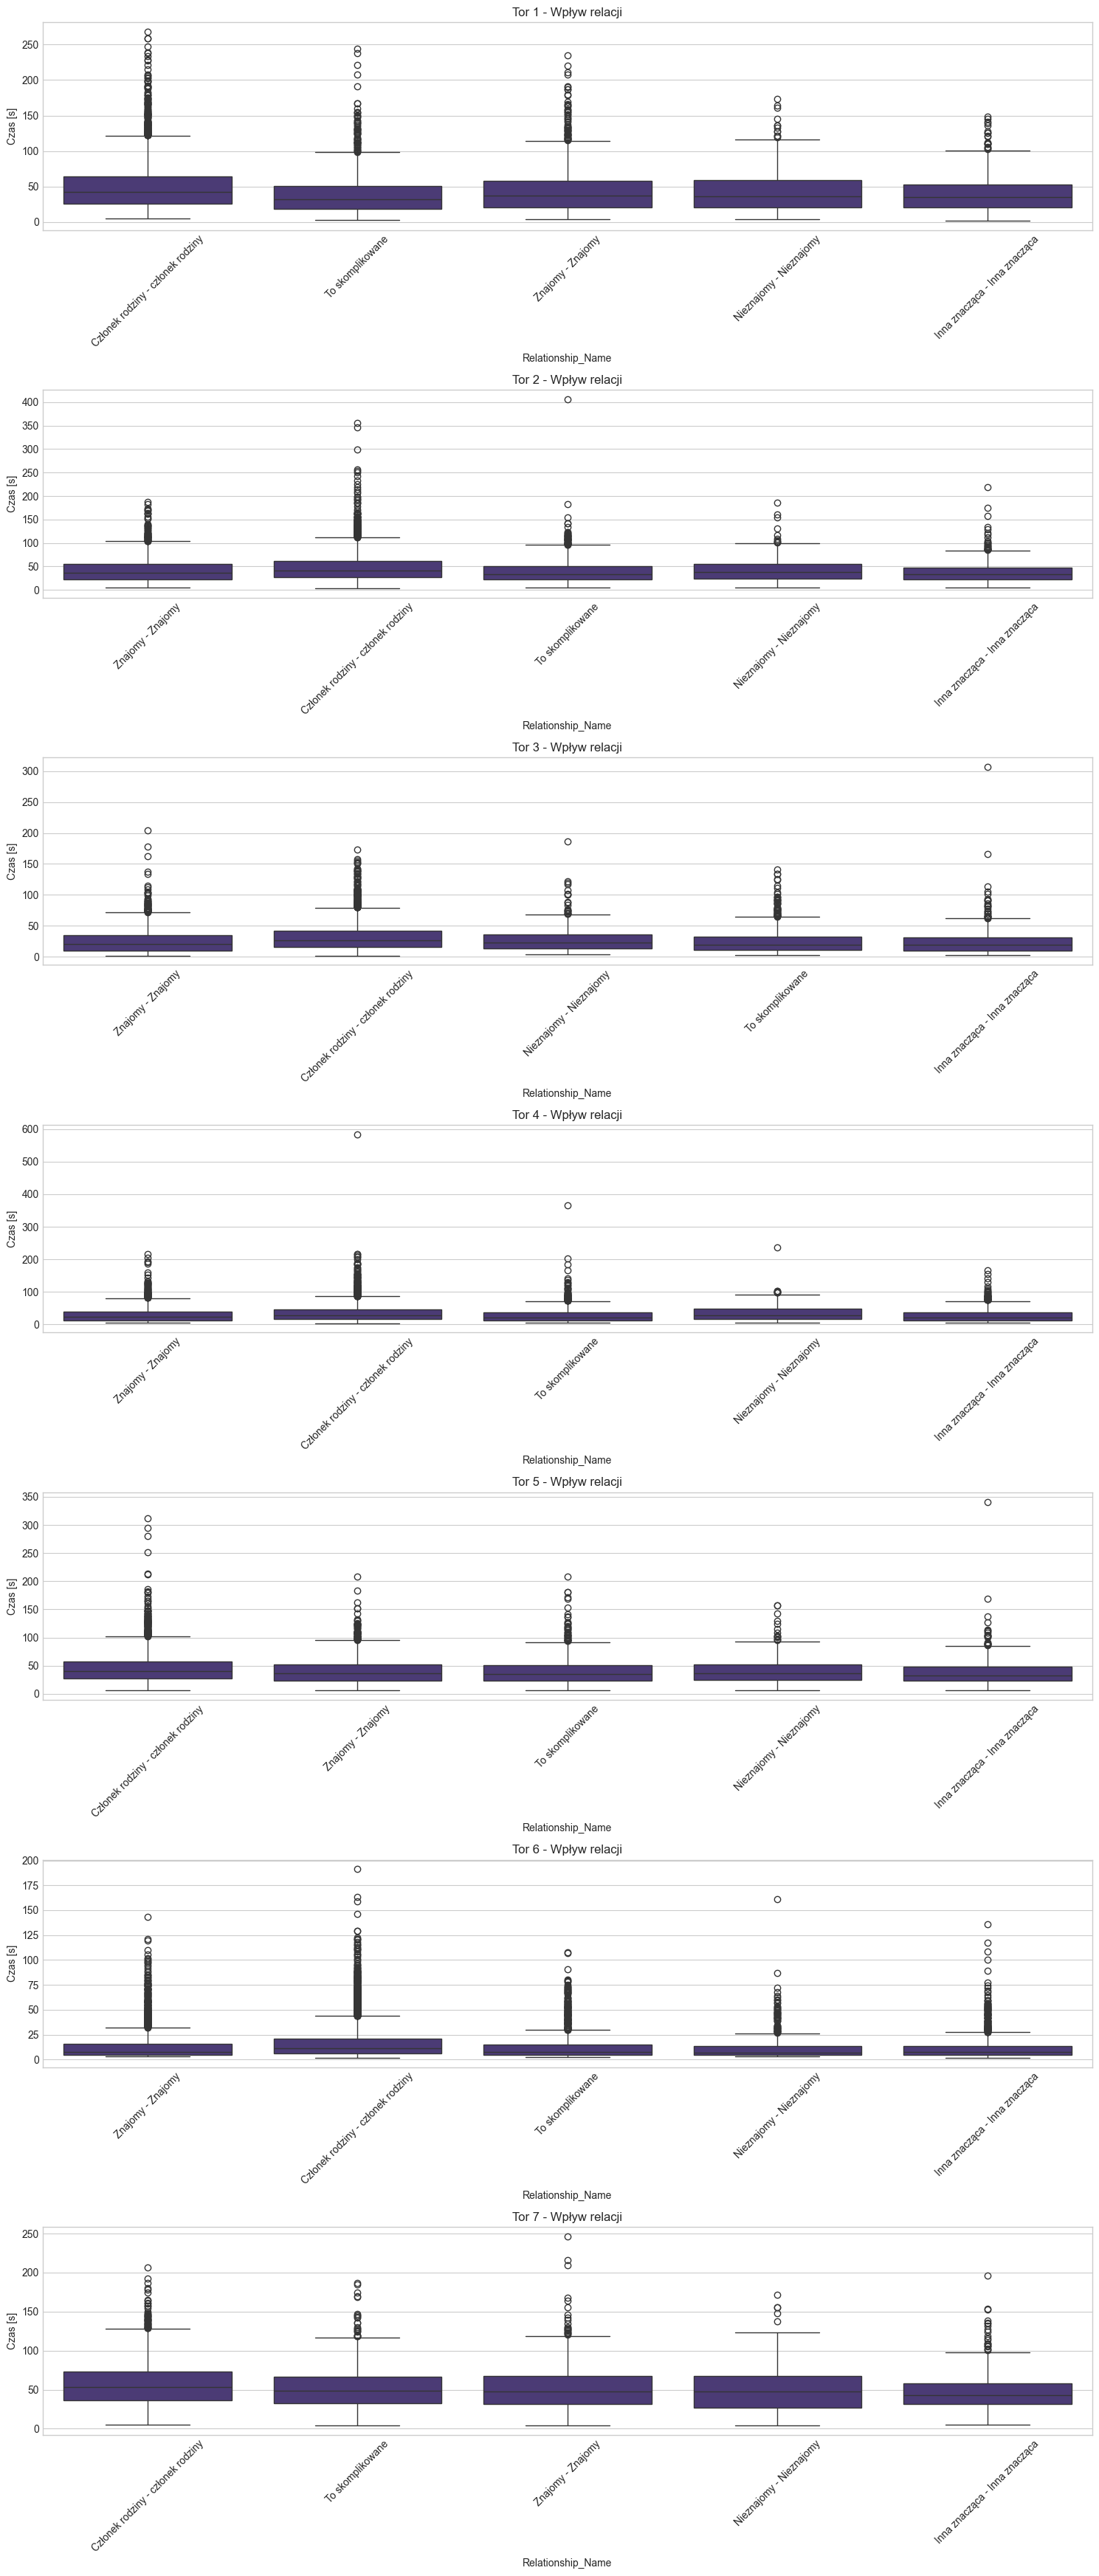

Analiza została zapisana do pliku 'analiza_wynikow_z_wykresami.txt'.
Utworzone pliki:
- analiza_statystyczna_tor_X_z_wasami.png (dla każdego toru)
- podsumowanie_istotnosci_wszystkie_tory.png
- age_group_boxplots.png
- relationship_boxplots.png
- wyniki_kruskal_wallisa.csv
- podsumowanie_wilcoxon.csv
- szczegolowe_istotne_porownania.csv


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import io
from contextlib import redirect_stdout
from scipy.stats import mannwhitneyu, kruskal
import warnings
warnings.filterwarnings('ignore')

# Ustawienie stylu dla wykresów
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis")

def prepare_data(df):
    # Usuwamy wiersze, gdzie Track_Time jest równe 0 (nie ukończone podejścia bez czasu)
    df = df[df['Track_Time'] > 0]
    df = df[df['Track_ID'] <= 7]
    # Przekształcamy zmienne
    df['Track_Time_Seconds'] = df['Track_Time'] / 1000  # Konwersja z milisekund na sekundy
    return df

def wilcoxon_test_balanced(data, group_col, value_col, group1, group2, track_id=None, random_seed=42):
    # Filtrowanie danych dla określonego toru, jeśli podano
    if track_id is not None:
        data = data[data['Track_ID'] == track_id]
    
    # Dzielimy dane na grupy - oryginalne niezmodyfikowane zbiory
    group1_data_orig = data[data[group_col] == group1][value_col]
    group2_data_orig = data[data[group_col] == group2][value_col]
    
    # Sprawdzamy, czy mamy wystarczającą ilość danych do przeprowadzenia testu
    if len(group1_data_orig) < 2 or len(group2_data_orig) < 2:
        return {
            'group1': group1,
            'group2': group2,
            'n1_original': len(group1_data_orig),
            'n2_original': len(group2_data_orig),
            'n_sampled': 0,
            'mean1_original': group1_data_orig.mean() if len(group1_data_orig) > 0 else np.nan,
            'mean2_original': group2_data_orig.mean() if len(group2_data_orig) > 0 else np.nan,
            'median1_original': group1_data_orig.median() if len(group1_data_orig) > 0 else np.nan,
            'median2_original': group2_data_orig.median() if len(group2_data_orig) > 0 else np.nan,
            'mean1_sampled': np.nan,
            'mean2_sampled': np.nan,
            'median1_sampled': np.nan,
            'median2_sampled': np.nan,
            'statistic': np.nan,
            'p_value': np.nan,
            'significant': np.nan
        }
    
    # Przeprowadzamy zrównoważone próbkowanie
    np.random.seed(random_seed)
    
    # Obliczamy liczność mniejszej grupy
    min_size = min(len(group1_data_orig), len(group2_data_orig))
    
    # Kopie oryginalnych danych do samplowania
    group1_data = group1_data_orig.copy()
    group2_data = group2_data_orig.copy()
    
    # Próbkujemy z większej grupy, aby zrównać liczności
    if len(group1_data) > min_size:
        group1_data = group1_data.sample(min_size, random_state=random_seed)
    elif len(group2_data) > min_size:
        group2_data = group2_data.sample(min_size, random_state=random_seed)
    
    # Przeprowadzamy test Wilcoxona (Mann-Whitney U) na zsamplowanych danych
    statistic, p_value = mannwhitneyu(group1_data, group2_data, alternative='two-sided')
    
    # Przygotowanie wyników z danymi zarówno z oryginalnych, jak i zsamplowanych zbiorów
    result = {
        'group1': group1,
        'group2': group2,
        'n1_original': len(group1_data_orig),
        'n2_original': len(group2_data_orig),
        'n_sampled': min_size,
        'mean1_original': group1_data_orig.mean(),
        'mean2_original': group2_data_orig.mean(),
        'median1_original': group1_data_orig.median(),
        'median2_original': group2_data_orig.median(),
        'mean1_sampled': group1_data.mean(),
        'mean2_sampled': group2_data.mean(),
        'median1_sampled': group1_data.median(),
        'median2_sampled': group2_data.median(),
        'statistic': statistic,
        'p_value': p_value,
        'significant': p_value < 0.05
    }
    
    return result

def pairwise_wilcoxon_tests_balanced(data, group_col, value_col, track_id=None, random_seed=42, bonferroni_correction=True):
    # Filtrowanie danych dla określonego toru, jeśli podano
    if track_id is not None:
        data = data[data['Track_ID'] == track_id]
    
    # Pobieramy unikalne grupy
    groups = sorted(data[group_col].unique())
    
    # Tworzymy wszystkie możliwe pary grup
    group_pairs = list(itertools.combinations(groups, 2))
    
    # Liczba porównań dla korekty Bonferroniego
    num_comparisons = len(group_pairs)
    
    # Przeprowadzamy test dla każdej pary
    results = []
    for group1, group2 in group_pairs:
        result = wilcoxon_test_balanced(data, group_col, value_col, group1, group2, track_id, random_seed)
        
        # Dodaj informacje o korekcie Bonferroniego
        if not np.isnan(result['p_value']) and bonferroni_correction:
            # Skorygowana p-wartość (pomnóż przez liczbę porównań)
            p_corrected = min(result['p_value'] * num_comparisons, 1.0)
            result['p_value_corrected'] = p_corrected
            result['significant_corrected'] = p_corrected < 0.05
            result['num_comparisons'] = num_comparisons
            result['correction_applied'] = True
        else:
            result['p_value_corrected'] = result['p_value']
            result['significant_corrected'] = result['significant']
            result['num_comparisons'] = num_comparisons
            result['correction_applied'] = False
        
        results.append(result)
    
    return results

def kruskal_test(data, group_col, value_col, track_id=None):
    # Filtrowanie danych dla określonego toru, jeśli podano
    if track_id is not None:
        data = data[data['Track_ID'] == track_id]
    
    # Pobieramy unikalne grupy
    groups = sorted(data[group_col].unique())
    
    # Sprawdzamy, czy mamy wystarczającą ilość grup
    if len(groups) < 2:
        return {
            'groups': groups,
            'statistic': np.nan,
            'p_value': np.nan,
            'significant': np.nan
        }
    
    # Przygotowujemy dane dla każdej grupy
    group_data = [data[data[group_col] == group][value_col].values for group in groups]
    
    # Sprawdzamy, czy mamy wystarczającą ilość danych w każdej grupie
    if any(len(data) < 1 for data in group_data):
        return {
            'groups': groups,
            'statistic': np.nan,
            'p_value': np.nan,
            'significant': np.nan
        }
    
    # Przeprowadzamy test Kruskala-Wallisa
    statistic, p_value = kruskal(*group_data)
    
    # Przygotowanie wyników
    result = {
        'groups': groups,
        'statistic': statistic,
        'p_value': p_value,
        'significant': p_value < 0.05
    }
    
    return result

def add_significance_bars_advanced(ax, groups, test_results, y_offset_factor=0.1, max_height=None, use_bonferroni=True):
    """Dodaje wąsy istotności statystycznej nad wykresem słupkowym dla testów Wilcoxona"""
    if not test_results:
        return
    
    # Pobierz maksymalną wartość na wykresie
    if max_height is None:
        max_height = max([bar.get_height() for bar in ax.patches if bar.get_height() > 0])
    
    # Filtruj tylko istotne wyniki - używaj skorygowanych p-wartości jeśli dostępne
    if use_bonferroni:
        significant_tests = [t for t in test_results 
                           if t.get('significant_corrected', False) and 
                           not np.isnan(t.get('p_value_corrected', np.nan))]
        p_value_key = 'p_value_corrected'
    else:
        significant_tests = [t for t in test_results 
                           if t.get('significant', False) and 
                           not np.isnan(t.get('p_value', np.nan))]
        p_value_key = 'p_value'
    
    if not significant_tests:
        return
    
    # Sortuj wyniki testów według poziomu istotności (skorygowanej)
    significant_tests.sort(key=lambda x: x[p_value_key])
    
    y_offset = max_height * y_offset_factor
    
    for i, test in enumerate(significant_tests):
        try:
            group1_idx = groups.index(test['group1'])
            group2_idx = groups.index(test['group2'])
        except ValueError:
            continue  # Pomiń jeśli grupa nie została znaleziona
        
        # Pozycje x dla słupków
        x1 = ax.patches[group1_idx].get_x() + ax.patches[group1_idx].get_width()/2
        x2 = ax.patches[group2_idx].get_x() + ax.patches[group2_idx].get_width()/2
        
        # Wysokość dla wąsa
        y = max_height + y_offset * (i + 1)
        
        # Symbol istotności na podstawie skorygowanej p-wartości
        p_val = test[p_value_key]
        if p_val < 0.001:
            symbol = '***'
        elif p_val < 0.01:
            symbol = '**'
        elif p_val < 0.05:
            symbol = '*'
        else:
            symbol = 'ns'
        
        # Rysuj poziomy wąs
        ax.plot([x1, x2], [y, y], 'k-', linewidth=1.5)
        # Rysuj pionowe końcówki
        ax.plot([x1, x1], [y-max_height*0.02, y+max_height*0.02], 'k-', linewidth=1.5)
        ax.plot([x2, x2], [y-max_height*0.02, y+max_height*0.02], 'k-', linewidth=1.5)
        
        # Dodaj symbol istotności
        color = 'red' if use_bonferroni else 'blue'
        ax.text((x1+x2)/2, y+max_height*0.03, symbol, ha='center', va='bottom', 
                fontweight='bold', fontsize=12, color=color)

def create_bar_plots_with_significance(df, track_id, results_age_x, results_age_y, results_rel, use_bonferroni=True):
    """Tworzy wykresy słupkowe z wąsami istotności dla konkretnego toru"""
    
    # Filtruj dane dla konkretnego toru
    track_df = df[df['Track_ID'] == track_id]
    completed_df = track_df[track_df['Track_Completed'] == True]
    
    if len(completed_df) < 5:
        print(f"Za mało danych dla toru {track_id} - pomijam wykresy")
        return
    
    # Przygotuj dane do wykresów
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    correction_text = "z poprawką Bonferroniego" if use_bonferroni else "bez poprawki"
    fig.suptitle(f'Analiza statystyczna dla toru {track_id} - Testy Wilcoxona ({correction_text})', 
                 fontsize=16, fontweight='bold')
    
    # 1. Średnie czasy według wieku X
    ax1 = axes[0, 0]
    age_x_stats = completed_df.groupby('Age_Group_X')['Track_Time_Seconds'].agg(['mean', 'std', 'count']).reset_index()
    bars1 = ax1.bar(age_x_stats['Age_Group_X'], age_x_stats['mean'], 
                    yerr=age_x_stats['std'], capsize=5, alpha=0.7, color='skyblue')
    ax1.set_title('Średni czas - Wiek uczestnika X', fontweight='bold')
    ax1.set_ylabel('Czas [s]')
    ax1.tick_params(axis='x', rotation=45)
    
    # Dodaj wąsy istotności
    groups_x = sorted(completed_df['Age_Group_X'].unique())
    add_significance_bars_advanced(ax1, groups_x, results_age_x, use_bonferroni=use_bonferroni)
    
    # Dodaj informację o liczbie porównań
    if results_age_x and len(results_age_x) > 0:
        num_comp = results_age_x[0].get('num_comparisons', 0)
        ax1.text(0.02, 0.98, f'Porównania: {num_comp}', transform=ax1.transAxes, 
                verticalalignment='top', fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # 2. Średnie czasy według wieku Y
    ax2 = axes[0, 1]
    age_y_stats = completed_df.groupby('Age_Group_Y')['Track_Time_Seconds'].agg(['mean', 'std', 'count']).reset_index()
    bars2 = ax2.bar(age_y_stats['Age_Group_Y'], age_y_stats['mean'], 
                    yerr=age_y_stats['std'], capsize=5, alpha=0.7, color='lightgreen')
    ax2.set_title('Średni czas - Wiek uczestnika Y', fontweight='bold')
    ax2.set_ylabel('Czas [s]')
    ax2.tick_params(axis='x', rotation=45)
    
    # Dodaj wąsy istotności
    groups_y = sorted(completed_df['Age_Group_Y'].unique())
    add_significance_bars_advanced(ax2, groups_y, results_age_y, use_bonferroni=use_bonferroni)
    
    # Dodaj informację o liczbie porównań
    if results_age_y and len(results_age_y) > 0:
        num_comp = results_age_y[0].get('num_comparisons', 0)
        ax2.text(0.02, 0.98, f'Porównania: {num_comp}', transform=ax2.transAxes, 
                verticalalignment='top', fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # 3. Średnie czasy według relacji
    ax3 = axes[0, 2]
    rel_stats = completed_df.groupby('Relationship_Name')['Track_Time_Seconds'].agg(['mean', 'std', 'count']).reset_index()
    bars3 = ax3.bar(rel_stats['Relationship_Name'], rel_stats['mean'], 
                    yerr=rel_stats['std'], capsize=5, alpha=0.7, color='salmon')
    ax3.set_title('Średni czas - Typ relacji', fontweight='bold')
    ax3.set_ylabel('Czas [s]')
    ax3.tick_params(axis='x', rotation=45)
    
    # Dodaj wąsy istotności
    groups_rel = sorted(completed_df['Relationship_Name'].unique())
    add_significance_bars_advanced(ax3, groups_rel, results_rel, use_bonferroni=use_bonferroni)
    
    # Dodaj informację o liczbie porównań
    if results_rel and len(results_rel) > 0:
        num_comp = results_rel[0].get('num_comparisons', 0)
        ax3.text(0.02, 0.98, f'Porównania: {num_comp}', transform=ax3.transAxes, 
                verticalalignment='top', fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # 4. Mediany według wieku X
    ax4 = axes[1, 0]
    age_x_median = completed_df.groupby('Age_Group_X')['Track_Time_Seconds'].median().reset_index()
    bars4 = ax4.bar(age_x_median['Age_Group_X'], age_x_median['Track_Time_Seconds'], 
                    alpha=0.7, color='lightblue')
    ax4.set_title('Mediana czasu - Wiek uczestnika X', fontweight='bold')
    ax4.set_ylabel('Czas [s]')
    ax4.tick_params(axis='x', rotation=45)
    
    # Dodaj etykiety wartości na słupkach
    for i, bar in enumerate(bars4):
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{height:.1f}s', ha='center', va='bottom', fontweight='bold')
    
    # 5. Mediany według wieku Y
    ax5 = axes[1, 1]
    age_y_median = completed_df.groupby('Age_Group_Y')['Track_Time_Seconds'].median().reset_index()
    bars5 = ax5.bar(age_y_median['Age_Group_Y'], age_y_median['Track_Time_Seconds'], 
                    alpha=0.7, color='lightcoral')
    ax5.set_title('Mediana czasu - Wiek uczestnika Y', fontweight='bold')
    ax5.set_ylabel('Czas [s]')
    ax5.tick_params(axis='x', rotation=45)
    
    # Dodaj etykiety wartości na słupkach
    for i, bar in enumerate(bars5):
        height = bar.get_height()
        ax5.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{height:.1f}s', ha='center', va='bottom', fontweight='bold')
    
    # 6. Mediany według relacji
    ax6 = axes[1, 2]
    rel_median = completed_df.groupby('Relationship_Name')['Track_Time_Seconds'].median().reset_index()
    bars6 = ax6.bar(rel_median['Relationship_Name'], rel_median['Track_Time_Seconds'], 
                    alpha=0.7, color='gold')
    ax6.set_title('Mediana czasu - Typ relacji', fontweight='bold')
    ax6.set_ylabel('Czas [s]')
    ax6.tick_params(axis='x', rotation=45)
    
    # Dodaj etykiety wartości na słupkach
    for i, bar in enumerate(bars6):
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{height:.1f}s', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()
    
    # Zapisz wykres
    correction_suffix = "_bonferroni" if use_bonferroni else "_raw"
    plt.savefig(f'analiza_statystyczna_tor_{track_id}_z_wasami{correction_suffix}.png', dpi=300, bbox_inches='tight')
    plt.close()

def create_summary_significance_plot(df, all_results):
    """Tworzy podsumowujący wykres istotności dla wszystkich torów"""
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Podsumowanie istotności statystycznej - Wszystkie tory', fontsize=16, fontweight='bold')
    
    # Przygotuj dane do heatmapy istotności
    tracks = sorted(df['Track_ID'].unique())
    
    # 1. Heatmapa p-wartości dla testów Kruskala-Wallisa
    ax1 = axes[0, 0]
    kruskal_data = []
    
    for track_id in tracks:
        if track_id in all_results['age_groups']:
            kw_x = all_results['age_groups'][track_id].get('kruskal_x', {}).get('p_value', np.nan)
            kw_y = all_results['age_groups'][track_id].get('kruskal_y', {}).get('p_value', np.nan)
            kw_rel = all_results['relationships'][track_id].get('kruskal', {}).get('p_value', np.nan)
        else:
            kw_x = kw_y = kw_rel = np.nan
        
        kruskal_data.append([kw_x, kw_y, kw_rel])
    
    kruskal_df = pd.DataFrame(kruskal_data, 
                             columns=['Wiek X', 'Wiek Y', 'Relacje'], 
                             index=[f'Tor {t}' for t in tracks])
    
    sns.heatmap(kruskal_df, annot=True, fmt='.3f', cmap='RdYlBu_r', 
                ax=ax1, cbar_kws={'label': 'p-wartość'})
    ax1.set_title('Test Kruskala-Wallisa - p-wartości', fontweight='bold')
    
    # 2. Liczba istotnych porównań Wilcoxona na tor
    ax2 = axes[0, 1]
    sig_counts = []
    
    for track_id in tracks:
        if track_id in all_results['age_groups']:
            wilc_x = all_results['age_groups'][track_id].get('wilcoxon_x', [])
            wilc_y = all_results['age_groups'][track_id].get('wilcoxon_y', [])
            wilc_rel = all_results['relationships'][track_id].get('wilcoxon', [])
            
            sig_x = sum(1 for w in wilc_x if w.get('significant', False))
            sig_y = sum(1 for w in wilc_y if w.get('significant', False))
            sig_rel = sum(1 for w in wilc_rel if w.get('significant', False))
        else:
            sig_x = sig_y = sig_rel = 0
        
        sig_counts.append([sig_x, sig_y, sig_rel])
    
    sig_df = pd.DataFrame(sig_counts, 
                         columns=['Wiek X', 'Wiek Y', 'Relacje'], 
                         index=[f'Tor {t}' for t in tracks])
    
    sns.heatmap(sig_df, annot=True, fmt='d', cmap='Reds', 
                ax=ax2, cbar_kws={'label': 'Liczba istotnych porównań'})
    ax2.set_title('Testy Wilcoxona - Liczba istotnych porównań', fontweight='bold')
    
    # 3. Wykres słupkowy całkowitej liczby istotnych wyników
    ax3 = axes[1, 0]
    total_sig = sig_df.sum()
    bars = ax3.bar(total_sig.index, total_sig.values, color=['skyblue', 'lightgreen', 'salmon'])
    ax3.set_title('Całkowita liczba istotnych różnic', fontweight='bold')
    ax3.set_ylabel('Liczba istotnych porównań')
    
    # Dodaj etykiety na słupkach
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{int(height)}', ha='center', va='bottom', fontweight='bold')
    
    # 4. Rozkład p-wartości
    ax4 = axes[1, 1]
    all_p_values = []
    
    for track_id in tracks:
        if track_id in all_results['age_groups']:
            wilc_x = all_results['age_groups'][track_id].get('wilcoxon_x', [])
            wilc_y = all_results['age_groups'][track_id].get('wilcoxon_y', [])
            wilc_rel = all_results['relationships'][track_id].get('wilcoxon', [])
            
            for w in wilc_x + wilc_y + wilc_rel:
                p_val = w.get('p_value', np.nan)
                if not np.isnan(p_val):
                    all_p_values.append(p_val)
    
    if all_p_values:
        ax4.hist(all_p_values, bins=20, alpha=0.7, color='purple', edgecolor='black')
        ax4.axvline(x=0.05, color='red', linestyle='--', linewidth=2, label='α = 0.05')
        ax4.set_title('Rozkład p-wartości (testy Wilcoxona)', fontweight='bold')
        ax4.set_xlabel('p-wartość')
        ax4.set_ylabel('Częstość')
        ax4.legend()
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()
    
    plt.savefig('podsumowanie_istotnosci_wszystkie_tory.png', dpi=300, bbox_inches='tight')
    plt.close()

def analyze_performance(df, random_seed=42):
    # Analizujemy tylko ukończone podejścia
    completed_df = df[df['Track_Completed'] == True]
    
    # Unikalne identyfikatory torów
    track_ids = sorted(df['Track_ID'].unique())
    
    results = {
        'age_groups': {},
        'relationships': {}
    }
    
    # Analiza dla wszystkich danych (bez podziału na tory)
    print("Analiza dla wszystkich torów łącznie:")
    print("\nTest Kruskala-Wallisa dla grup wiekowych (Age_Group_X):")
    kruskal_result_age_x = kruskal_test(completed_df, 'Age_Group_X', 'Track_Time_Seconds')
    print(f"Statystyka: {kruskal_result_age_x['statistic']:.2f}, p-wartość: {kruskal_result_age_x['p_value']:.4f}, Istotne: {kruskal_result_age_x['significant']}")
    
    print("\nTest Kruskala-Wallisa dla grup wiekowych (Age_Group_Y):")
    kruskal_result_age_y = kruskal_test(completed_df, 'Age_Group_Y', 'Track_Time_Seconds')
    print(f"Statystyka: {kruskal_result_age_y['statistic']:.2f}, p-wartość: {kruskal_result_age_y['p_value']:.4f}, Istotne: {kruskal_result_age_y['significant']}")
    
    print("\nTest Kruskala-Wallisa dla relacji (Relationship_Name):")
    kruskal_result_rel = kruskal_test(completed_df, 'Relationship_Name', 'Track_Time_Seconds')
    print(f"Statystyka: {kruskal_result_rel['statistic']:.2f}, p-wartość: {kruskal_result_rel['p_value']:.4f}, Istotne: {kruskal_result_rel['significant']}")
    
    # Analizujemy każdy tor osobno
    for track_id in track_ids:
        print(f"\n\n=== Analiza dla toru {track_id} ===")
        track_df = completed_df[completed_df['Track_ID'] == track_id]
        
        # Sprawdzamy, czy mamy wystarczającą ilość danych dla tego toru
        if len(track_df) < 5:
            print(f"Za mało danych dla toru {track_id} (n={len(track_df)}). Pomijam.")
            continue
        
        # Test Kruskala-Wallisa dla grup wiekowych
        print("\nTest Kruskala-Wallisa dla grup wiekowych (Age_Group_X):")
        kruskal_result_age_x = kruskal_test(track_df, 'Age_Group_X', 'Track_Time_Seconds')
        print(f"Statystyka: {kruskal_result_age_x['statistic']:.2f}, p-wartość: {kruskal_result_age_x['p_value']:.4f}, Istotne: {kruskal_result_age_x['significant']}")
        
        print("\nTest Kruskala-Wallisa dla grup wiekowych (Age_Group_Y):")
        kruskal_result_age_y = kruskal_test(track_df, 'Age_Group_Y', 'Track_Time_Seconds')
        print(f"Statystyka: {kruskal_result_age_y['statistic']:.2f}, p-wartość: {kruskal_result_age_y['p_value']:.4f}, Istotne: {kruskal_result_age_y['significant']}")
        
        print("\nTest Kruskala-Wallisa dla relacji (Relationship_Name):")
        kruskal_result_rel = kruskal_test(track_df, 'Relationship_Name', 'Track_Time_Seconds')
        print(f"Statystyka: {kruskal_result_rel['statistic']:.2f}, p-wartość: {kruskal_result_rel['p_value']:.4f}, Istotne: {kruskal_result_rel['significant']}")
        
        # Szczegółowe testy Wilcoxona dla par grup z zrównoważonym samplingiem
        print("\nSzczegółowe testy Wilcoxona z zrównoważonym samplingiem dla par grup wiekowych (Age_Group_X):")
        wilcoxon_results_age_x = pairwise_wilcoxon_tests_balanced(track_df, 'Age_Group_X', 'Track_Time_Seconds', track_id, random_seed)
        for res in wilcoxon_results_age_x:
            if np.isnan(res['p_value']):
                print(f"{res['group1']} vs {res['group2']}: Za mało danych (n1={res['n1_original']}, n2={res['n2_original']})")
            else:
                print(f"{res['group1']} vs {res['group2']}: Statystyka={res['statistic']:.2f}, p-wartość={res['p_value']:.4f}, Istotne={res['significant']}")
                print(f"  Próbki: Oryginalne (n1={res['n1_original']}, n2={res['n2_original']}), Po zrównoważeniu: n={res['n_sampled']}")
                print(f"  Średnie czasy (oryginalne): {res['group1']}={res['mean1_original']:.2f}s, {res['group2']}={res['mean2_original']:.2f}s")
                print(f"  Mediany czasów (oryginalne): {res['group1']}={res['median1_original']:.2f}s, {res['group2']}={res['median2_original']:.2f}s")
                print(f"  Średnie czasy (zsamplowane): {res['group1']}={res['mean1_sampled']:.2f}s, {res['group2']}={res['mean2_sampled']:.2f}s")
                print(f"  Mediany czasów (zsamplowane): {res['group1']}={res['median1_sampled']:.2f}s, {res['group2']}={res['median2_sampled']:.2f}s")
        
        print("\nSzczegółowe testy Wilcoxona z zrównoważonym samplingiem dla par grup wiekowych (Age_Group_Y):")
        wilcoxon_results_age_y = pairwise_wilcoxon_tests_balanced(track_df, 'Age_Group_Y', 'Track_Time_Seconds', track_id, random_seed)
        for res in wilcoxon_results_age_y:
            if np.isnan(res['p_value']):
                print(f"{res['group1']} vs {res['group2']}: Za mało danych (n1={res['n1_original']}, n2={res['n2_original']})")
            else:
                print(f"{res['group1']} vs {res['group2']}: Statystyka={res['statistic']:.2f}, p-wartość={res['p_value']:.4f}, Istotne={res['significant']}")
                print(f"  Próbki: Oryginalne (n1={res['n1_original']}, n2={res['n2_original']}), Po zrównoważeniu: n={res['n_sampled']}")
                print(f"  Średnie czasy (oryginalne): {res['group1']}={res['mean1_original']:.2f}s, {res['group2']}={res['mean2_original']:.2f}s")
                print(f"  Mediany czasów (oryginalne): {res['group1']}={res['median1_original']:.2f}s, {res['group2']}={res['median2_original']:.2f}s")
                print(f"  Średnie czasy (zsamplowane): {res['group1']}={res['mean1_sampled']:.2f}s, {res['group2']}={res['mean2_sampled']:.2f}s")
                print(f"  Mediany czasów (zsamplowane): {res['group1']}={res['median1_sampled']:.2f}s, {res['group2']}={res['median2_sampled']:.2f}s")
        
        print("\nSzczegółowe testy Wilcoxona z zrównoważonym samplingiem dla par relacji (Relationship_Name):")
        wilcoxon_results_rel = pairwise_wilcoxon_tests_balanced(track_df, 'Relationship_Name', 'Track_Time_Seconds', track_id, random_seed)
        for res in wilcoxon_results_rel:
            if np.isnan(res['p_value']):
                print(f"{res['group1']} vs {res['group2']}: Za mało danych (n1={res['n1_original']}, n2={res['n2_original']})")
            else:
                print(f"{res['group1']} vs {res['group2']}: Statystyka={res['statistic']:.2f}, p-wartość={res['p_value']:.4f}, Istotne={res['significant']}")
                print(f"  Próbki: Oryginalne (n1={res['n1_original']}, n2={res['n2_original']}), Po zrównoważeniu: n={res['n_sampled']}")
                print(f"  Średnie czasy (oryginalne): {res['group1']}={res['mean1_original']:.2f}s, {res['group2']}={res['mean2_original']:.2f}s")
                print(f"  Mediany czasów (oryginalne): {res['group1']}={res['median1_original']:.2f}s, {res['group2']}={res['median2_original']:.2f}s")
                print(f"  Średnie czasy (zsamplowane): {res['group1']}={res['mean1_sampled']:.2f}s, {res['group2']}={res['mean2_sampled']:.2f}s")
                print(f"  Mediany czasów (zsamplowane): {res['group1']}={res['median1_sampled']:.2f}s, {res['group2']}={res['median2_sampled']:.2f}s")
        
        # Zapisujemy wyniki
        results['age_groups'][track_id] = {
            'kruskal_x': kruskal_result_age_x,
            'kruskal_y': kruskal_result_age_y,
            'wilcoxon_x': wilcoxon_results_age_x,
            'wilcoxon_y': wilcoxon_results_age_y
        }
        
        results['relationships'][track_id] = {
            'kruskal': kruskal_result_rel,
            'wilcoxon': wilcoxon_results_rel
        }
        
        # *** NOWE: Tworzenie wykresów słupkowych z wąsami istotności dla tego toru ***
        print(f"\nTworzenie wykresów z wąsami istotności dla toru {track_id}...")
        create_bar_plots_with_significance(df, track_id, wilcoxon_results_age_x, 
                                         wilcoxon_results_age_y, wilcoxon_results_rel)
    
    # *** NOWE: Tworzenie podsumowującego wykresu istotności ***
    print("\nTworzenie podsumowującego wykresu istotności...")
    create_summary_significance_plot(df, results)
    
    return results

def create_detailed_comparison_tables(df, results):
    """Tworzy szczegółowe tabele porównawcze z wynikami testów"""
    
    tracks = sorted(df['Track_ID'].unique())
    
    # Tabela 1: Wyniki testów Kruskala-Wallisa
    kruskal_data = []
    for track_id in tracks:
        if track_id in results['age_groups']:
            kw_x = results['age_groups'][track_id].get('kruskal_x', {})
            kw_y = results['age_groups'][track_id].get('kruskal_y', {})
            kw_rel = results['relationships'][track_id].get('kruskal', {})
            
            kruskal_data.append({
                'Tor': track_id,
                'Wiek_X_stat': kw_x.get('statistic', np.nan),
                'Wiek_X_p': kw_x.get('p_value', np.nan),
                'Wiek_X_istotne': kw_x.get('significant', False),
                'Wiek_Y_stat': kw_y.get('statistic', np.nan),
                'Wiek_Y_p': kw_y.get('p_value', np.nan),
                'Wiek_Y_istotne': kw_y.get('significant', False),
                'Relacje_stat': kw_rel.get('statistic', np.nan),
                'Relacje_p': kw_rel.get('p_value', np.nan),
                'Relacje_istotne': kw_rel.get('significant', False)
            })
    
    kruskal_df = pd.DataFrame(kruskal_data)
    print("\n=== TABELA WYNIKÓW TESTÓW KRUSKALA-WALLISA ===")
    print(kruskal_df.round(4))
    kruskal_df.to_csv('wyniki_kruskal_wallisa.csv', index=False)
    
    # Tabela 2: Podsumowanie istotnych porównań Wilcoxona
    wilcoxon_summary = []
    for track_id in tracks:
        if track_id in results['age_groups']:
            wilc_x = results['age_groups'][track_id].get('wilcoxon_x', [])
            wilc_y = results['age_groups'][track_id].get('wilcoxon_y', [])
            wilc_rel = results['relationships'][track_id].get('wilcoxon', [])
            
            sig_x = sum(1 for w in wilc_x if w.get('significant', False))
            sig_y = sum(1 for w in wilc_y if w.get('significant', False))
            sig_rel = sum(1 for w in wilc_rel if w.get('significant', False))
            
            total_x = len(wilc_x)
            total_y = len(wilc_y)
            total_rel = len(wilc_rel)
            
            wilcoxon_summary.append({
                'Tor': track_id,
                'Wiek_X_istotne': sig_x,
                'Wiek_X_wszystkie': total_x,
                'Wiek_X_procent': (sig_x/total_x*100) if total_x > 0 else 0,
                'Wiek_Y_istotne': sig_y,
                'Wiek_Y_wszystkie': total_y,
                'Wiek_Y_procent': (sig_y/total_y*100) if total_y > 0 else 0,
                'Relacje_istotne': sig_rel,
                'Relacje_wszystkie': total_rel,
                'Relacje_procent': (sig_rel/total_rel*100) if total_rel > 0 else 0
            })
    
    wilcoxon_df = pd.DataFrame(wilcoxon_summary)
    print("\n=== TABELA PODSUMOWANIA TESTÓW WILCOXONA ===")
    print(wilcoxon_df.round(2))
    wilcoxon_df.to_csv('podsumowanie_wilcoxon.csv', index=False)
    
    # Tabela 3: Szczegółowe istotne porównania
    detailed_significant = []
    for track_id in tracks:
        if track_id in results['age_groups']:
            # Wiek X
            wilc_x = results['age_groups'][track_id].get('wilcoxon_x', [])
            for w in wilc_x:
                if w.get('significant', False) and not np.isnan(w.get('p_value', np.nan)):
                    detailed_significant.append({
                        'Tor': track_id,
                        'Kategoria': 'Wiek_X',
                        'Grupa1': w['group1'],
                        'Grupa2': w['group2'],
                        'p_wartosc': w['p_value'],
                        'Mediana1': w['median1_original'],
                        'Mediana2': w['median2_original'],
                        'Lepsza_grupa': w['group1'] if w['median1_original'] < w['median2_original'] else w['group2']
                    })
            
            # Wiek Y
            wilc_y = results['age_groups'][track_id].get('wilcoxon_y', [])
            for w in wilc_y:
                if w.get('significant', False) and not np.isnan(w.get('p_value', np.nan)):
                    detailed_significant.append({
                        'Tor': track_id,
                        'Kategoria': 'Wiek_Y',
                        'Grupa1': w['group1'],
                        'Grupa2': w['group2'],
                        'p_wartosc': w['p_value'],
                        'Mediana1': w['median1_original'],
                        'Mediana2': w['median2_original'],
                        'Lepsza_grupa': w['group1'] if w['median1_original'] < w['median2_original'] else w['group2']
                    })
            
            # Relacje
            wilc_rel = results['relationships'][track_id].get('wilcoxon', [])
            for w in wilc_rel:
                if w.get('significant', False) and not np.isnan(w.get('p_value', np.nan)):
                    detailed_significant.append({
                        'Tor': track_id,
                        'Kategoria': 'Relacje',
                        'Grupa1': w['group1'],
                        'Grupa2': w['group2'],
                        'p_wartosc': w['p_value'],
                        'Mediana1': w['median1_original'],
                        'Mediana2': w['median2_original'],
                        'Lepsza_grupa': w['group1'] if w['median1_original'] < w['median2_original'] else w['group2']
                    })
    
    if detailed_significant:
        detailed_df = pd.DataFrame(detailed_significant)
        detailed_df = detailed_df.sort_values(['Tor', 'Kategoria', 'p_wartosc'])
        print("\n=== SZCZEGÓŁOWE ISTOTNE PORÓWNANIA ===")
        print(detailed_df.round(4))
        detailed_df.to_csv('szczegolowe_istotne_porownania.csv', index=False)
    else:
        print("\n=== BRAK ISTOTNYCH PORÓWNAŃ ===")

def load_data(file_path):
    """Ładuje dane z pliku CSV"""
    try:
        df = pd.read_csv(file_path)
        print(f"Wczytano {len(df)} wierszy z pliku {file_path}")
        return df
    except FileNotFoundError:
        print(f"Nie znaleziono pliku {file_path}")
        # Próbujemy z games.csv
        try:
            df = pd.read_csv('games.csv')
            print(f"Wczytano {len(df)} wierszy z pliku games.csv")
            
            # Dodajemy kolumny grup wiekowych i relacji
            def get_age_group(age):
                if pd.isna(age):
                    return np.nan
                if age < 18:
                    return "< 18"
                elif age < 30:
                    return "18-29"
                elif age < 45:
                    return "30-44"
                elif age < 60:
                    return "45-59"
                else:
                    return "60+"
            
            df['Age_Group_X'] = df['Age_X_axis'].apply(get_age_group)
            df['Age_Group_Y'] = df['Age_Y_axis'].apply(get_age_group)
            
            # Dodajemy relacje
            relationship_mapping = {
                0: "Członek rodziny",
                1: "Znajomy",
                2: "Nieznajomy", 
                3: "Inna znacząca"
            }
            
            df['Relationship_X'] = df['Companionship_X_axis'].map(relationship_mapping)
            df['Relationship_Y'] = df['Companionship_Y_axis'].map(relationship_mapping)
            
            def create_relationship_name(row):
                rel_x = row['Relationship_X']
                rel_y = row['Relationship_Y']
                
                if pd.isna(rel_x) or pd.isna(rel_y):
                    return np.nan
                
                if rel_x == "Członek rodziny" and rel_y == "Członek rodziny":
                    return "Rodzina-Rodzina"
                elif rel_x == "Inna znacząca" and rel_y == "Inna znacząca":
                    return "Znaczący-Znaczący"
                elif rel_x == "Nieznajomy" and rel_y == "Nieznajomy":
                    return "Nieznajomy-Nieznajomy"
                elif rel_x == "Znajomy" and rel_y == "Znajomy":
                    return "Znajomy-Znajomy"
                else:
                    return "Mieszane"
            
            df['Relationship_Name'] = df.apply(create_relationship_name, axis=1)
            
            # Konwertujemy Track_Completed
            df['Track_Completed'] = df['Track_Completed'].map({'True': True, 'False': False, True: True, False: False})
            
            return df
            
        except FileNotFoundError:
            print("Nie znaleziono żadnego pliku danych!")
            return None

def visualize_results(df, results):
    """Wizualizacja wyników - rozszerzona wersja z boxplotami"""
    # Analizujemy tylko ukończone podejścia
    completed_df = df[df['Track_Completed'] == True]
    
    # Unikalne identyfikatory torów
    track_ids = sorted(df['Track_ID'].unique())
    
    # Tworzymy wykresy pudełkowe dla każdego toru, pokazujące różnice między grupami wiekowymi
    plt.figure(figsize=(15, len(track_ids)*4))
    for i, track_id in enumerate(track_ids):
        track_df = completed_df[completed_df['Track_ID'] == track_id]
        
        # Sprawdzamy, czy mamy wystarczającą ilość danych dla tego toru
        if len(track_df) < 5:
            continue
        
        plt.subplot(len(track_ids), 2, i*2+1)
        sns.boxplot(x='Age_Group_X', y='Track_Time_Seconds', data=track_df)
        plt.title(f'Tor {track_id} - Wpływ wieku uczestnika X')
        plt.ylabel('Czas [s]')
        plt.xticks(rotation=45)
        
        plt.subplot(len(track_ids), 2, i*2+2)
        sns.boxplot(x='Age_Group_Y', y='Track_Time_Seconds', data=track_df)
        plt.title(f'Tor {track_id} - Wpływ wieku uczestnika Y')
        plt.ylabel('Czas [s]')
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.savefig('age_group_boxplots.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    
    # Tworzymy wykresy pudełkowe dla każdego toru, pokazujące różnice między typami relacji
    plt.figure(figsize=(15, len(track_ids)*5))
    for i, track_id in enumerate(track_ids):
        track_df = completed_df[completed_df['Track_ID'] == track_id]
        
        # Sprawdzamy, czy mamy wystarczającą ilość danych dla tego toru
        if len(track_df) < 5:
            continue
        
        plt.subplot(len(track_ids), 1, i+1)
        sns.boxplot(x='Relationship_Name', y='Track_Time_Seconds', data=track_df)
        plt.title(f'Tor {track_id} - Wpływ relacji')
        plt.ylabel('Czas [s]')
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.savefig('relationship_boxplots.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

def save_analysis_to_file(output_file='analiza_wynikow_z_wykresami.txt', random_seed=42):
    # Przechwytujemy wszystkie wyniki analizy do bufora
    output_buffer = io.StringIO()
    with redirect_stdout(output_buffer):
        # Wczytanie danych
        df = load_data("games_with_relationship.csv")
        
        if df is None:
            print("Błąd: Nie można wczytać danych!")
            return
        
        # Przygotowanie danych
        df = prepare_data(df)
        
        # Podstawowe statystyki
        print("Podstawowe statystyki:")
        print(f"Liczba wierszy: {len(df)}")
        print(f"Unikalne tory: {df['Track_ID'].unique()}")
        print(f"Unikalne grupy wiekowe X: {df['Age_Group_X'].unique()}")
        print(f"Unikalne grupy wiekowe Y: {df['Age_Group_Y'].unique()}")
        print(f"Unikalne relacje: {df['Relationship_Name'].unique()}")
        print(f"Procent ukończonych podejść: {(df['Track_Completed'] == True).mean() * 100:.2f}%")
        
        # Dodanie objaśnienia testów statystycznych
        print("\n" + "="*80)
        print("OBJAŚNIENIE TESTÓW STATYSTYCZNYCH")
        print("="*80)
        print("""
W analizie zastosowano następujące testy statystyczne:

1. Test Kruskala-Wallisa:
   - Jest to nieparametryczny odpowiednik jednoczynnikowej analizy wariancji (ANOVA).
   - Hipoteza zerowa (H0): nie ma istotnych różnic między mediany czasów ukończenia zadań
     w różnych grupach (wiekowych lub relacji).
   - Hipoteza alternatywna (H1): istnieje przynajmniej jedna para grup, których mediany
     czasów ukończenia różnią się istotnie.
   - Interpretacja: jeśli p-wartość < 0.05, odrzucamy hipotezę zerową, co oznacza, że przynajmniej
     jedna para grup różni się istotnie.

2. Test Wilcoxona (dla par grup):
   - Jest to nieparametryczny test dla par grup, odpowiednik testu t-Studenta dla prób zależnych.
   - Hipoteza zerowa (H0): nie ma istotnej różnicy między medianami czasów ukończenia
     w porównywanych dwóch grupach.
   - Hipoteza alternatywna (H1): mediany czasów ukończenia różnią się istotnie między grupami.
   - Interpretacja: jeśli p-wartość < 0.05, odrzucamy hipotezę zerową, co oznacza, że
     czasy ukończenia w obu grupach różnią się istotnie.

Poziom istotności:
- We wszystkich testach przyjęto standardowy poziom istotności α = 0.05 (5%).
- Oznacza to, że wyniki są uznawane za statystycznie istotne, gdy p-wartość < 0.05.

Zrównoważony sampling:
- Aby zapewnić rzetelność porównań między grupami o różnej liczności, zastosowano
  technikę zrównoważonego samplingu w testach Wilcoxona.
- Polega ona na losowym wyborze równej liczby obserwacji z każdej grupy.

NOWE FUNKCJE:
- Wykresy słupkowe z wąsami istotności statystycznej
- Szczegółowe tabele porównawcze z wynikami testów
- Podsumowujące heatmapy i wykresy istotności
        """)
        
        # Analiza wpływu wieku i relacji na wyniki z zrównoważonym samplingiem
        print("\nAnaliza statystyczna z wizualizacjami:")
        print("UWAGA: Tworzone są wykresy słupkowe z wąsami istotności dla każdego toru osobno.")
        results = analyze_performance(df, random_seed)
        
        # Tworzenie szczegółowych tabel porównawczych
        create_detailed_comparison_tables(df, results)
        
        print("\nAnaliza zakończona. Utworzono:")
        print("- Wykresy słupkowe z wąsami istotności dla każdego toru")
        print("- Podsumowujący wykres istotności dla wszystkich torów")
        print("- Szczegółowe tabele CSV z wynikami testów")
        print("- Tradycyjne boxploty")
    
    # Zapisujemy wszystkie wyniki do pliku
    with open(output_file, 'w', encoding='utf-8') as f:
        f.write(output_buffer.getvalue())
    
    # Dodatkowo tworzymy wykresy
    visualize_results(df, results)
    
    print(f"Analiza została zapisana do pliku '{output_file}'.")
    print("Utworzone pliki:")
    print("- analiza_statystyczna_tor_X_z_wasami.png (dla każdego toru)")
    print("- podsumowanie_istotnosci_wszystkie_tory.png")
    print("- age_group_boxplots.png")
    print("- relationship_boxplots.png")
    print("- wyniki_kruskal_wallisa.csv")
    print("- podsumowanie_wilcoxon.csv")
    print("- szczegolowe_istotne_porownania.csv")

# Główna funkcja uruchamiająca analizę
def main():
    random_seed = 42
    save_analysis_to_file(random_seed=random_seed)

if __name__ == "__main__":
    main()

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import pearsonr, ttest_ind, f_oneway
from scipy.stats import tukey_hsd
import warnings
warnings.filterwarnings('ignore')
from itertools import combinations

# Ustawienie stylu dla wykresów
plt.style.use('seaborn-v0_8-whitegrid')

def load_games_data(file_path):
    """Ładuje dane z pliku games.csv"""
    print(f"Wczytywanie pliku {file_path}...")
    games_df = pd.read_csv(file_path)
    print(f"Wczytano surowe dane: {len(games_df)} wierszy")
    
    # Sprawdzenie, czy kolumny istnieją
    required_columns = ['Age_X_axis', 'Age_Y_axis', 'Companionship_X_axis', 
                        'Companionship_Y_axis', 'Track_Time', 'Track_ID', 
                        'Track_Completed', 'Mistake']
    
    for col in required_columns:
        if col not in games_df.columns:
            print(f"UWAGA: Brak kolumny {col} w danych!")
    
    # Filtracja danych
    print("Filtrowanie danych...")
    print(f"Unikalne Track_ID przed filtrowaniem: {sorted(games_df['Track_ID'].unique())}")
    
    if 'Track_ID' in games_df:
        games_df = games_df[games_df['Track_ID'] <= 7]
    
    if 'Age_X_axis' in games_df:
        games_df = games_df[games_df['Age_X_axis'] < 100]
        games_df = games_df[games_df['Age_X_axis'] > 3]
    
    if 'Age_Y_axis' in games_df:
        games_df = games_df[games_df['Age_Y_axis'] < 100]
        games_df = games_df[games_df['Age_Y_axis'] > 3]
    
    print(f"Liczba wierszy po filtrowaniu: {len(games_df)}")
    
    # Czyszczenie danych
    games_df = games_df.dropna(subset=['Age_X_axis', 'Age_Y_axis', 'Companionship_X_axis', 
                                       'Companionship_Y_axis', 'Track_Time', 'Track_ID'])
    
    # Konwersja typów danych
    for col in ['Age_X_axis', 'Age_Y_axis', 'Track_Time', 'Track_ID']:
        games_df[col] = pd.to_numeric(games_df[col], errors='coerce')
    
    # Konwersja wartości logicznych
    for col in ['Track_Completed', 'Mistake']:
        if col in games_df.columns:
            unique_values = games_df[col].unique()
            print(f"Unikalne wartości w kolumnie {col}: {unique_values}")
            games_df[col] = games_df[col].map({'True': True, 'False': False, True: True, False: False})
            games_df[col] = games_df[col].fillna(False)
    
    # Definiowanie grup wiekowych
    def get_age_group(age):
        if age < 18:
            return "< 18"
        elif age < 30:
            return "18-29"
        elif age < 45:
            return "30-44"
        elif age < 60:
            return "45-59"
        else:
            return "60+"
    
    games_df['Age_Group_X'] = games_df['Age_X_axis'].apply(get_age_group)
    games_df['Age_Group_Y'] = games_df['Age_Y_axis'].apply(get_age_group)
    
    # Definiowanie relacji
    if 'Companionship_X_axis' in games_df and 'Companionship_Y_axis' in games_df:
        relationship_categories = {
            0: "Członek rodziny",
            1: "Znajomy", 
            2: "Nieznajomy",
            3: "Inna znacząca"
        }
        
        games_df['Relationship_X'] = games_df['Companionship_X_axis'].map(relationship_categories)
        games_df['Relationship_Y'] = games_df['Companionship_Y_axis'].map(relationship_categories)
        
        def create_relation_category(row):
            rel_x = row['Relationship_X']
            rel_y = row['Relationship_Y']
            
            if rel_x == "Członek rodziny" and rel_y == "Członek rodziny":
                return "Członek rodziny - członek rodziny"
            elif rel_x == "Inna znacząca" and rel_y == "Inna znacząca":
                return "Inna znacząca - Inna znacząca"
            elif rel_x == "Nieznajomy" and rel_y == "Nieznajomy":
                return "Nieznajomy - Nieznajomy"
            elif rel_x == "Znajomy" and rel_y == "Znajomy":
                return "Znajomy - Znajomy"
            else:
                return "To skomplikowane"
        
        games_df['Relationship_Name'] = games_df.apply(create_relation_category, axis=1)
        
        unique_relationships = games_df['Relationship_Name'].unique()
        print(f"Unikalne kombinacje relacji: {sorted(unique_relationships)}")
    
    return games_df

def perform_statistical_tests(data_dict, metric='mean_time'):
    """Wykonuje testy statystyczne między grupami"""
    groups = list(data_dict.keys())
    test_results = []
    
    group_data = []
    group_names = []
    
    for group_name, group_info in data_dict.items():
        if metric == 'mean_time':
            values = group_info['times']
        elif metric == 'completion_rate':
            values = [1] * int(group_info['completed_count']) + [0] * (group_info['count'] - int(group_info['completed_count']))
        elif metric == 'error_rate':
            values = [1] * int(group_info['error_count']) + [0] * (group_info['count'] - int(group_info['error_count']))
        
        if len(values) > 0:
            group_data.append(values)
            group_names.append(group_name)
    
    # Testy parami
    for i, j in combinations(range(len(group_names)), 2):
        if len(group_data[i]) > 1 and len(group_data[j]) > 1:
            try:
                stat, p_value = ttest_ind(group_data[i], group_data[j])
                test_results.append({
                    'group1': group_names[i],
                    'group2': group_names[j],
                    'statistic': stat,
                    'p': p_value
                })
            except:
                continue
    
    return test_results

def add_significance_bars(ax, data, groups, test_results, y_offset_factor=0.05):
    """Dodaje wąsy istotności statystycznej nad wykresem słupkowym"""
    if not test_results:
        return
    
    max_y = max([bar.get_height() for bar in ax.patches])
    significant_tests = [t for t in test_results if t['p'] < 0.05]
    significant_tests.sort(key=lambda x: x['p'])
    
    y_offset = max_y * y_offset_factor
    
    for i, test in enumerate(significant_tests):
        group1_idx = groups.index(test['group1'])
        group2_idx = groups.index(test['group2'])
        
        x1 = ax.patches[group1_idx].get_x() + ax.patches[group1_idx].get_width()/2
        x2 = ax.patches[group2_idx].get_x() + ax.patches[group2_idx].get_width()/2
        
        y = max_y + y_offset * (i + 1)
        
        if test['p'] < 0.001:
            symbol = '***'
        elif test['p'] < 0.01:
            symbol = '**'
        elif test['p'] < 0.05:
            symbol = '*'
        else:
            symbol = 'ns'
        
        ax.plot([x1, x2], [y, y], 'k-', linewidth=1)
        ax.plot([x1, x1], [y-max_y*0.01, y+max_y*0.01], 'k-', linewidth=1)
        ax.plot([x2, x2], [y-max_y*0.01, y+max_y*0.01], 'k-', linewidth=1)
        
        ax.text((x1+x2)/2, y+max_y*0.015, symbol, ha='center', va='bottom', 
                fontweight='bold', fontsize=10, color='red')

def analyze_track(games_df, track_id):
    """Analiza danych dla konkretnego toru"""
    track_games = games_df[games_df['Track_ID'] == track_id].copy()
    
    if track_games.empty:
        print(f"Brak danych dla toru {track_id}")
        return None
    
    print(f"\nAnaliza dla toru {track_id}:")
    print(f"Liczba gier: {len(track_games)}")
    
    completed_games = track_games[track_games['Track_Completed'] == True].copy()
    print(f"Liczba ukończonych gier: {len(completed_games)}")
    
    if len(completed_games) == 0:
        print(f"UWAGA: Brak ukończonych gier dla toru {track_id}!")
        completed_games = track_games.copy()
    
    # Przygotowanie danych do analizy wieku
    age_data_x = track_games.copy()
    age_data_x['Age_Group'] = age_data_x['Age_Group_X']
    
    age_data_y = track_games.copy()
    age_data_y['Age_Group'] = age_data_y['Age_Group_Y']
    
    combined_age_data = pd.concat([age_data_x, age_data_y])
    age_groups = combined_age_data.groupby('Age_Group')
    
    # Analiza wieku
    age_analysis_data = []
    age_time_data = {}
    
    for age_group, group in age_groups:
        group_completed = group[group['Track_Completed'] == True]
        
        avg_time = np.nan
        std_time = 0
        se_time = 0
        times = []
        
        if len(group_completed) > 0:
            times = group_completed['Track_Time'].values
            avg_time = np.mean(times)
            if len(times) > 1:
                std_time = np.std(times, ddof=1)
                se_time = std_time / np.sqrt(len(times))
        
        completed_count = len(group_completed)
        error_count = len(group[group['Mistake'] == True])
        
        age_analysis_data.append({
            'Age_Group': age_group,
            'Track_Completed': group['Track_Completed'].mean(),
            'Mistake': group['Mistake'].mean(),
            'Track_Time': avg_time,
            'std_time': std_time,
            'se_time': se_time,
            'count': len(group),
            'completed_count': completed_count,
            'error_count': error_count,
            'times': times
        })
        
        age_time_data[age_group] = {
            'times': times,
            'count': len(group),
            'completed_count': completed_count,
            'error_count': error_count
        }
    
    age_analysis = pd.DataFrame(age_analysis_data)
    
    # Sortowanie grup wiekowych
    age_order = ["< 18", "18-29", "30-44", "45-59", "60+"]
    age_analysis['Age_Group'] = pd.Categorical(age_analysis['Age_Group'], categories=age_order, ordered=True)
    age_analysis = age_analysis.sort_values('Age_Group')
    
    # Analiza relacji
    rel_groups = track_games.groupby('Relationship_Name')
    rel_analysis_data = []
    rel_time_data = {}
    
    for rel_name, group in rel_groups:
        group_completed = group[group['Track_Completed'] == True]
        
        avg_time = np.nan
        std_time = 0
        se_time = 0
        times = []
        
        if len(group_completed) > 0:
            times = group_completed['Track_Time'].values
            avg_time = np.mean(times)
            if len(times) > 1:
                std_time = np.std(times, ddof=1)
                se_time = std_time / np.sqrt(len(times))
        
        completed_count = len(group_completed)
        error_count = len(group[group['Mistake'] == True])
        
        rel_analysis_data.append({
            'Relationship_Name': rel_name,
            'Track_Completed': group['Track_Completed'].mean(),
            'Mistake': group['Mistake'].mean(),
            'Track_Time': avg_time,
            'std_time': std_time,
            'se_time': se_time,
            'count': len(group),
            'completed_count': completed_count,
            'error_count': error_count,
            'times': times
        })
        
        rel_time_data[rel_name] = {
            'times': times,
            'count': len(group),
            'completed_count': completed_count,
            'error_count': error_count
        }
    
    rel_analysis = pd.DataFrame(rel_analysis_data)
    
    # Sortowanie relacji
    rel_order = [
        "Członek rodziny - członek rodziny",
        "Inna znacząca - Inna znacząca", 
        "Nieznajomy - Nieznajomy",
        "Znajomy - Znajomy",
        "To skomplikowane"
    ]
    rel_analysis['Relationship_Name'] = pd.Categorical(rel_analysis['Relationship_Name'], 
                                                 categories=rel_order, ordered=True)
    rel_analysis = rel_analysis.sort_values('Relationship_Name')
    
    # Testy statystyczne
    age_time_tests = perform_statistical_tests(age_time_data, 'mean_time')
    age_completion_tests = perform_statistical_tests(age_time_data, 'completion_rate')
    rel_time_tests = perform_statistical_tests(rel_time_data, 'mean_time')
    rel_completion_tests = perform_statistical_tests(rel_time_data, 'completion_rate')
    
    # Korelacja między wiekiem a czasem ukończenia
    if len(completed_games) > 1:
        corr_x, p_value_x = pearsonr(completed_games['Age_X_axis'], completed_games['Track_Time'])
        corr_y, p_value_y = pearsonr(completed_games['Age_Y_axis'], completed_games['Track_Time'])
        print(f"Korelacja wiek (oś X) - czas: {corr_x:.4f} (p={p_value_x:.4f})")
        print(f"Korelacja wiek (oś Y) - czas: {corr_y:.4f} (p={p_value_y:.4f})")
    
    return {
        'track_id': track_id,
        'games_count': len(track_games),
        'age_analysis': age_analysis,
        'rel_analysis': rel_analysis,
        'completed_count': len(track_games[track_games['Track_Completed'] == True]),
        'age_time_tests': age_time_tests,
        'age_completion_tests': age_completion_tests,
        'rel_time_tests': rel_time_tests,
        'rel_completion_tests': rel_completion_tests
    }

def visualize_track_analysis(analysis_result):
    """Wizualizacja wyników analizy dla toru z testami statystycznymi"""
    if analysis_result is None:
        return
    
    track_id = analysis_result['track_id']
    age_analysis = analysis_result['age_analysis']
    rel_analysis = analysis_result['rel_analysis']
    age_time_tests = analysis_result.get('age_time_tests', [])
    age_completion_tests = analysis_result.get('age_completion_tests', [])
    rel_time_tests = analysis_result.get('rel_time_tests', [])
    rel_completion_tests = analysis_result.get('rel_completion_tests', [])
    
    if age_analysis.empty or rel_analysis.empty:
        print(f"UWAGA: Brak danych do wizualizacji dla toru {track_id}")
        return
    
    # Utworzenie katalogu wynikowego
    output_dir = 'wyniki_analizy'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Zastąp NaN zerem dla wizualizacji
    age_analysis['Track_Time'] = age_analysis['Track_Time'].fillna(0)
    rel_analysis['Track_Time'] = rel_analysis['Track_Time'].fillna(0)
    
    # Utworzenie figury do wizualizacji
    fig = plt.figure(figsize=(20, 16))
    fig.suptitle(f'Analiza dla toru {track_id}', fontsize=18, fontweight='bold')
    
    # 1. Wizualizacja wpływu wieku - jednolite kolory
    # 1.1 Średni czas ukończenia
    ax1 = plt.subplot(2, 3, 1)
    bars1 = sns.barplot(x='Age_Group', y='Track_Time', data=age_analysis, ax=ax1, 
                       errorbar=None, color='steelblue')
    ax1.set_title('Average completion time by age group for track 1', fontweight='bold')
    ax1.set_ylabel('Time (ms)')
    ax1.tick_params(axis='x', rotation=45)
    
    # Dodaj wąsy istotności
    age_groups = age_analysis['Age_Group'].tolist()
    add_significance_bars(ax1, age_analysis, age_groups, age_time_tests)
    
    # 1.2 Wskaźnik ukończenia
    ax2 = plt.subplot(2, 3, 2)
    bars2 = sns.barplot(x='Age_Group', y='Track_Completed', data=age_analysis, ax=ax2, 
                       errorbar=None, color='steelblue')
    ax2.set_title('Completion rate by age group', fontweight='bold')
    ax2.set_ylabel('Completion rate')
    ax2.set_ylim(0, 1)
    ax2.tick_params(axis='x', rotation=45)
    
    add_significance_bars(ax2, age_analysis, age_groups, age_completion_tests, y_offset_factor=0.08)
    
    # 1.3 Wskaźnik błędów
    ax3 = plt.subplot(2, 3, 3)
    sns.barplot(x='Age_Group', y='Mistake', data=age_analysis, ax=ax3, 
               errorbar=None, color='steelblue')
    ax3.set_title('Wskaźnik błędów według grup wiekowych', fontweight='bold')
    ax3.set_ylabel('Wskaźnik błędów')
    ax3.set_ylim(0, 1)
    ax3.tick_params(axis='x', rotation=45)
    
    # 2. Wizualizacja wpływu relacji - jednolite kolory
    # 2.1 Średni czas ukończenia
    ax4 = plt.subplot(2, 3, 4)
    sns.barplot(x='Relationship_Name', y='Track_Time', data=rel_analysis, ax=ax4, 
               errorbar=None, color='darkseagreen')
    ax4.set_title('Średni czas ukończenia według relacji', fontweight='bold')
    ax4.set_ylabel('Czas (ms)')
    ax4.tick_params(axis='x', rotation=45)
    
    rel_groups = rel_analysis['Relationship_Name'].tolist()
    add_significance_bars(ax4, rel_analysis, rel_groups, rel_time_tests)
    
    # 2.2 Wskaźnik ukończenia
    ax5 = plt.subplot(2, 3, 5)
    sns.barplot(x='Relationship_Name', y='Track_Completed', data=rel_analysis, ax=ax5, 
               errorbar=None, color='darkseagreen')
    ax5.set_title('Wskaźnik ukończenia według relacji', fontweight='bold')
    ax5.set_ylabel('Wskaźnik ukończenia')
    ax5.set_ylim(0, 1)
    ax5.tick_params(axis='x', rotation=45)
    
    add_significance_bars(ax5, rel_analysis, rel_groups, rel_completion_tests, y_offset_factor=0.08)
    
    # 2.3 Wskaźnik błędów
    ax6 = plt.subplot(2, 3, 6)
    sns.barplot(x='Relationship_Name', y='Mistake', data=rel_analysis, ax=ax6, 
               errorbar=None, color='darkseagreen')
    ax6.set_title('Wskaźnik błędów według relacji', fontweight='bold')
    ax6.set_ylabel('Wskaźnik błędów')
    ax6.set_ylim(0, 1)
    ax6.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()
    
    plt.savefig(os.path.join(output_dir, f'analiza_toru_{track_id}_jednolite_kolory.png'), 
                dpi=300, bbox_inches='tight')
    plt.close()

def create_summary_visualizations(games_df):
    """Tworzy podsumowujące wizualizacje dla wszystkich danych"""
    output_dir = 'wyniki_analizy'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Przygotowanie danych dla wszystkich uczestników (bez podziału na tory)
    # Dane dla wieku
    age_data_x = games_df.copy()
    age_data_x['Age_Group'] = age_data_x['Age_Group_X']
    
    age_data_y = games_df.copy()
    age_data_y['Age_Group'] = age_data_y['Age_Group_Y']
    
    combined_age_data = pd.concat([age_data_x, age_data_y])
    
    # Liczenie rozgrywek według grup wiekowych
    age_counts = combined_age_data['Age_Group'].value_counts()
    
    # Sortowanie grup wiekowych
    age_order = ["< 18", "18-29", "30-44", "45-59", "60+"]
    age_counts = age_counts.reindex(age_order)
    
    # Liczenie rozgrywek według relacji
    rel_counts = games_df['Relationship_Name'].value_counts()
    
    # Sortowanie relacji
    rel_order = [
        "Family member - Family member",
        "Significant other - Significant other", 
        "Stranger - Stranger",
        "Friend - Friend",
        "It's complicated"
    ]
    rel_counts = rel_counts.reindex(rel_order)
    
    # Tworzenie wykresów podsumowujących z różnorodnymi kolorami
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    # Różnorodne kolory dla grup wiekowych
    age_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FECA57']
    
    # Wykres dla grup wiekowych
    bars1 = ax1.bar(age_counts.index, age_counts.values, color=age_colors[:len(age_counts)])
    ax1.set_title('Number of games by age group\n(all tracks)', 
                  fontweight='bold', fontsize=14)
    ax1.set_ylabel('Number of games')
    ax1.tick_params(axis='x', rotation=45)
    
    # Dodaj etykiety na słupkach
    for i, (bar, value) in enumerate(zip(bars1, age_counts.values)):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{int(value)}', ha='center', va='bottom', fontweight='bold')
    
    # Różnorodne kolory dla relacji
    rel_colors = ['#E74C3C', '#9B59B6', '#3498DB', '#2ECC71', '#F39C12']
    
    # Wykres dla relacji
    bars2 = ax2.bar(rel_counts.index, rel_counts.values, color=rel_colors[:len(rel_counts)])
    ax2.set_title('Number of games by relationship\n(all tracks)', 
                  fontweight='bold', fontsize=14)
    ax2.set_ylabel('Number of games')
    ax2.tick_params(axis='x', rotation=45)
    
    # Dodaj etykiety na słupkach
    for i, (bar, value) in enumerate(zip(bars2, rel_counts.values)):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{int(value)}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    plt.savefig(os.path.join(output_dir, 'podsumowanie_rozgrywek_wszystkie_tory.png'), 
                dpi=300, bbox_inches='tight')
    plt.close()
    
    # Dodatkowe analizy podsumowujące
    print("\n=== PODSUMOWANIE WSZYSTKICH DANYCH ===")
    print(f"Łączna liczba rozgrywek: {len(games_df)}")
    print(f"Liczba unikalnych torów: {len(games_df['Track_ID'].unique())}")
    
    print("\nRozkład rozgrywek według grup wiekowych:")
    for age_group, count in age_counts.items():
        percentage = (count / age_counts.sum()) * 100
        print(f"  {age_group}: {count} ({percentage:.1f}%)")
    
    print("\nRozkład rozgrywek według relacji:")
    for rel_name, count in rel_counts.items():
        percentage = (count / rel_counts.sum()) * 100
        print(f"  {rel_name}: {count} ({percentage:.1f}%)")
    
    # Analiza średnich czasów dla wszystkich danych
    completed_games = games_df[games_df['Track_Completed'] == True]
    
    if len(completed_games) > 0:
        print(f"\nŁączna liczba ukończonych gier: {len(completed_games)}")
        print(f"Średni czas ukończenia: {completed_games['Track_Time'].mean():.0f} ms")
        print(f"Mediana czasu ukończenia: {completed_games['Track_Time'].median():.0f} ms")
        
        # Średnie czasy według grup wiekowych
        age_data_x_completed = completed_games.copy()
        age_data_x_completed['Age_Group'] = age_data_x_completed['Age_Group_X']
        
        age_data_y_completed = completed_games.copy()
        age_data_y_completed['Age_Group'] = age_data_y_completed['Age_Group_Y']
        
        combined_age_completed = pd.concat([age_data_x_completed, age_data_y_completed])
        age_times = combined_age_completed.groupby('Age_Group')['Track_Time'].mean()
        age_times = age_times.reindex(age_order)
        
        print("\nŚrednie czasy ukończenia według grup wiekowych:")
        for age_group, avg_time in age_times.items():
            if not pd.isna(avg_time):
                print(f"  {age_group}: {avg_time:.0f} ms")
        
        # Średnie czasy według relacji
        rel_times = completed_games.groupby('Relationship_Name')['Track_Time'].mean()
        rel_times = rel_times.reindex(rel_order)
        
        print("\nŚrednie czasy ukończenia według relacji:")
        for rel_name, avg_time in rel_times.items():
            if not pd.isna(avg_time):
                print(f"  {rel_name}: {avg_time:.0f} ms")
    
    return age_counts, rel_counts

def compare_all_tracks_improved(games_df, tracks_to_analyze=None):
    """Porównanie wyników między torami z ulepszonymi kolorami i wskaźnikiem błędu"""
    if tracks_to_analyze is None:
        tracks_to_analyze = games_df['Track_ID'].unique()
    
    print(f"Porównywanie torów: {tracks_to_analyze}")
    
    # Przygotowanie danych do porównania
    age_data = []
    rel_data = []
    
    for track_id in tracks_to_analyze:
        print(f"Przetwarzanie danych dla toru {track_id}...")
        track_games = games_df[games_df['Track_ID'] == track_id].copy()
        if track_games.empty:
            print(f"Brak danych dla toru {track_id}")
            continue
        
        # Filtrujemy ukończone gry dla obliczenia średniego czasu
        completed_games = track_games[track_games['Track_Completed'] == True].copy()
        print(f"Liczba ukończonych gier dla toru {track_id}: {len(completed_games)}")
        
        # Przygotowujemy dane dla obu osi
        age_data_x = track_games.copy()
        age_data_x['Age_Group'] = age_data_x['Age_Group_X']
        
        age_data_y = track_games.copy()
        age_data_y['Age_Group'] = age_data_y['Age_Group_Y']
        
        # Łączymy dane z obu osi
        combined_age_data = pd.concat([age_data_x, age_data_y])
        
        # Grupowanie według wieku
        age_groups = combined_age_data.groupby('Age_Group')
        
        for age_group, group in age_groups:
            group_completed = group[group['Track_Completed'] == True]
            
            avg_time = np.nan
            if len(group_completed) > 0:
                avg_time = group_completed['Track_Time'].mean()
            
            age_data.append({
                'Age_Group': age_group,
                'Track_Completed': group['Track_Completed'].mean(),
                'Mistake': group['Mistake'].mean(),
                'Track_Time': avg_time,
                'Track_ID': track_id
            })
        
        # Grupowanie według relacji
        rel_groups = track_games.groupby('Relationship_Name')
        
        for rel_name, group in rel_groups:
            group_completed = group[group['Track_Completed'] == True]
            
            avg_time = np.nan
            if len(group_completed) > 0:
                avg_time = group_completed['Track_Time'].mean()
            
            rel_data.append({
                'Relationship_Name': rel_name,
                'Track_Completed': group['Track_Completed'].mean(),
                'Mistake': group['Mistake'].mean(),
                'Track_Time': avg_time,
                'Track_ID': track_id
            })
    
    # Tworzenie ramek danych z list
    all_age_data = pd.DataFrame(age_data)
    all_rel_data = pd.DataFrame(rel_data)
    
    # Sprawdź, czy mamy jakiekolwiek dane
    if all_age_data.empty or all_rel_data.empty:
        print("UWAGA: Brak danych do porównania torów!")
        return
    
    # Sortowanie grup wiekowych
    age_order = ["< 18", "18-29", "30-44", "45-59", "60+"]
    all_age_data['Age_Group'] = pd.Categorical(all_age_data['Age_Group'], categories=age_order, ordered=True)
    
    # Sortowanie relacji
    rel_order = [
        "Członek rodziny - członek rodziny",
        "Inna znacząca - Inna znacząca", 
        "Nieznajomy - Nieznajomy",
        "Znajomy - Znajomy",
        "To skomplikowane"
    ]
    all_rel_data['Relationship_Name'] = pd.Categorical(all_rel_data['Relationship_Name'], categories=rel_order, ordered=True)
    
    # Zastąp NaN zerem
    all_age_data['Track_Time'] = all_age_data['Track_Time'].fillna(0)
    all_rel_data['Track_Time'] = all_rel_data['Track_Time'].fillna(0)
    
    # Zapisz dane do plików CSV dla debugowania
    output_dir = 'wyniki_analizy'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    all_age_data.to_csv(os.path.join(output_dir, 'porownanie_wszystkie_tory_wiek.csv'), index=False)
    all_rel_data.to_csv(os.path.join(output_dir, 'porownanie_wszystkie_tory_relacje.csv'), index=False)
    
    # Definiowanie różnorodnych kolorów dla torów
    track_colors = {
        1: '#6D4C41',  # Ciemny brąz
        2: '#546E7A',  # Szary błękit
        3: '#5E6472',  # Grafitowy
        4: '#6B8E65',  # Matowa zieleń
        5: '#8D6E63',  # Taupe
        6: '#7B6B7D',  # Szary fiolet
        7: '#607D8B'   # Niebiesko-szary
    }
    
    # Utworzenie palety kolorów dla dostępnych torów
    available_tracks = sorted(all_age_data['Track_ID'].unique())
    colors = [track_colors.get(track, '#95A5A6') for track in available_tracks]
    
    # Wizualizacja porównania torów z 6 wykresami (dodano wskaźnik błędu)
    plt.figure(figsize=(20, 12))
    
    # 1.1 Czas ukończenia według wieku
    plt.subplot(2, 3, 1)
    try:
        for i, track in enumerate(available_tracks):
            track_data = all_age_data[all_age_data['Track_ID'] == track]
            plt.plot(track_data['Age_Group'], track_data['Track_Time'], 
                    marker='o', linewidth=3, markersize=8, color=colors[i], label=f'Track {track}')
        
        plt.title('Average completion time by age group', fontweight='bold', fontsize=14)
        plt.ylabel('Time (ms)')
        plt.xticks(rotation=45)
        plt.legend(title='Tor', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
    except Exception as e:
        print(f"Błąd podczas tworzenia wykresu czasu ukończenia według wieku: {str(e)}")
    
    # 1.2 Wskaźnik ukończenia według wieku
    plt.subplot(2, 3, 2)
    try:
        for i, track in enumerate(available_tracks):
            track_data = all_age_data[all_age_data['Track_ID'] == track]
            plt.plot(track_data['Age_Group'], track_data['Track_Completed'], 
                    marker='o', linewidth=3, markersize=8, color=colors[i], label=f'Track {track}')
        
        plt.title('Completion rate by age group', fontweight='bold', fontsize=14)
        plt.ylabel('Completion rate')
        plt.ylim(0, 1)
        plt.xticks(rotation=45)
        plt.legend(title='Tor', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
    except Exception as e:
        print(f"Błąd podczas tworzenia wykresu wskaźnika ukończenia według wieku: {str(e)}")
    
    # 1.3 Wskaźnik błędów według wieku
    plt.subplot(2, 3, 3)
    try:
        for i, track in enumerate(available_tracks):
            track_data = all_age_data[all_age_data['Track_ID'] == track]
            plt.plot(track_data['Age_Group'], track_data['Mistake'], 
                    marker='o', linewidth=3, markersize=8, color=colors[i], label=f'Tor {track}')
        
        plt.title('Wskaźnik błędów według grup wiekowych', fontweight='bold', fontsize=14)
        plt.ylabel('Wskaźnik błędów')
        plt.ylim(0, 1)
        plt.xticks(rotation=45)
        plt.legend(title='Tor', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
    except Exception as e:
        print(f"Błąd podczas tworzenia wykresu wskaźnika błędów według wieku: {str(e)}")
    
    # 2.1 Czas ukończenia według relacji
    plt.subplot(2, 3, 4)
    try:
        for i, track in enumerate(available_tracks):
            track_data = all_rel_data[all_rel_data['Track_ID'] == track]
            plt.plot(track_data['Relationship_Name'], track_data['Track_Time'], 
                    marker='o', linewidth=3, markersize=8, color=colors[i], label=f'Tor {track}')
        
        plt.title('Średni czas ukończenia według relacji', fontweight='bold', fontsize=14)
        plt.ylabel('Czas (ms)')
        plt.xticks(rotation=45)
        plt.legend(title='Tor', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
    except Exception as e:
        print(f"Błąd podczas tworzenia wykresu czasu ukończenia według relacji: {str(e)}")
    
    # 2.2 Wskaźnik ukończenia według relacji
    plt.subplot(2, 3, 5)
    try:
        for i, track in enumerate(available_tracks):
            track_data = all_rel_data[all_rel_data['Track_ID'] == track]
            plt.plot(track_data['Relationship_Name'], track_data['Track_Completed'], 
                    marker='o', linewidth=3, markersize=8, color=colors[i], label=f'Tor {track}')
        
        plt.title('Wskaźnik ukończenia według relacji', fontweight='bold', fontsize=14)
        plt.ylabel('Wskaźnik ukończenia')
        plt.ylim(0, 1)
        plt.xticks(rotation=45)
        plt.legend(title='Tor', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
    except Exception as e:
        print(f"Błąd podczas tworzenia wykresu wskaźnika ukończenia według relacji: {str(e)}")
    
    # 2.3 Wskaźnik błędów według relacji
    plt.subplot(2, 3, 6)
    try:
        for i, track in enumerate(available_tracks):
            track_data = all_rel_data[all_rel_data['Track_ID'] == track]
            plt.plot(track_data['Relationship_Name'], track_data['Mistake'], 
                    marker='o', linewidth=3, markersize=8, color=colors[i], label=f'Tor {track}')
        
        plt.title('Wskaźnik błędów według relacji', fontweight='bold', fontsize=14)
        plt.ylabel('Wskaźnik błędów')
        plt.ylim(0, 1)
        plt.xticks(rotation=45)
        plt.legend(title='Tor', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
    except Exception as e:
        print(f"Błąd podczas tworzenia wykresu wskaźnika błędów według relacji: {str(e)}")
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    
    # Dodaj główny tytuł
    plt.suptitle('Comparison of all tracks - analysis by age and relationship', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    # Wyświetl wykres w notebooku
    plt.show()
    
    plt.savefig(os.path.join(output_dir, 'porownanie_wszystkie_tory_ulepszone.png'), 
                dpi=300, bbox_inches='tight')
    plt.close()
    
    return all_age_data, all_rel_data

def main():
    """Główna funkcja uruchamiająca całą analizę"""
    data_file = 'output/games/games.csv'  # Dostosuj ścieżkę do pliku
    
    print("=== ROZPOCZĘCIE ANALIZY GIER ORTHO ===")
    print("Z jednolitymi kolorami i podsumowaniami\n")
    
    # Wczytanie i przetworzenie danych
    games_df = load_games_data(data_file)
    
    if games_df is None or games_df.empty:
        print("BŁĄD: Nie można wczytać danych!")
        return
    
    # Określenie torów do analizy
    available_tracks = sorted(games_df['Track_ID'].unique())
    print(f"Dostępne tory: {available_tracks}")
    
    # Słownik do przechowywania wyników
    results = {}
    
    # Analiza każdego toru osobno
    for track_id in available_tracks:
        print(f"\n{'='*50}")
        print(f"ANALIZA TORU {track_id}")
        print(f"{'='*50}")
        
        # Przeprowadź analizę toru
        track_result = analyze_track(games_df, track_id)
        
        if track_result:
            results[track_id] = track_result
            
            # Wizualizacja wyników z jednolitymi kolorami
            visualize_track_analysis(track_result)
        else:
            print(f"Brak wyników dla toru {track_id}")
    
    # Tworzenie wykresów podsumowujących
    print(f"\n{'='*50}")
    print("PODSUMOWANIE WSZYSTKICH DANYCH")
    print(f"{'='*50}")
    
    age_counts, rel_counts = create_summary_visualizations(games_df)
    
    print(f"\n{'='*50}")
    print("ANALIZA ZAKOŃCZONA")
    print(f"{'='*50}")
    print("Wyniki zapisane w folderze 'wyniki_analizy':")
    print("- Wykresy z jednolitymi kolorami i testami statystycznymi")
    print("- Podsumowujące wykresy dla wszystkich torów z różnorodnymi kolorami")
    print("- Szczegółowe analizy statystyczne")


=== ROZPOCZĘCIE ANALIZY GIER ORTHO ===
Z jednolitymi kolorami i podsumowaniami

Wczytywanie pliku output/games/games.csv...
Wczytano surowe dane: 128179 wierszy
Filtrowanie danych...
Unikalne Track_ID przed filtrowaniem: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 23]
Liczba wierszy po filtrowaniu: 91861
Unikalne wartości w kolumnie Track_Completed: [ True False]
Unikalne wartości w kolumnie Mistake: [False  True]
Unikalne kombinacje relacji: ['Członek rodziny - członek rodziny', 'Inna znacząca - Inna znacząca', 'Nieznajomy - Nieznajomy', 'To skomplikowane', 'Znajomy - Znajomy']
Dostępne tory: [1, 2, 3, 4, 5, 6, 7]

ANALIZA TORU 1

Analiza dla toru 1:
Liczba gier: 14368
Liczba ukończonych gier: 6089
Korelacja wiek (oś X) - czas: -0.0812 (p=0.0000)
Korelacja wiek (oś Y) - czas: -0.0356 (p=0.0054)


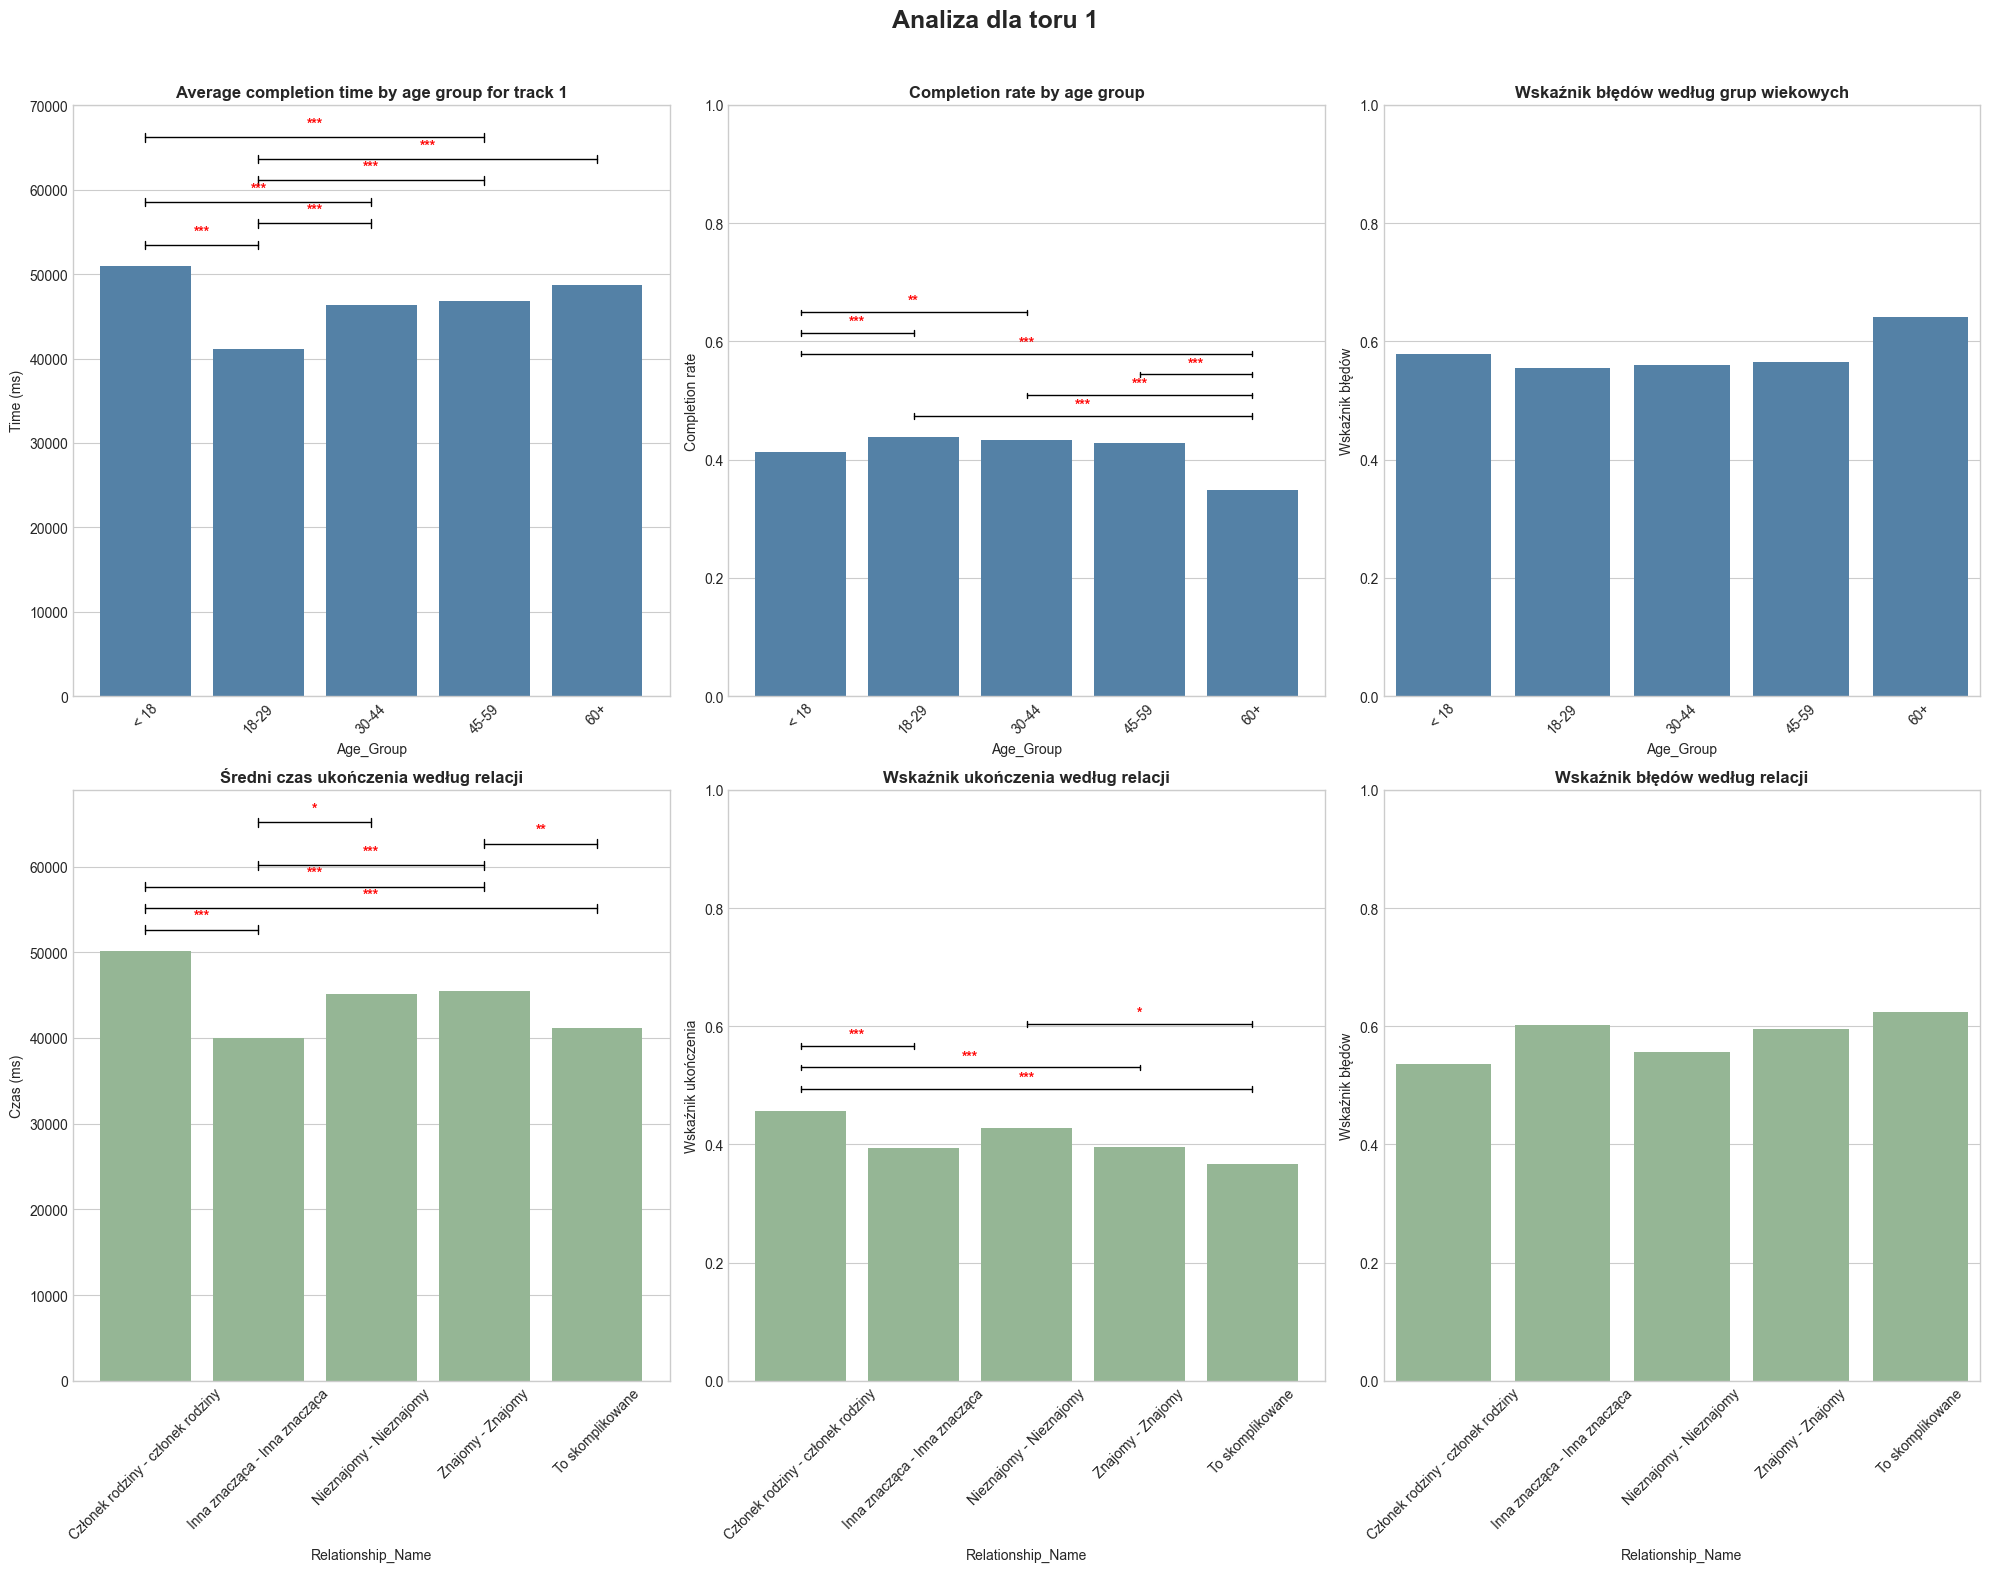


ANALIZA TORU 2

Analiza dla toru 2:
Liczba gier: 16841
Liczba ukończonych gier: 6271
Korelacja wiek (oś X) - czas: -0.0309 (p=0.0145)
Korelacja wiek (oś Y) - czas: -0.0710 (p=0.0000)


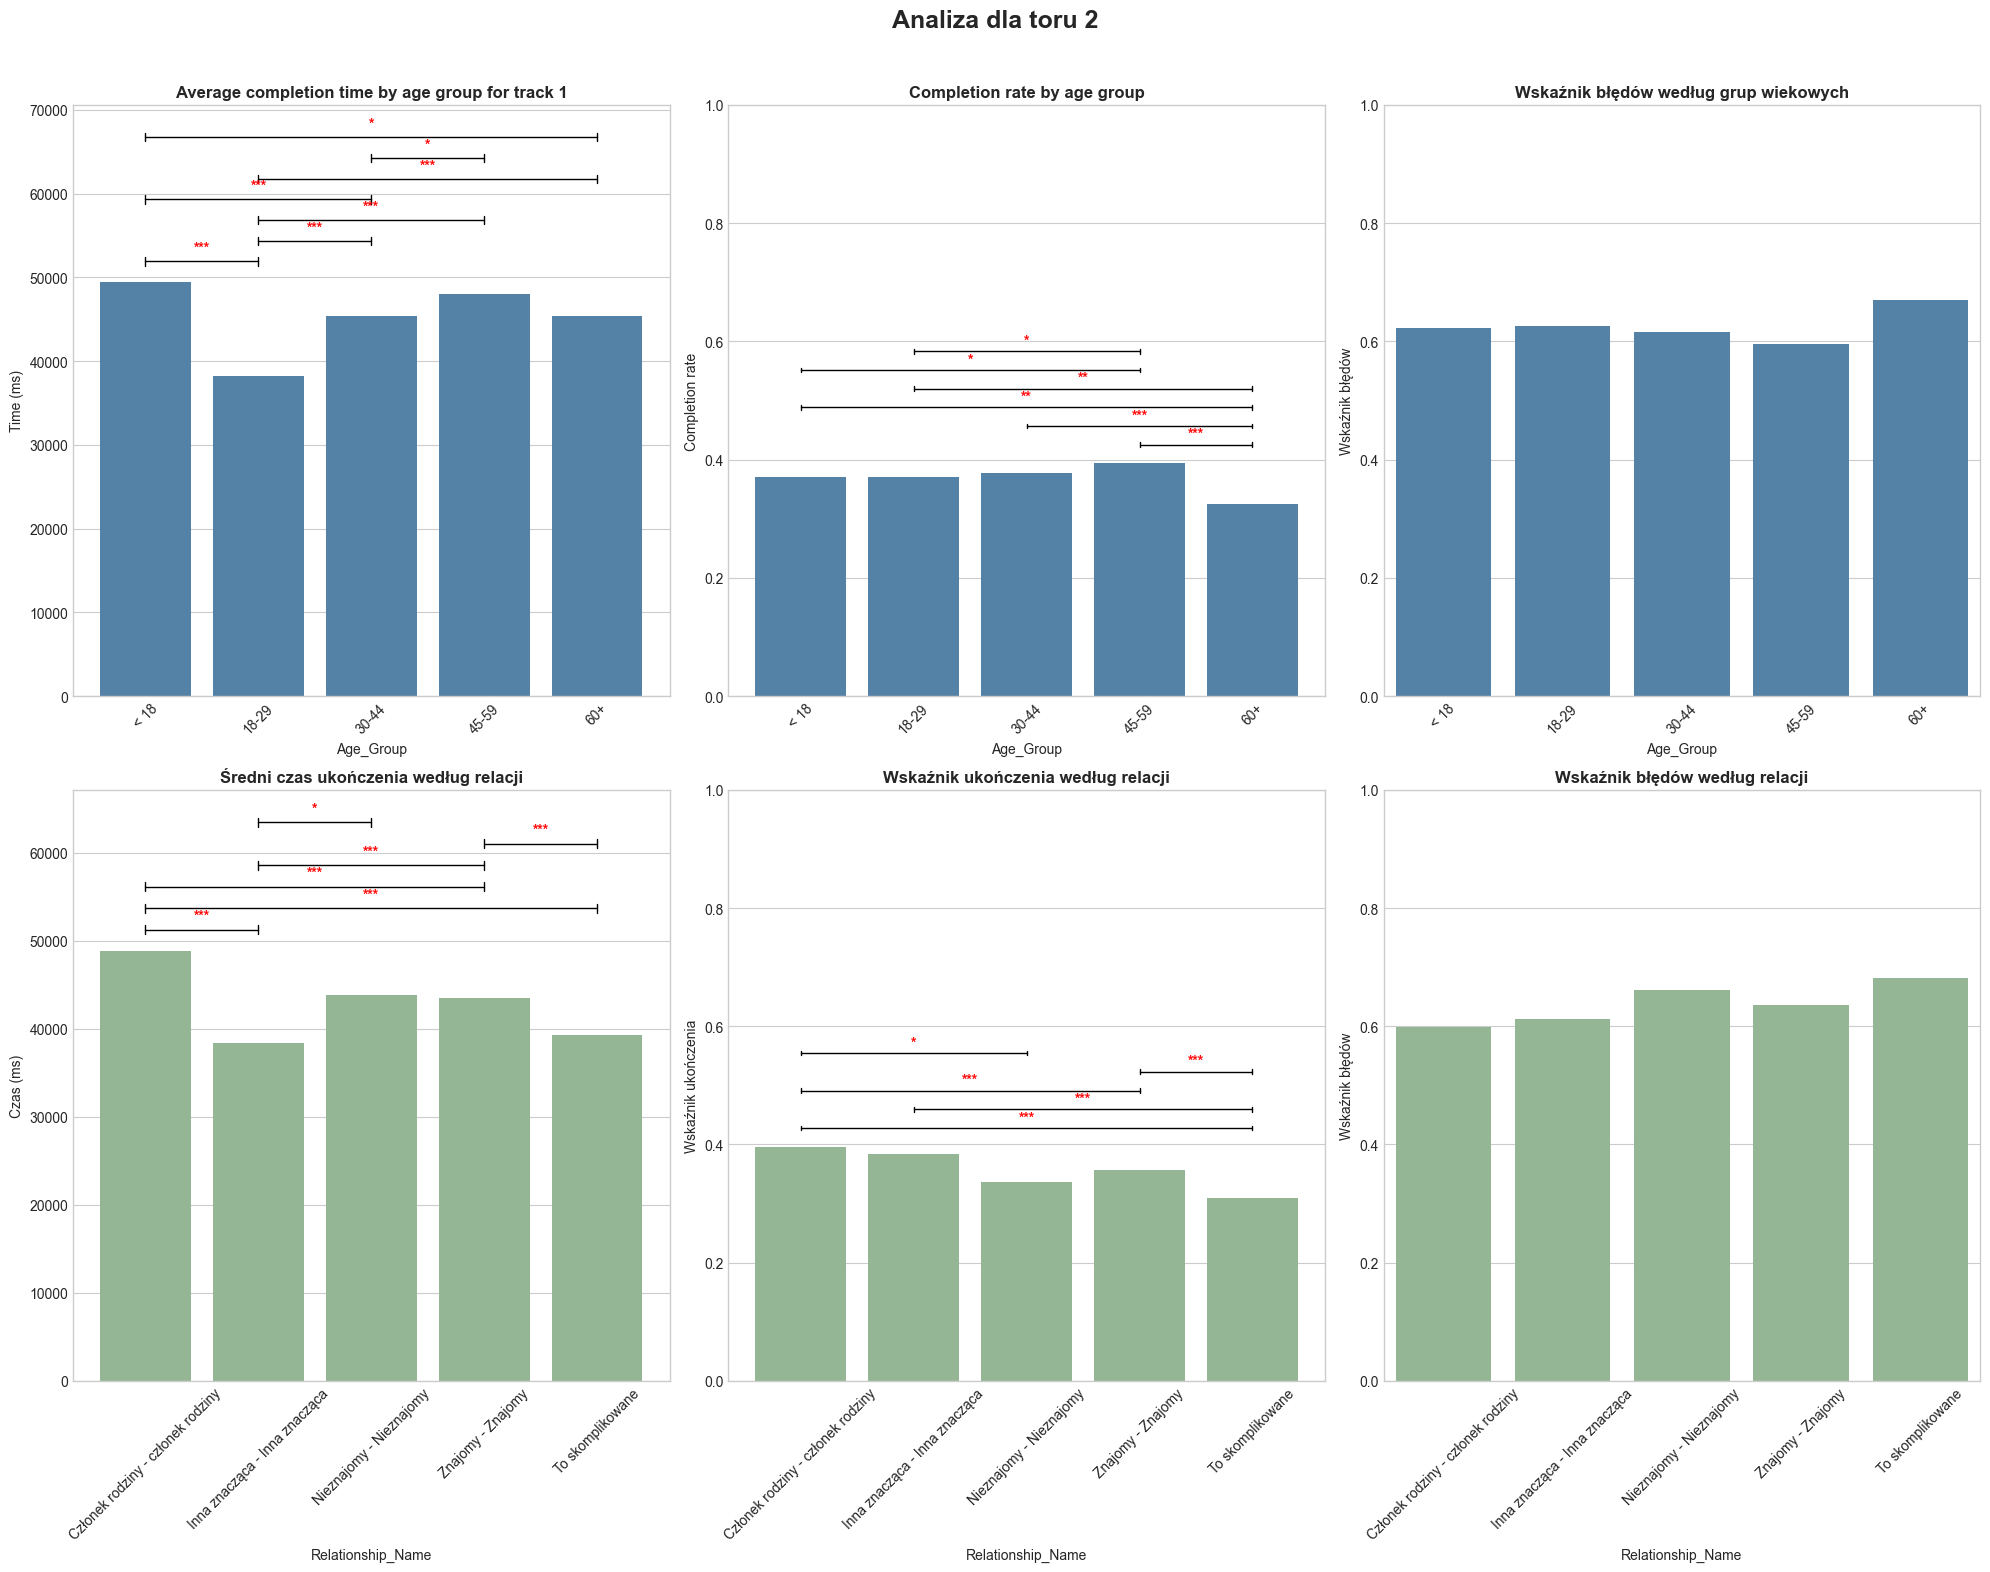


ANALIZA TORU 3

Analiza dla toru 3:
Liczba gier: 14581
Liczba ukończonych gier: 6589
Korelacja wiek (oś X) - czas: -0.0670 (p=0.0000)
Korelacja wiek (oś Y) - czas: -0.0571 (p=0.0000)


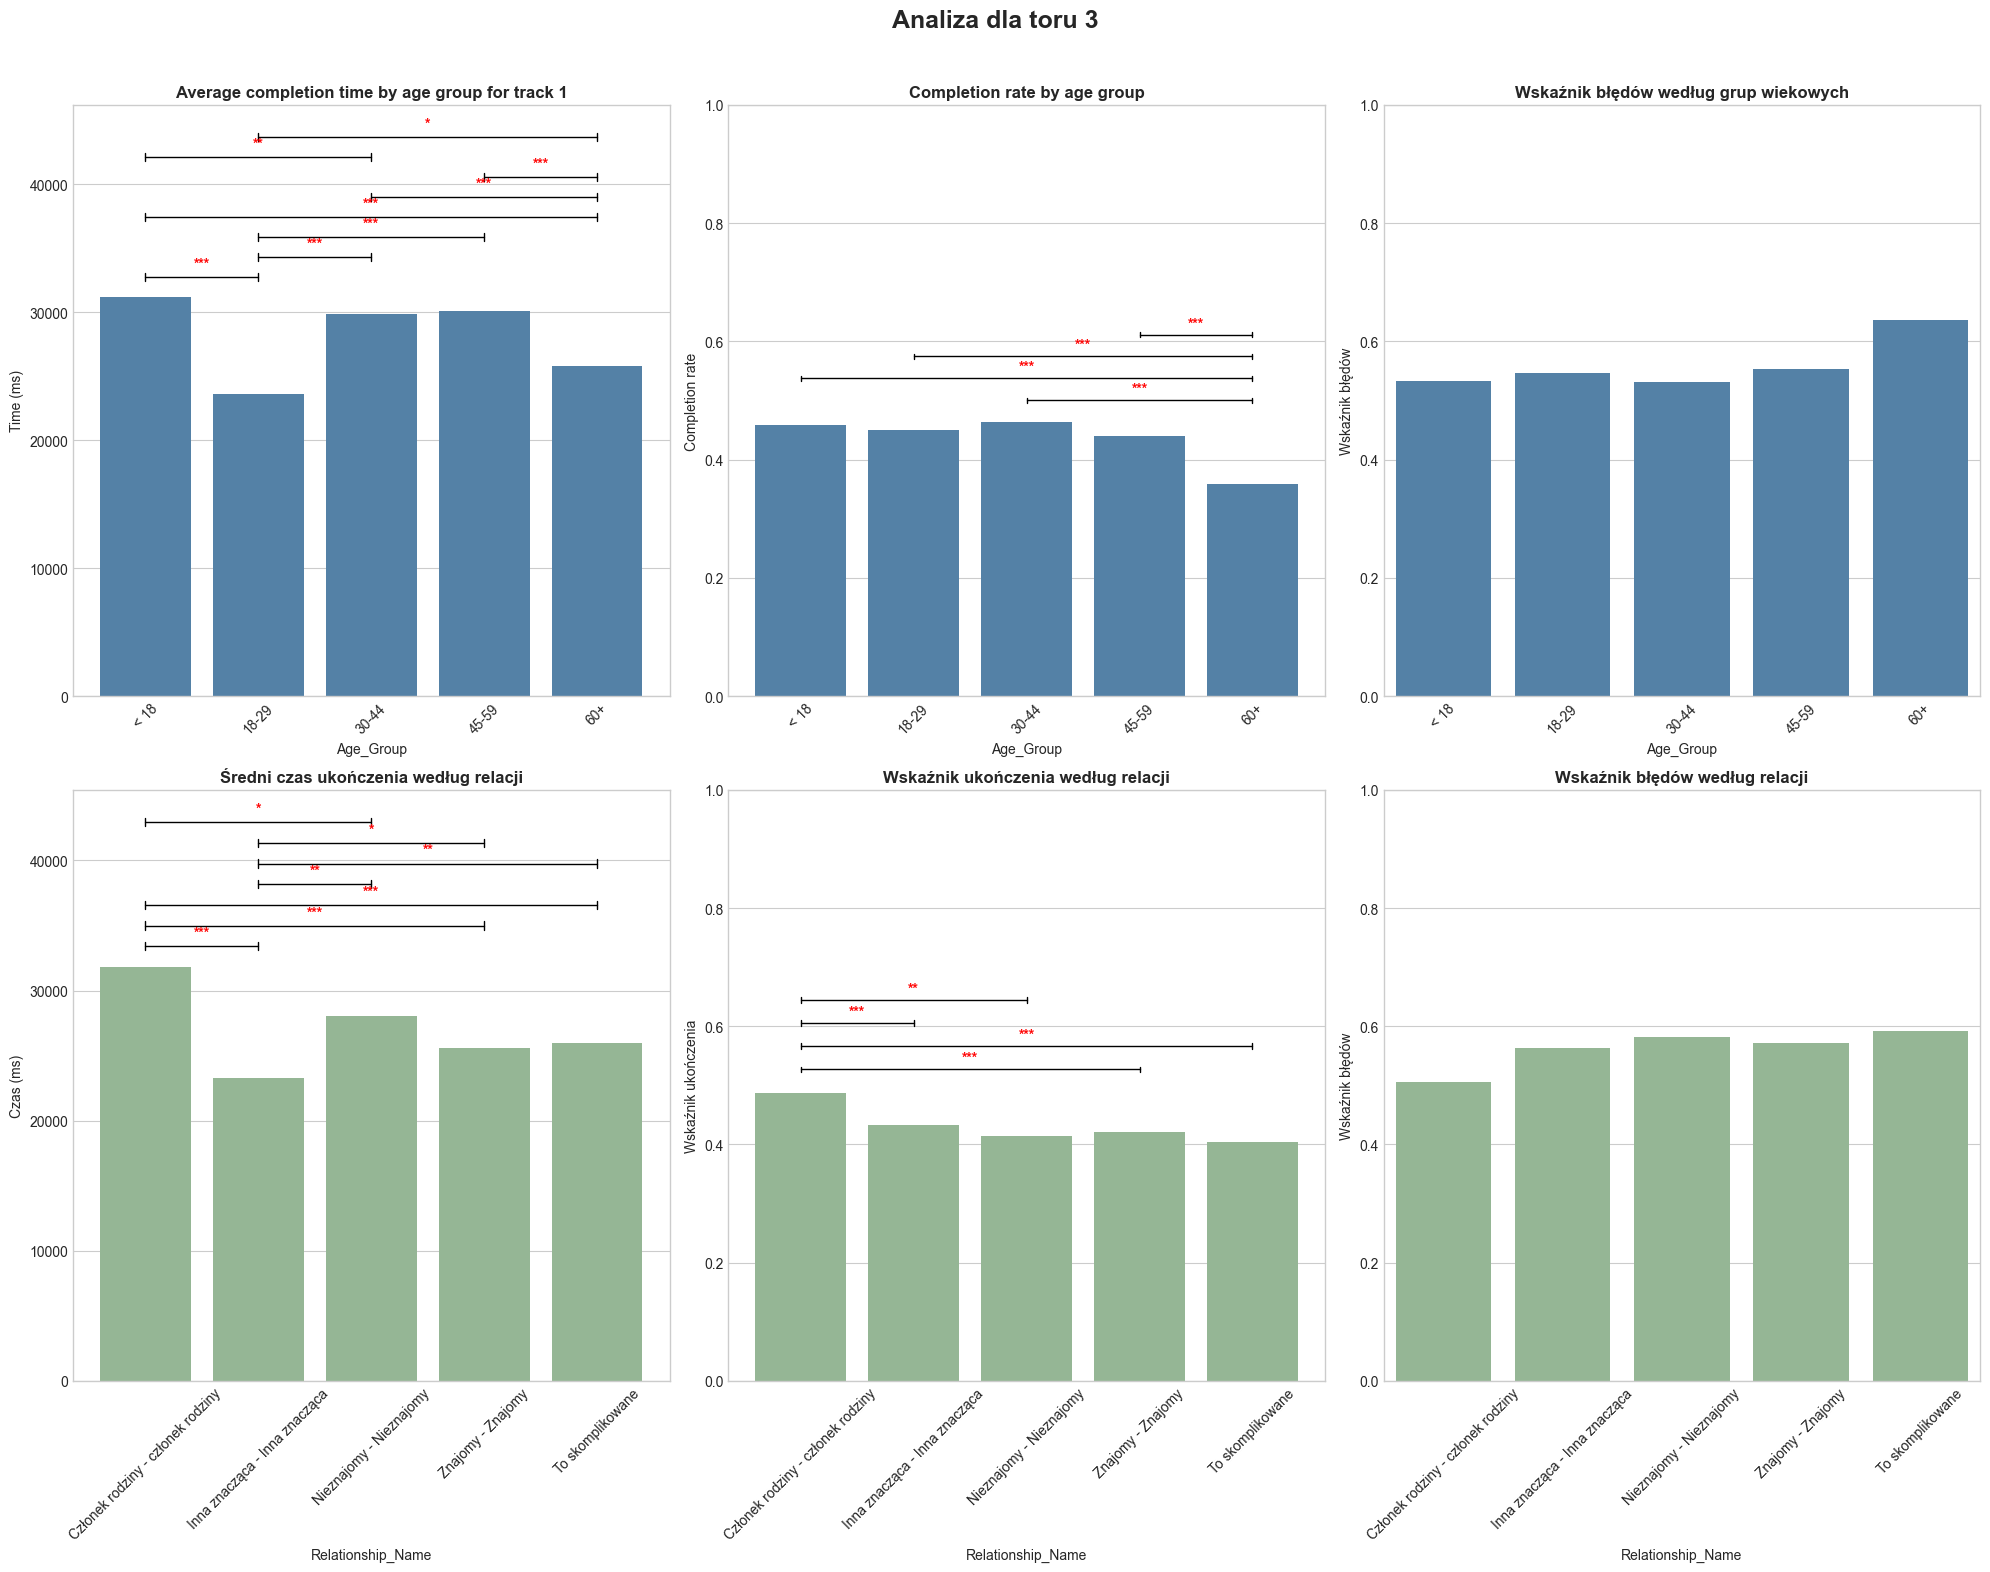


ANALIZA TORU 4

Analiza dla toru 4:
Liczba gier: 10324
Liczba ukończonych gier: 6553
Korelacja wiek (oś X) - czas: -0.0122 (p=0.3247)
Korelacja wiek (oś Y) - czas: -0.0308 (p=0.0128)


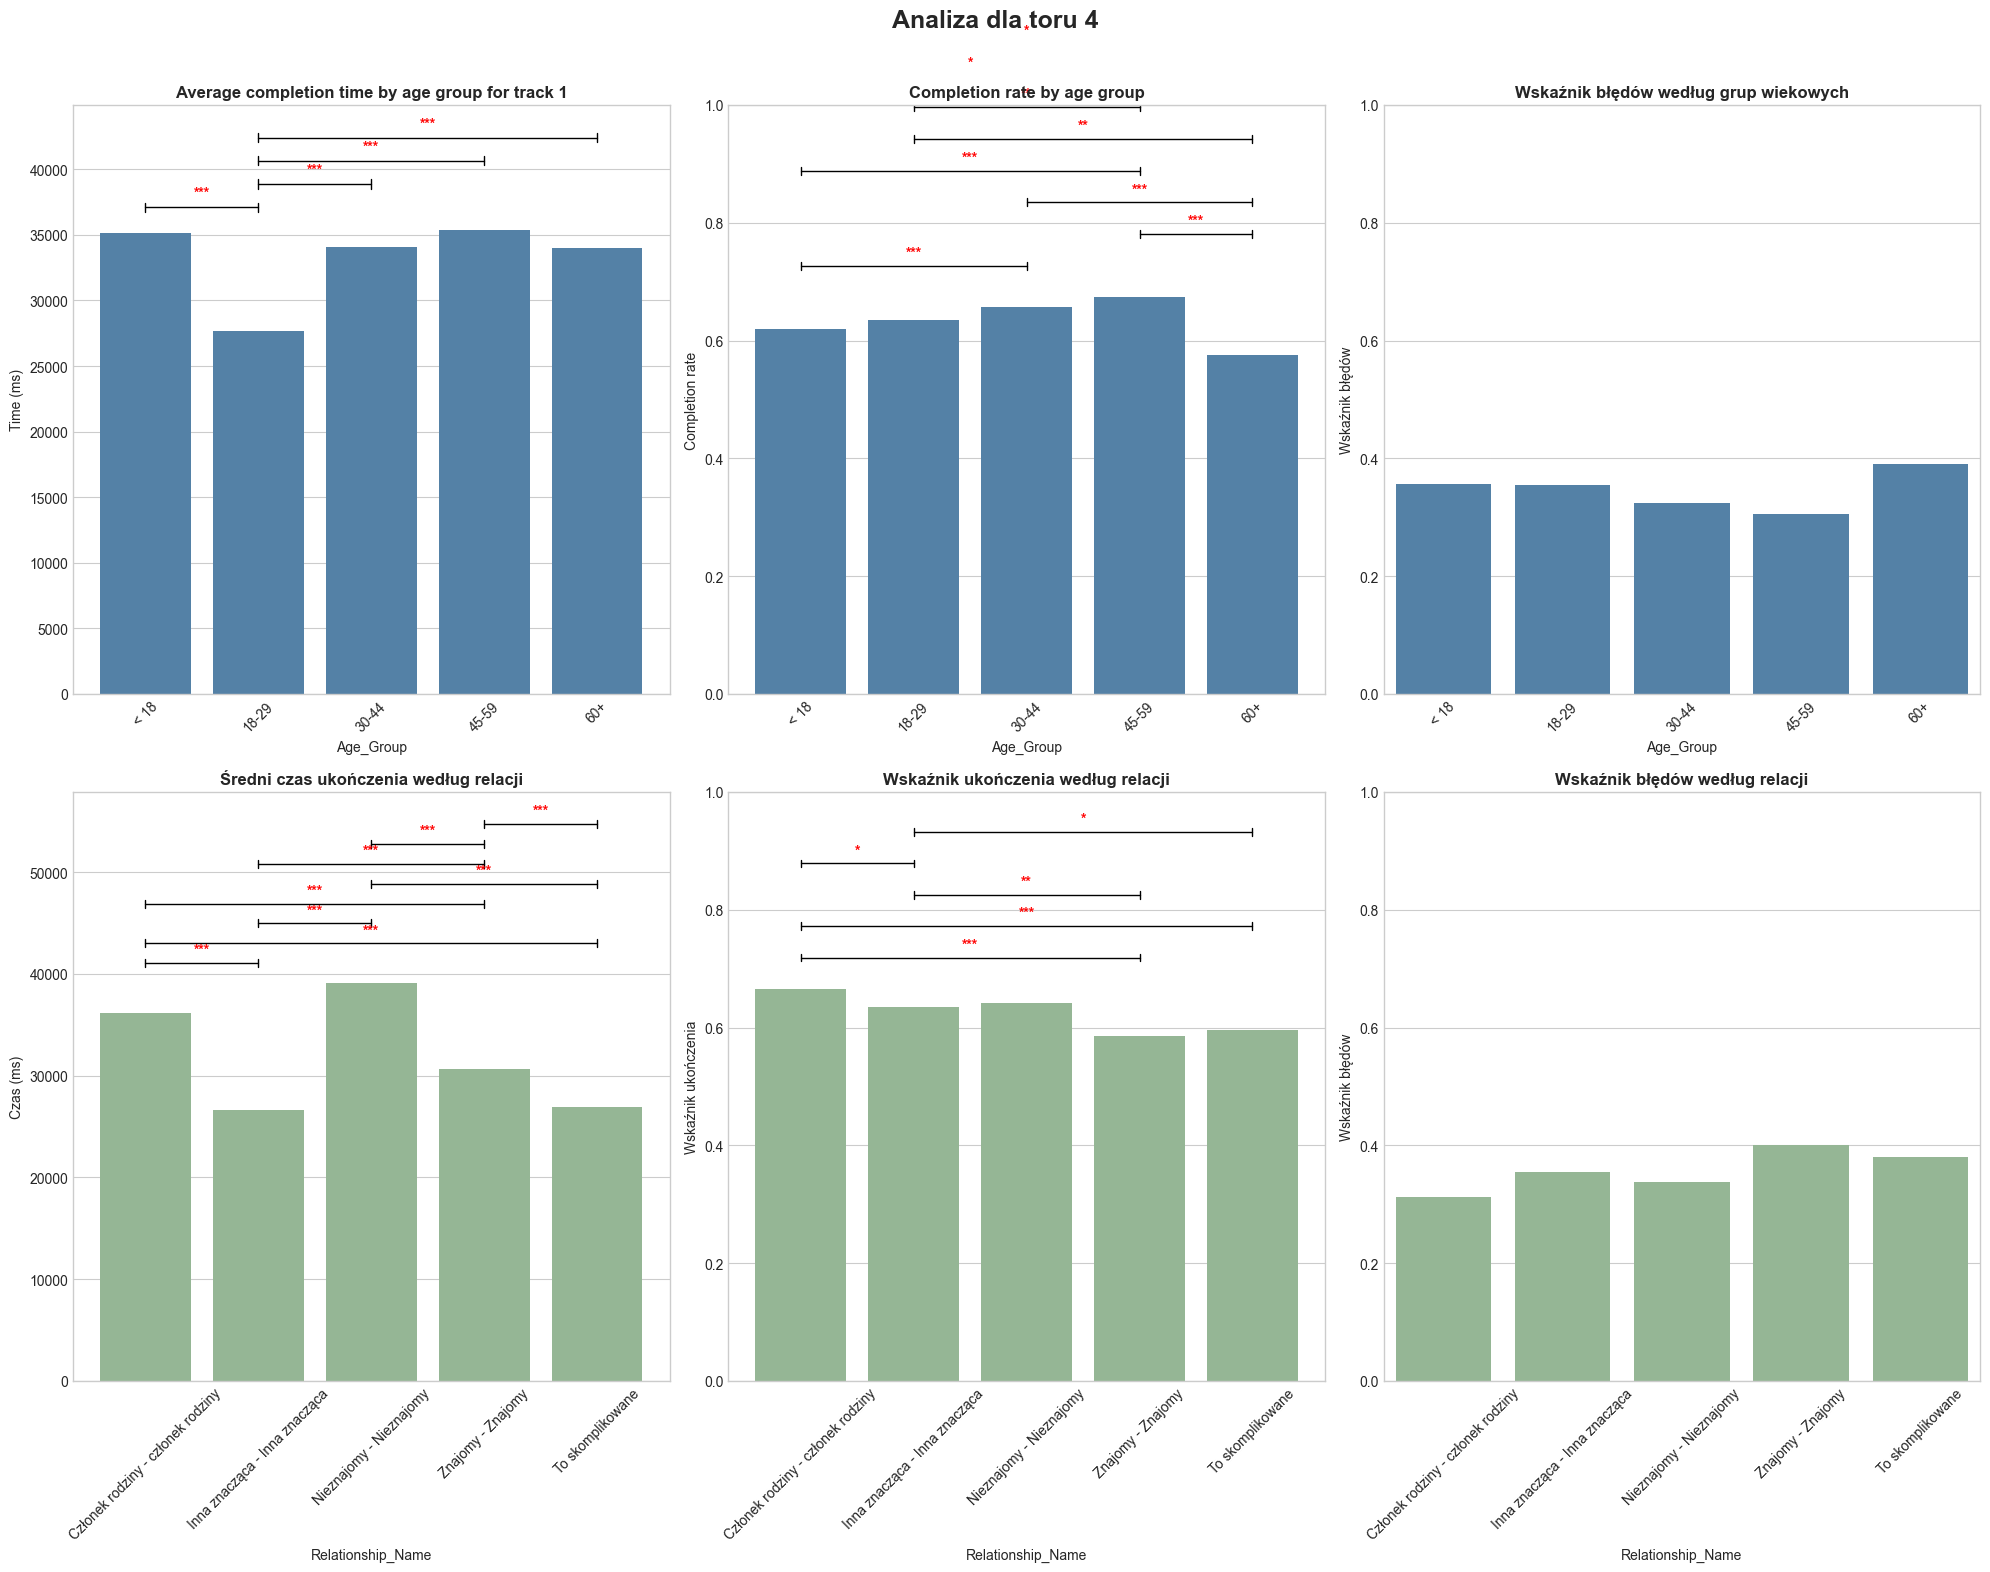


ANALIZA TORU 5

Analiza dla toru 5:
Liczba gier: 9985
Liczba ukończonych gier: 5965
Korelacja wiek (oś X) - czas: -0.0145 (p=0.2616)
Korelacja wiek (oś Y) - czas: -0.0441 (p=0.0007)


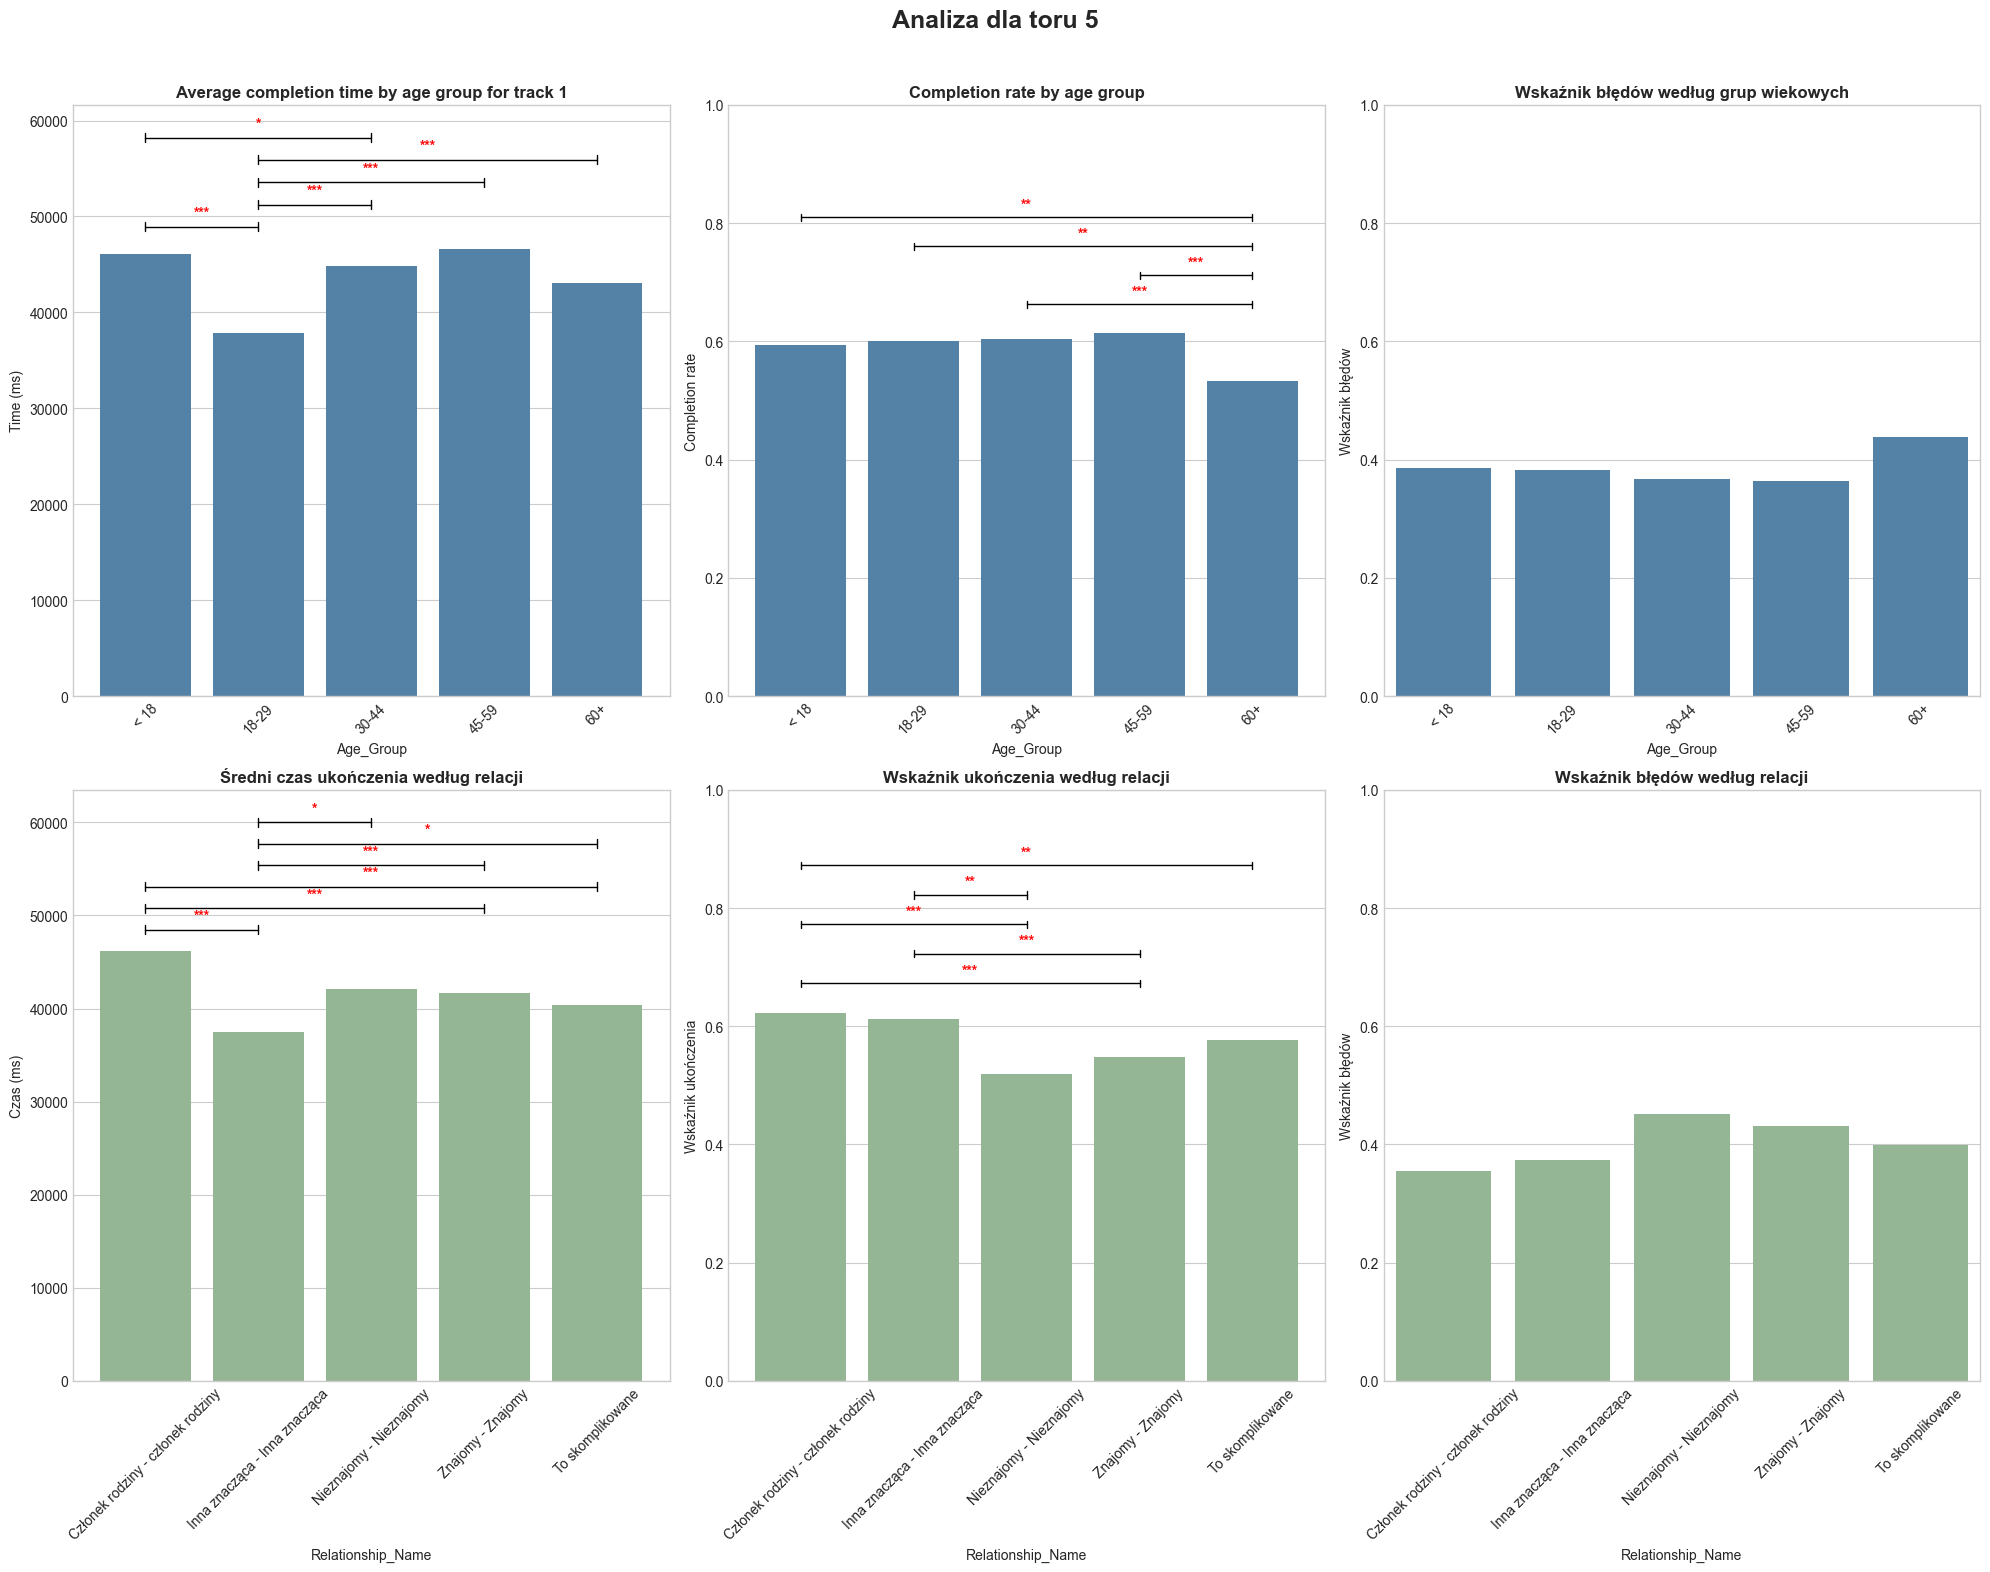


ANALIZA TORU 6

Analiza dla toru 6:
Liczba gier: 11188
Liczba ukończonych gier: 7486
Korelacja wiek (oś X) - czas: 0.0243 (p=0.0358)
Korelacja wiek (oś Y) - czas: -0.0156 (p=0.1779)


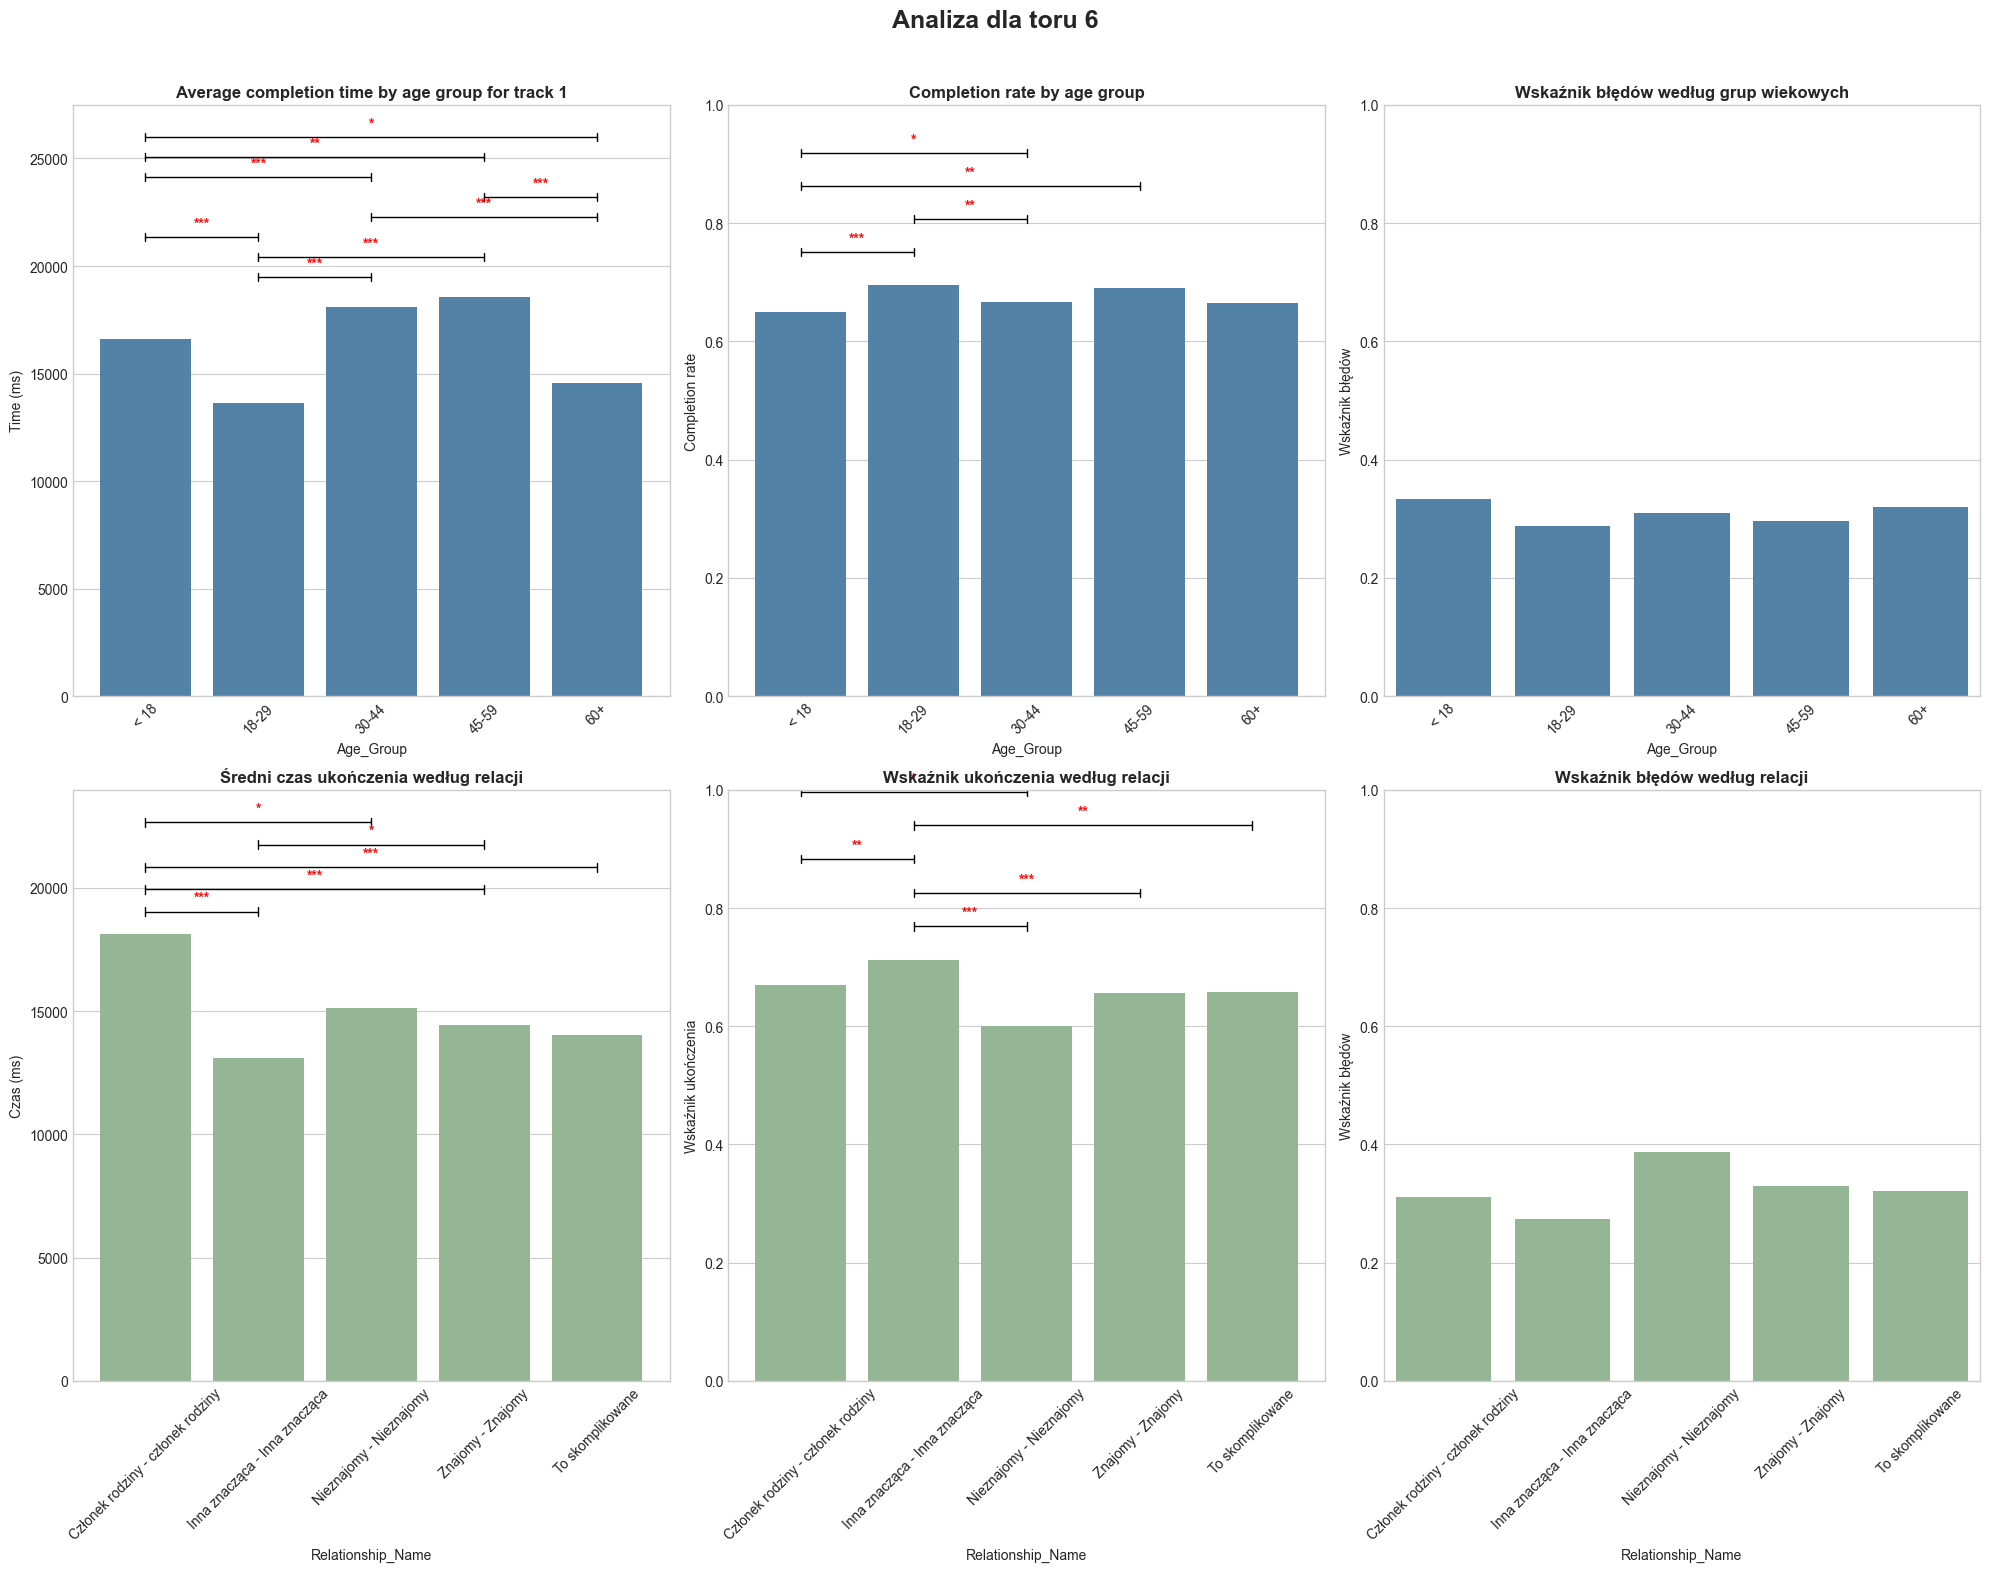


ANALIZA TORU 7

Analiza dla toru 7:
Liczba gier: 14574
Liczba ukończonych gier: 4032
Korelacja wiek (oś X) - czas: -0.0631 (p=0.0001)
Korelacja wiek (oś Y) - czas: -0.0436 (p=0.0057)


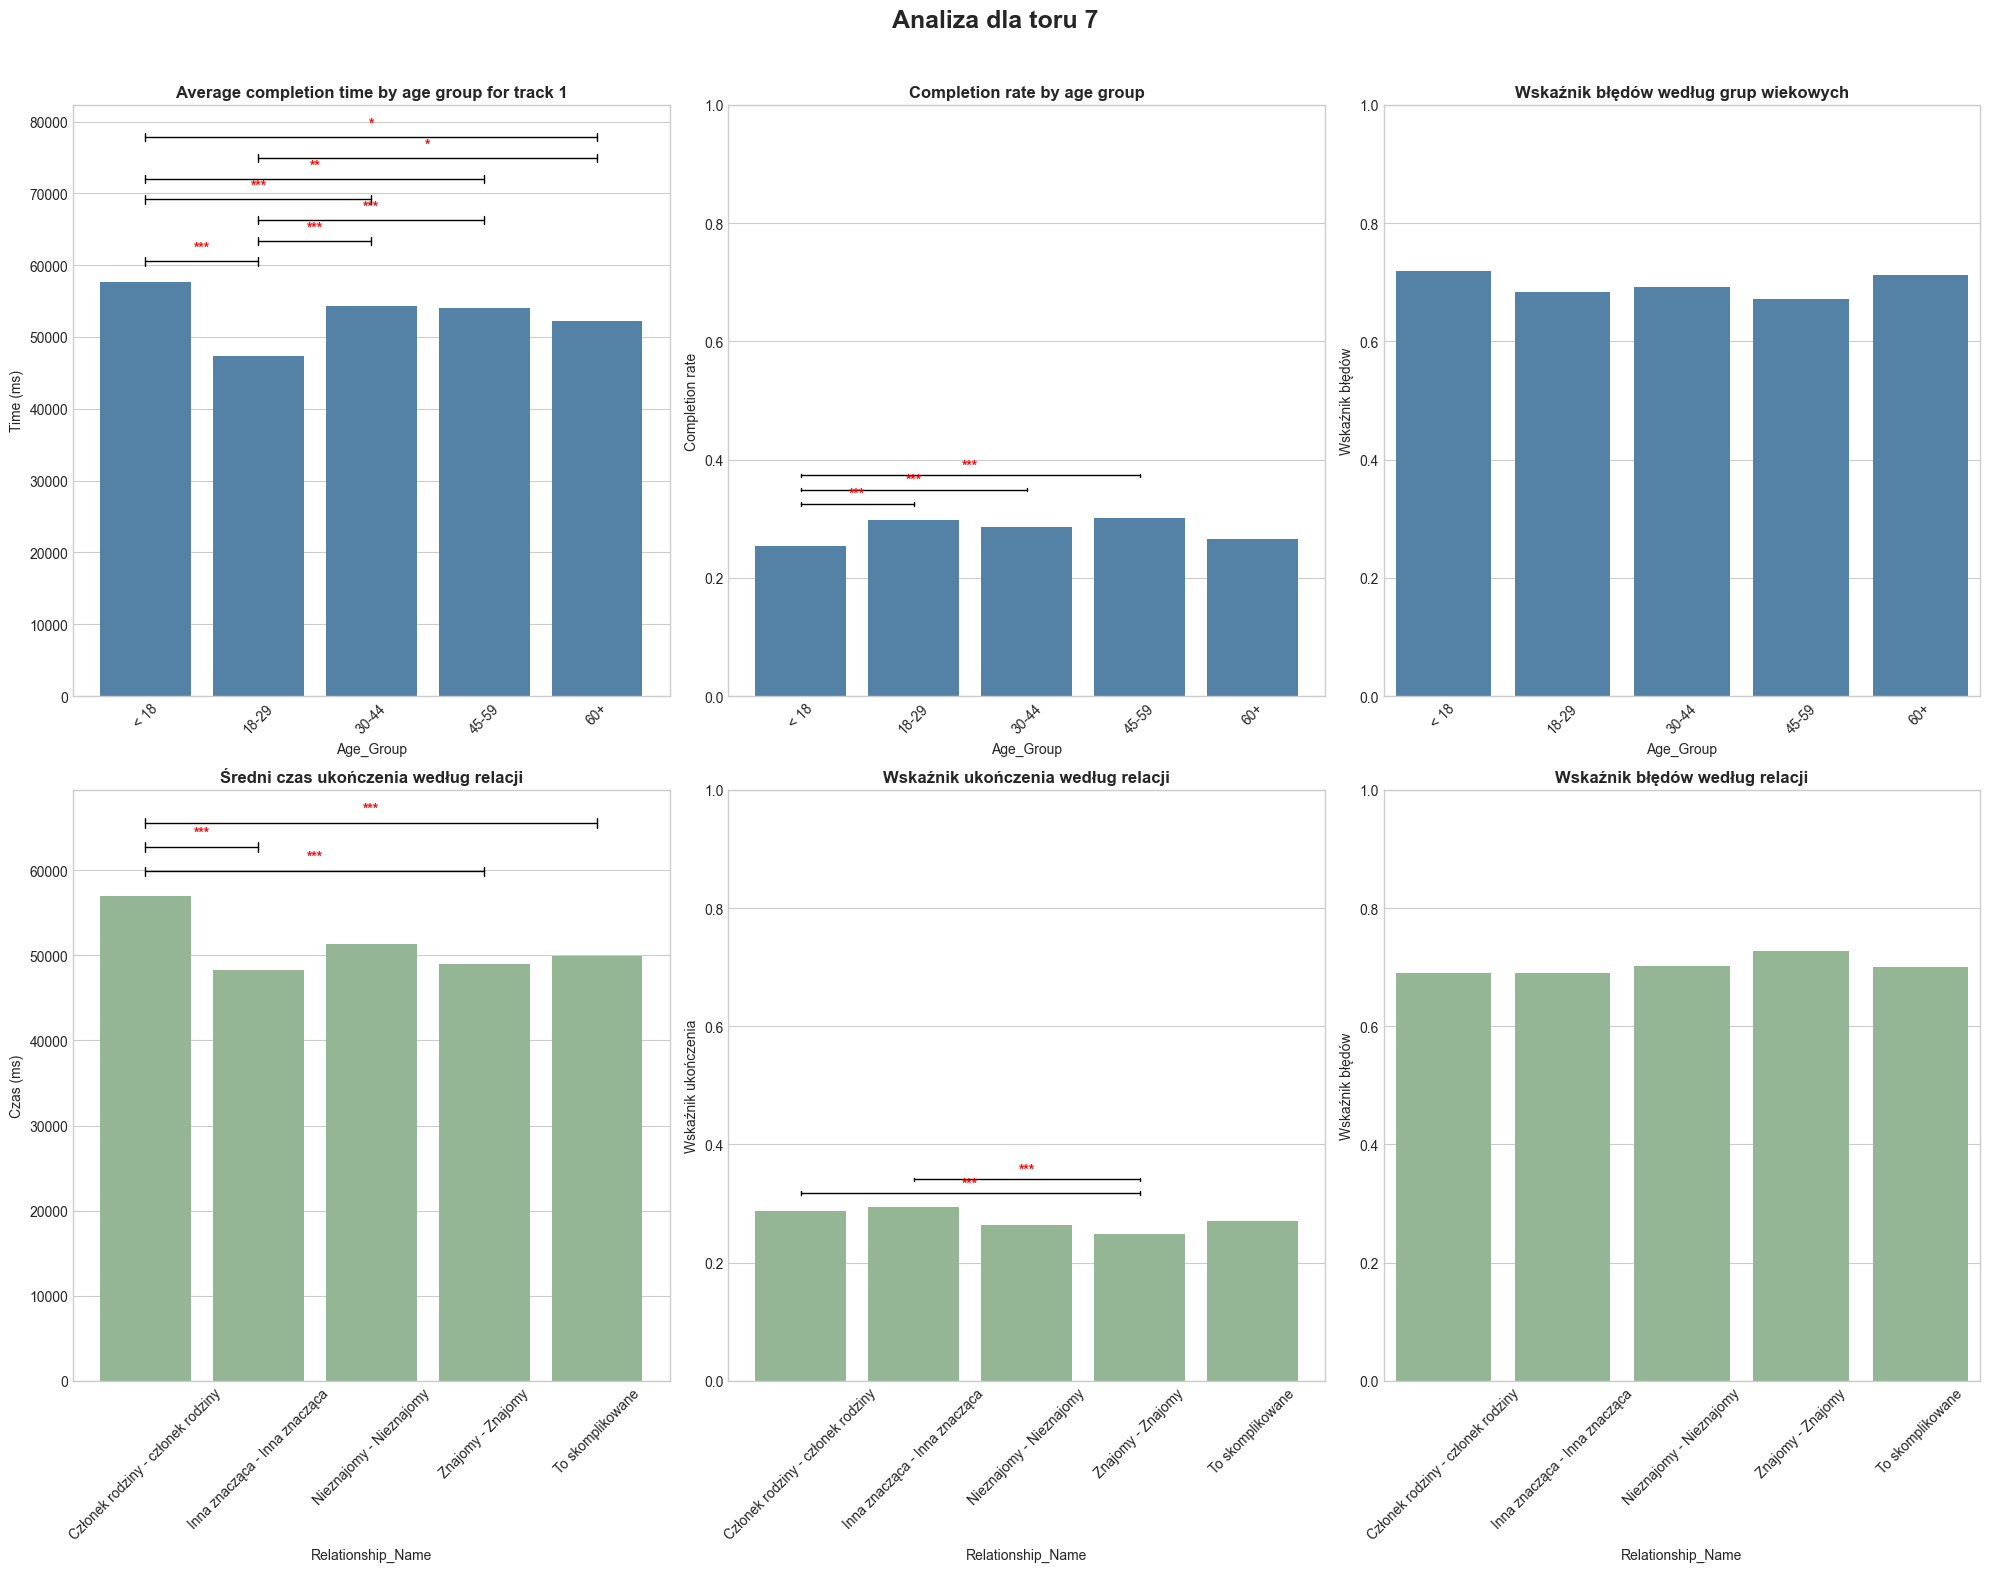


PODSUMOWANIE WSZYSTKICH DANYCH


ValueError: cannot convert float NaN to integer

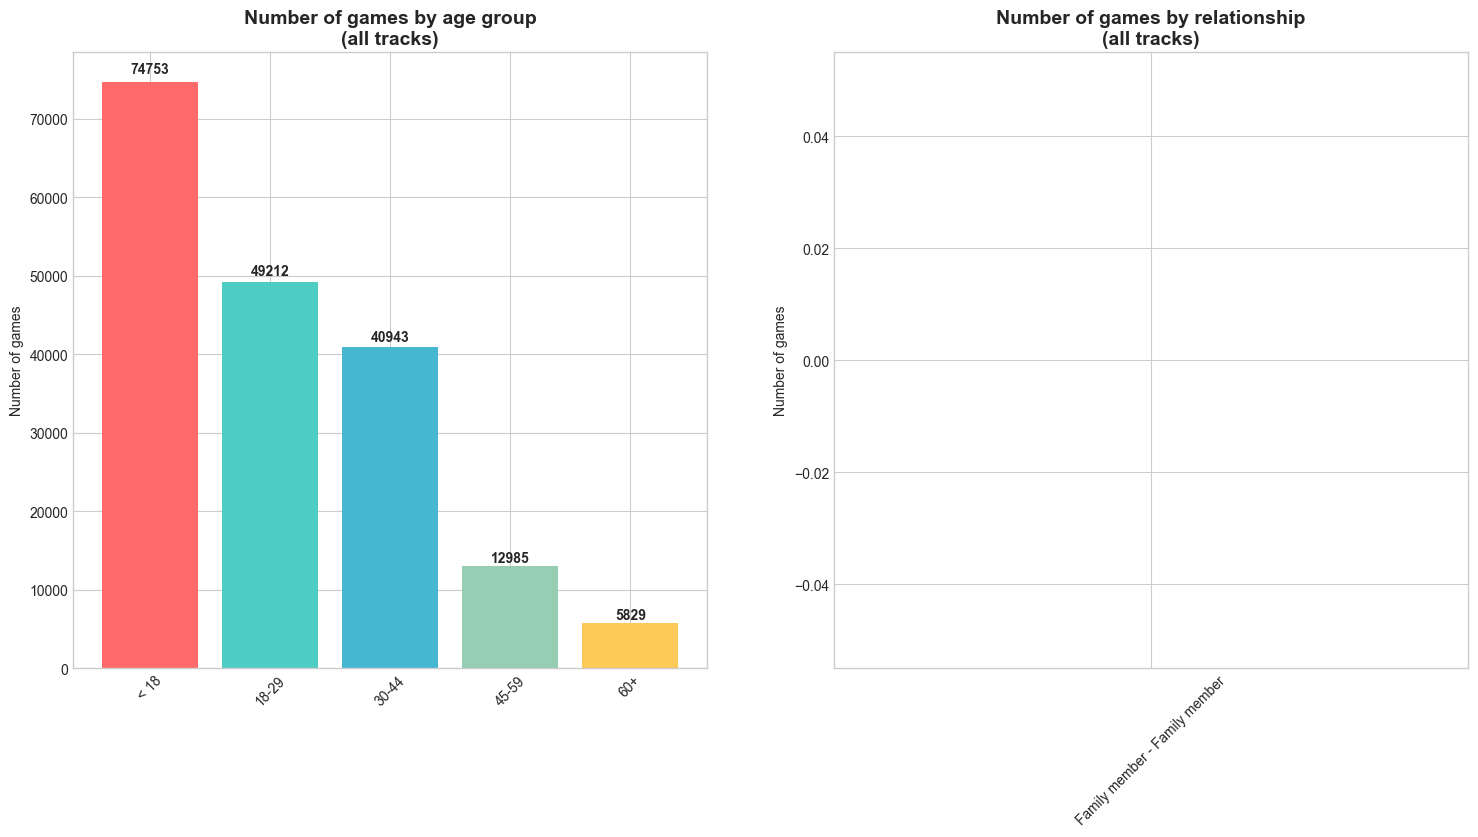

In [13]:
main()

In [ ]:
def compare_all_tracks(games_df, tracks_to_analyze=None):
    """Porównanie wyników między torami z ulepszonymi kolorami i wskaźnikiem błędu"""
    if tracks_to_analyze is None:
        tracks_to_analyze = games_df['Track_ID'].unique()
    
    print(f"Porównywanie torów: {tracks_to_analyze}")
    
    # Przygotowanie danych do porównania
    age_data = []
    rel_data = []
    
    for track_id in tracks_to_analyze:
        print(f"Przetwarzanie danych dla toru {track_id}...")
        track_games = games_df[games_df['Track_ID'] == track_id].copy()
        if track_games.empty:
            print(f"Brak danych dla toru {track_id}")
            continue
        
        # Filtrujemy ukończone gry dla obliczenia średniego czasu
        completed_games = track_games[track_games['Track_Completed'] == True].copy()
        print(f"Liczba ukończonych gier dla toru {track_id}: {len(completed_games)}")
        
        # Przygotowujemy dane dla obu osi
        age_data_x = track_games.copy()
        age_data_x['Age_Group'] = age_data_x['Age_Group_X']
        
        age_data_y = track_games.copy()
        age_data_y['Age_Group'] = age_data_y['Age_Group_Y']
        
        # Łączymy dane z obu osi
        combined_age_data = pd.concat([age_data_x, age_data_y])
        
        # Grupowanie według wieku
        age_groups = combined_age_data.groupby('Age_Group')
        
        for age_group, group in age_groups:
            group_completed = group[group['Track_Completed'] == True]
            
            avg_time = np.nan
            if len(group_completed) > 0:
                avg_time = group_completed['Track_Time'].mean()
            
            age_data.append({
                'Age_Group': age_group,
                'Track_Completed': group['Track_Completed'].mean(),
                'Mistake': group['Mistake'].mean(),
                'Track_Time': avg_time,
                'Track_ID': track_id
            })
        
        # Grupowanie według relacji
        rel_groups = track_games.groupby('Relationship_Name')
        
        for rel_name, group in rel_groups:
            group_completed = group[group['Track_Completed'] == True]
            
            avg_time = np.nan
            if len(group_completed) > 0:
                avg_time = group_completed['Track_Time'].mean()
            
            rel_data.append({
                'Relationship_Name': rel_name,
                'Track_Completed': group['Track_Completed'].mean(),
                'Mistake': group['Mistake'].mean(),
                'Track_Time': avg_time,
                'Track_ID': track_id
            })
    
    # Tworzenie ramek danych z list
    all_age_data = pd.DataFrame(age_data)
    all_rel_data = pd.DataFrame(rel_data)
    
    # Sprawdź, czy mamy jakiekolwiek dane
    if all_age_data.empty or all_rel_data.empty:
        print("UWAGA: Brak danych do porównania torów!")
        return
    
    # Sortowanie grup wiekowych
    age_order = ["< 18", "18-29", "30-44", "45-59", "60+"]
    all_age_data['Age_Group'] = pd.Categorical(all_age_data['Age_Group'], categories=age_order, ordered=True)
    
    # Sortowanie relacji
    rel_order = [
        "Członek rodziny - członek rodziny",
        "Inna znacząca - Inna znacząca", 
        "Nieznajomy - Nieznajomy",
        "Znajomy - Znajomy",
        "To skomplikowane"
    ]
    all_rel_data['Relationship_Name'] = pd.Categorical(all_rel_data['Relationship_Name'], categories=rel_order, ordered=True)
    
    # Zastąp NaN zerem
    all_age_data['Track_Time'] = all_age_data['Track_Time'].fillna(0)
    all_rel_data['Track_Time'] = all_rel_data['Track_Time'].fillna(0)
    
    # Zapisz dane do plików CSV dla debugowania
    output_dir = 'wyniki_analizy'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    all_age_data.to_csv(os.path.join(output_dir, 'porownanie_wszystkie_tory_wiek.csv'), index=False)
    all_rel_data.to_csv(os.path.join(output_dir, 'porownanie_wszystkie_tory_relacje.csv'), index=False)
    
    # Definiowanie różnorodnych kolorów dla torów
    track_colors = {
        1: '#FF6B6B',  # Czerwony koralowy
        2: '#4ECDC4',  # Turkusowy
        3: '#45B7D1',  # Niebieski
        4: '#96CEB4',  # Miętowy zielony
        5: '#FECA57',  # Żółty
        6: '#FF9FF3',  # Różowy
        7: '#54A0FF'   # Jasnoniebieski
    }
    
    # Utworzenie palety kolorów dla dostępnych torów
    available_tracks = sorted(all_age_data['Track_ID'].unique())
    colors = [track_colors.get(track, '#95A5A6') for track in available_tracks]
    
    # Wizualizacja porównania torów z 6 wykresami (dodano wskaźnik błędu)
    plt.figure(figsize=(20, 12))
    
    # 1.1 Czas ukończenia według wieku
    plt.subplot(2, 3, 1)
    try:
        for i, track in enumerate(available_tracks):
            track_data = all_age_data[all_age_data['Track_ID'] == track]
            plt.plot(track_data['Age_Group'], track_data['Track_Time'], 
                    marker='o', linewidth=3, markersize=8, color=colors[i], label=f'Tor {track}')
        
        plt.title('Średni czas ukończenia według grup wiekowych', fontweight='bold', fontsize=14)
        plt.ylabel('Czas (ms)')
        plt.xticks(rotation=45)
        plt.legend(title='Tor', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
    except Exception as e:
        print(f"Błąd podczas tworzenia wykresu czasu ukończenia według wieku: {str(e)}")
    
    # 1.2 Wskaźnik ukończenia według wieku
    plt.subplot(2, 3, 2)
    try:
        for i, track in enumerate(available_tracks):
            track_data = all_age_data[all_age_data['Track_ID'] == track]
            plt.plot(track_data['Age_Group'], track_data['Track_Completed'], 
                    marker='o', linewidth=3, markersize=8, color=colors[i], label=f'Tor {track}')
        
        plt.title('Wskaźnik ukończenia według grup wiekowych', fontweight='bold', fontsize=14)
        plt.ylabel('Wskaźnik ukończenia')
        plt.ylim(0, 1)
        plt.xticks(rotation=45)
        plt.legend(title='Tor', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
    except Exception as e:
        print(f"Błąd podczas tworzenia wykresu wskaźnika ukończenia według wieku: {str(e)}")
    
    # 1.3 Wskaźnik błędów według wieku
    plt.subplot(2, 3, 3)
    try:
        for i, track in enumerate(available_tracks):
            track_data = all_age_data[all_age_data['Track_ID'] == track]
            plt.plot(track_data['Age_Group'], track_data['Mistake'], 
                    marker='o', linewidth=3, markersize=8, color=colors[i], label=f'Tor {track}')
        
        plt.title('Wskaźnik błędów według grup wiekowych', fontweight='bold', fontsize=14)
        plt.ylabel('Wskaźnik błędów')
        plt.ylim(0, 1)
        plt.xticks(rotation=45)
        plt.legend(title='Tor', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
    except Exception as e:
        print(f"Błąd podczas tworzenia wykresu wskaźnika błędów według wieku: {str(e)}")
    
    # 2.1 Czas ukończenia według relacji
    plt.subplot(2, 3, 4)
    try:
        for i, track in enumerate(available_tracks):
            track_data = all_rel_data[all_rel_data['Track_ID'] == track]
            plt.plot(track_data['Relationship_Name'], track_data['Track_Time'], 
                    marker='o', linewidth=3, markersize=8, color=colors[i], label=f'Tor {track}')
        
        plt.title('Średni czas ukończenia według relacji', fontweight='bold', fontsize=14)
        plt.ylabel('Czas (ms)')
        plt.xticks(rotation=45)
        plt.legend(title='Tor', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
    except Exception as e:
        print(f"Błąd podczas tworzenia wykresu czasu ukończenia według relacji: {str(e)}")
    
    # 2.2 Wskaźnik ukończenia według relacji
    plt.subplot(2, 3, 5)
    try:
        for i, track in enumerate(available_tracks):
            track_data = all_rel_data[all_rel_data['Track_ID'] == track]
            plt.plot(track_data['Relationship_Name'], track_data['Track_Completed'], 
                    marker='o', linewidth=3, markersize=8, color=colors[i], label=f'Tor {track}')
        
        plt.title('Wskaźnik ukończenia według relacji', fontweight='bold', fontsize=14)
        plt.ylabel('Wskaźnik ukończenia')
        plt.ylim(0, 1)
        plt.xticks(rotation=45)
        plt.legend(title='Tor', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
    except Exception as e:
        print(f"Błąd podczas tworzenia wykresu wskaźnika ukończenia według relacji: {str(e)}")
    
    # 2.3 Wskaźnik błędów według relacji
    plt.subplot(2, 3, 6)
    try:
        for i, track in enumerate(available_tracks):
            track_data = all_rel_data[all_rel_data['Track_ID'] == track]
            plt.plot(track_data['Relationship_Name'], track_data['Mistake'], 
                    marker='o', linewidth=3, markersize=8, color=colors[i], label=f'Tor {track}')
        
        plt.title('Wskaźnik błędów według relacji', fontweight='bold', fontsize=14)
        plt.ylabel('Wskaźnik błędów')
        plt.ylim(0, 1)
        plt.xticks(rotation=45)
        plt.legend(title='Tor', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3)
    except Exception as e:
        print(f"Błąd podczas tworzenia wykresu wskaźnika błędów według relacji: {str(e)}")
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    
    # Dodaj główny tytuł
    plt.suptitle('Porównanie wszystkich torów - analiza według wieku i relacji', 
                 fontsize=16, fontweight='bold', y=0.98)
    
    # Wyświetl wykres w notebooku
    plt.show()
    
    plt.savefig(os.path.join(output_dir, 'porownanie_wszystkie_tory_ulepszone.png'), 
                dpi=300, bbox_inches='tight')
    plt.close()
    
    return all_age_data, all_rel_data

In [6]:
games_df = pd.read_csv('output/games/games.csv')  # Dostosuj ścieżkę do pliku   
compare_all_tracks_improved(games_df)

Porównywanie torów: [ 2  4  6  3  1  7  5  8 14 23 11  9 10 12 13]
Przetwarzanie danych dla toru 2...
Liczba ukończonych gier dla toru 2: 8079


KeyError: 'Age_Group_X'